In [181]:
from IPython.display import HTML
from IPython.display import Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Stacking House Prices - Оценка стоимости домов

 **Какие характеристики помогают повысить стоимость дома?**

Из этого исследования можно выделить несколько ключевых вещей:
- ** Местоположение ** 
- ** Размер ** 
- ** Особенности ** - новейшие коммунальные услуги и дополнительные услуги (такие как гараж) очень желательны.

***

<a id='Библиотеки'></a>
# 1. 
## Библиотеки

In [182]:
# Этот первый набор пакетов включает в себя Pandas для манипулирования данными,
# numpy для математических вычислений и matplotlib & seaborn для визуализации..
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')

# Статистические пакеты, используемые для преобразований
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr
print('Statistical packages imported!')

# Метрики, используемые для измерения точности и производительности моделей
#from sklearn import metrics
#from sklearn.metrics import mean_squared_error
print('Metrics packages imported!')

# Алгоритмы, используемые для моделирования
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
print('Algorithm packages imported!')

# Пайплайн и масштабирование будут использоваться для чувствительных моделей
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print('Pipeline and preprocessing packages imported!')

# Пакеты выбора модели, используемые для выборки набора данных и оптимизации параметров
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Model selection packages imported!')

# Установить цвета визуализации
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)
print('My colours are ready! :)')

# Игнорировать раздражающее предупреждение
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore раздражающее предупреждение (от sklearn и seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warning will be ignored!')

Data Manipulation, Mathematical Computation and Visualisation packages imported!
Statistical packages imported!
Metrics packages imported!
Algorithm packages imported!
Pipeline and preprocessing packages imported!
Model selection packages imported!
My colours are ready! :)
Deprecation warning will be ignored!


***

<a id='load_data'></a>
# 2. 
## Load data

In [183]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Сохраняю столбец «Id»
train_ID = train['Id']
test_ID = test['Id']

# Теперь удаляю столбец «Id», так как он избыточен для моделирования
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print(train.shape)
print(test.shape)
train.head()

(1460, 80)
(1459, 79)


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
0         Lvl    AllPub    Inside    ...            0    NaN   NaN   
1         Lvl    AllPub       FR2    ...            0    NaN   NaN   
2         Lvl    AllPub    Inside    ...            0    NaN   NaN   
3         Lvl    AllPub    Corner    ...            0    NaN   NaN   
4         Lvl    AllPub       FR2    ...            0    NaN   NaN   

  MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0         NaN       0      2    2008        WD         Normal     208500  
1         NaN       0      5    2007        WD         Normal     181500  
2         NaN       0      9    2008        WD         Normal     223500  
3         NaN       0      2    2006        WD        Abnorml     140000  
4         NaN       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

- Как указано в конкурсе, этот набор данных включает в себя 79 описательных характеристик домов.

***

<a id='data_preparation'></a>
# 3. 
## Подготовка данных

<a id='remove_outliers'></a>
### 3.1 Удаление выбросов

- По определению, выброс - это то, что находится за пределами ожидаемого ответа. Насколько вы готовы считать что-то посторонним, зависит от человека и проблемы.
- Исходя из этого определения, этот выброс будет находиться за пределами распределения точек данных. Следовательно, это искажает распределение данных и потенциальных расчетов.
- Посмотрим, как это повлияет на прогнозы будущего.

Удаляю все дома площадью более 4000 квадратных футов, потому что они оценены из-за своих размеров

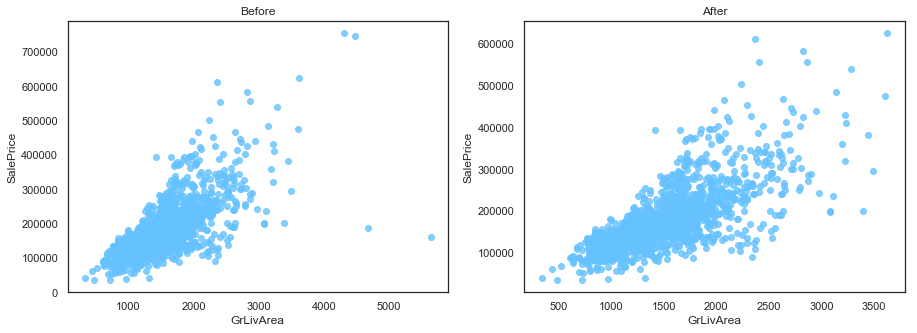

In [184]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['GrLivArea']>4000)].index)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("After")

***

<a id='treat_missing_values'></a>
### 3.2 -  Работа с пропущенными значениями

Пропущенное значение - это запись в столбце, которой не присвоено значение. Это может означать несколько вещей:
- Отсутствующее значение может быть ** результатом ошибки при создании набора данных **. Это может быть человеческая ошибка или машинная ошибка в зависимости от того, откуда поступают данные.
- Отсутствующее значение в некоторых случаях может означать, что ** должен присутствовать «ноль» **. В этом случае его можно заменить на 0. Предоставленное описание данных помогает решать подобные ситуации.

** Если у вас пропущены значения, у вас есть два варианта **:
- удалить всю строку
- Заполните пропущенную запись значением

Чтобы обработать этот набор данных, прежде всего я создам набор данных обучения и тестовых данных, чтобы сделать изменения согласованными для обоих. Затем я переберу каждую переменную с пропущенными значениями и рассмотрю их индивидуально на основе описания данных или моего суждения.

In [185]:
# Прежде всего, сохраняю длинну данных для последующего использования.
ntrain = train.shape[0]
ntest = test.shape[0]

# Также сохраняю целевое значение, так как мы удалим это
y_train = train.SalePrice.values

# объединить данные обучения и тестирования в all_data
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data shape: {}".format(all_data.shape))

all_data shape: (2915, 79)


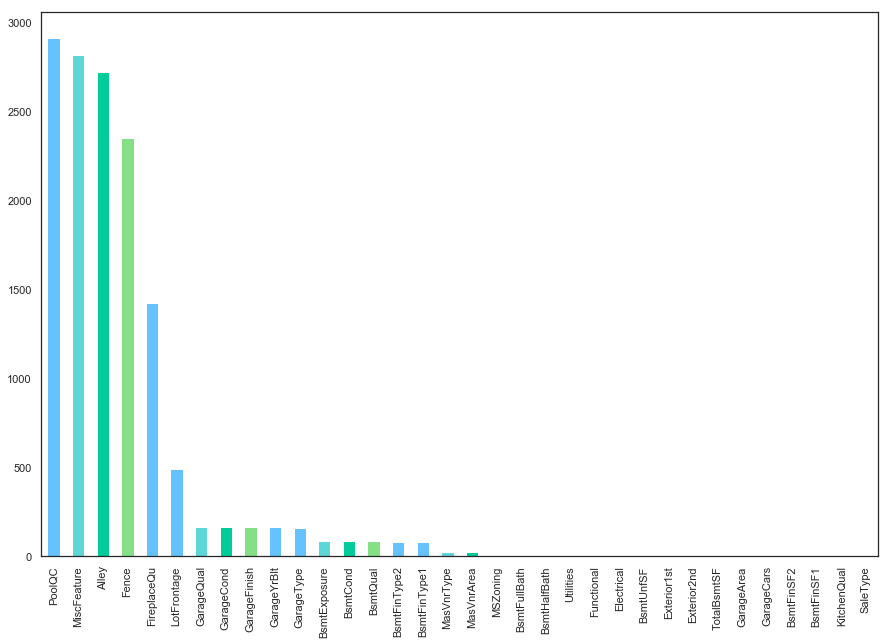

In [186]:
# агрегировать все нулевые значения
all_data_na = all_data.isnull().sum()

# избавиться от всех значений с 0 пропущенными значениями
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.subplots(figsize =(15, 10))
all_data_na.plot(kind='bar');

In [187]:
# Используя описание данных, заполняю эти пропущенные значения
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
           "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2", "MSSubClass", "MasVnrType"):
    all_data[col] = all_data[col].fillna("None")
print("'None' - treated...")

# Площадь участка, вероятно, будет похожа на дома в окрестностях.
# Поэтому давайте воспользуемся медианным значением домов по соседству, чтобы заполнить эту переменную
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
print("'LotFrontage' - treated...")

# Используя описание данных, заполняю эти пропущенные значения нулем
for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)
print("'0' - treated...")

# Заполняю эти признаки их модой, наиболее часто встречающимся значением. Это нормально, поскольку у этих признаков мало пропущенных значений
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])
print("'mode' - treated...")

all_data_na = all_data.isnull().sum()
print("Features with missing values: ", all_data_na.drop(all_data_na[all_data_na == 0].index))

'None' - treated...
'LotFrontage' - treated...
'0' - treated...
'mode' - treated...
Features with missing values:  Utilities    2
dtype: int64


Здесь мы видим, что у нас есть 1 оставшийся объект с пропущенными значениями, Utilities.

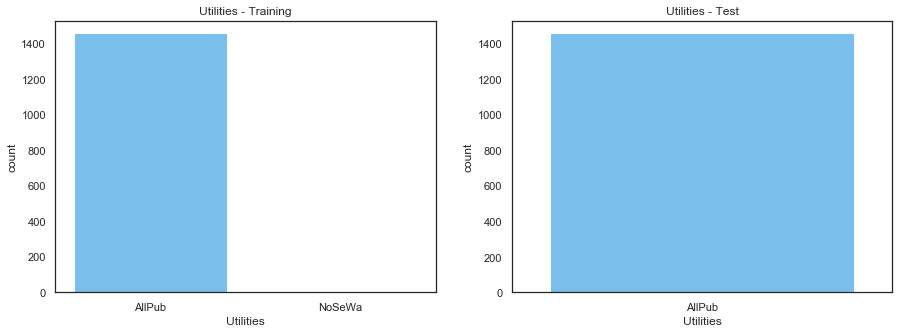

In [188]:
plt.subplots(figsize =(15, 5))

plt.subplot(1, 2, 1)
g = sns.countplot(x = "Utilities", data = train).set_title("Utilities - Training")

plt.subplot(1, 2, 2)
g = sns.countplot(x = "Utilities", data = test).set_title("Utilities - Test")

Можем отбросить этот столбец

In [189]:
all_data = all_data.drop(['Utilities'], axis=1)

all_data_na = all_data.isnull().sum()
print("Features with missing values: ", len(all_data_na.drop(all_data_na[all_data_na == 0].index)))

Features with missing values:  0


***

<a id='exploratory_data_analysis'></a>
# 4. 
## Exploratory Data Analysis

<a id='correlation_matrix'></a>
### 4.1 - Correlation matrix


Теперь, когда пропущенные значения и выбросы обработаны, я проанализирую каждый признак более подробно. Это даст понимание того, как подготовить этот признак для моделирования. Я проанализирую переменные, основанные на различных аспектах дома, доступных в наборе данных.



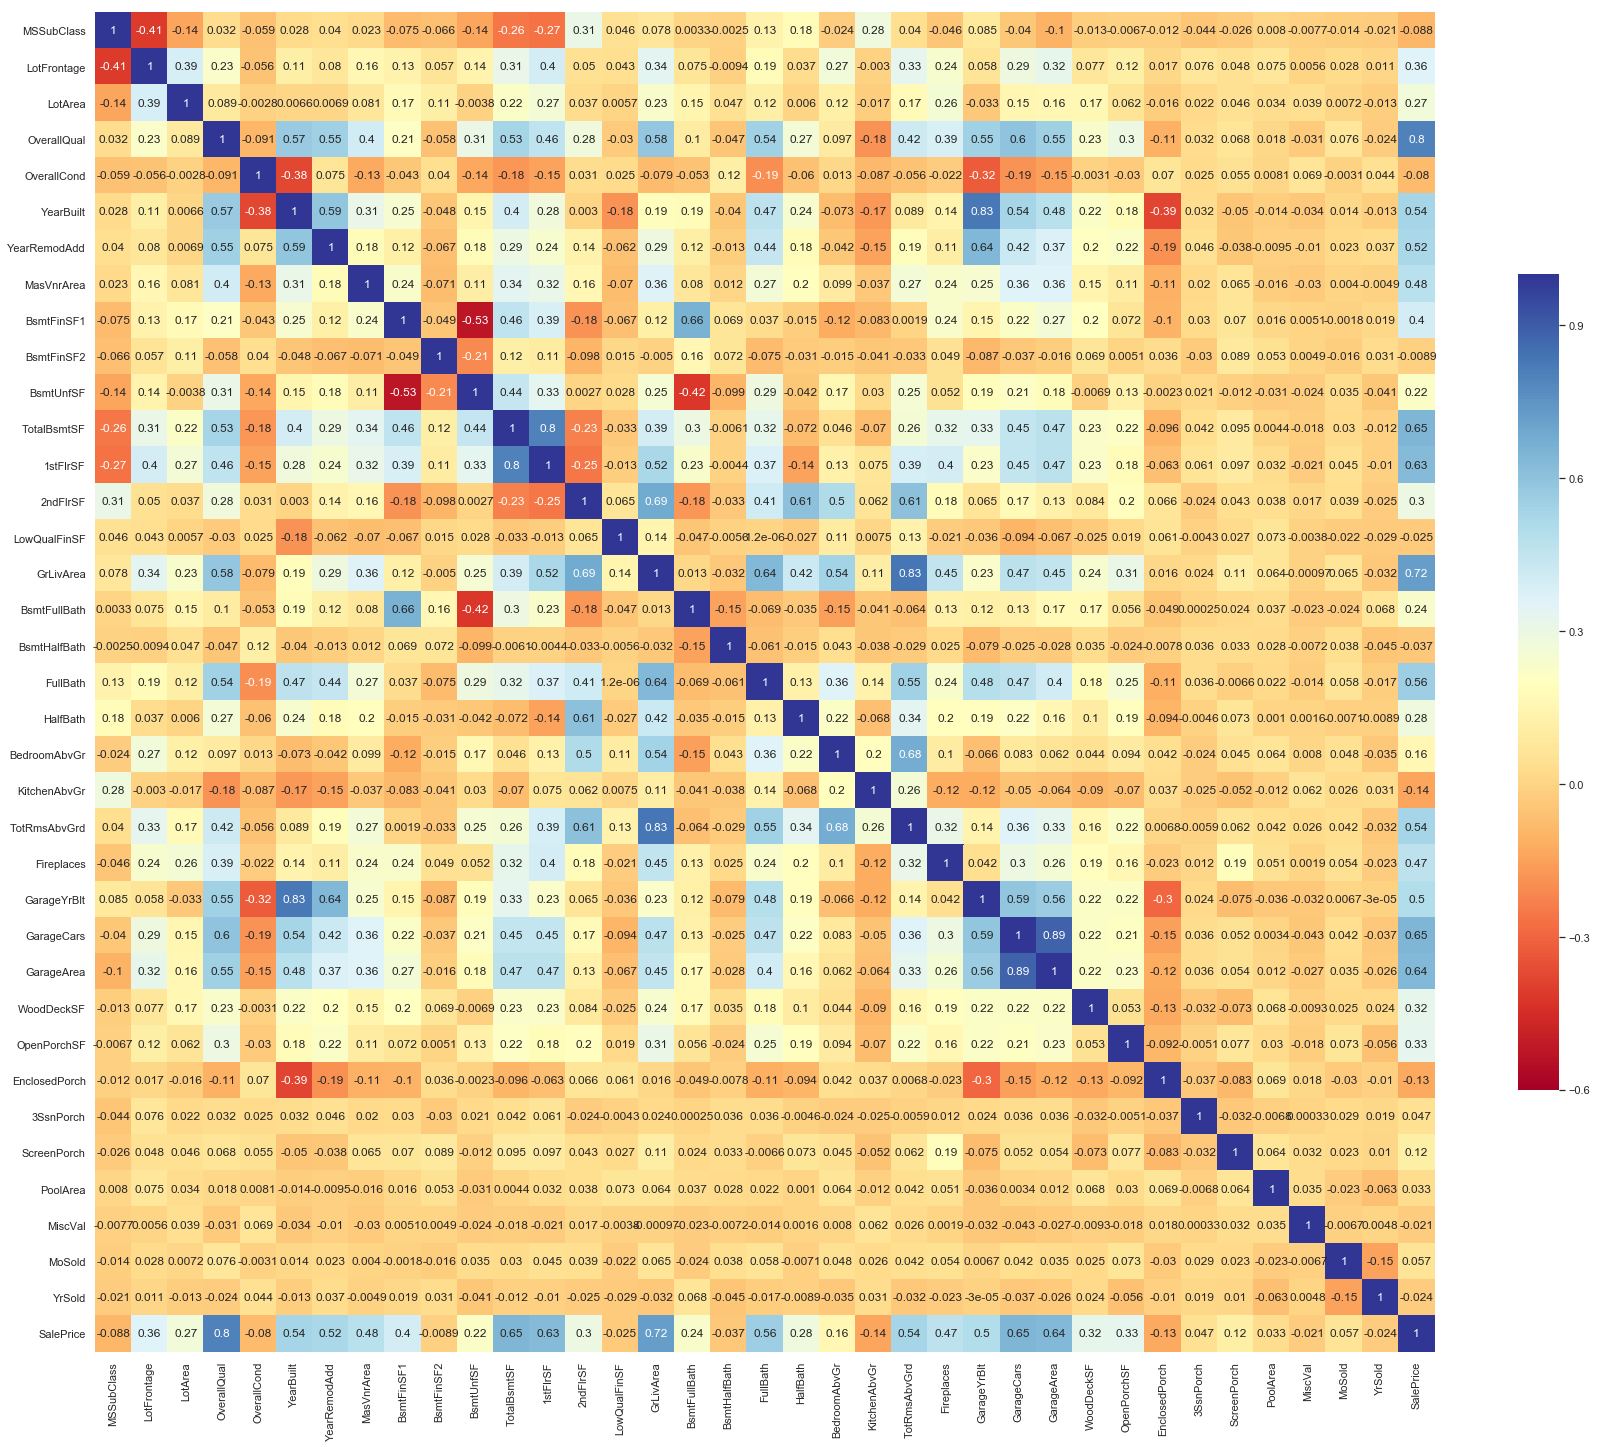

In [190]:
corr = train.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True);

- Используя эту корреляционную матрицу, я могу визуализировать сырые, сильно влияющие факторы на SalePrice.
- Я ищу их, потому что я буду создавать полиномиальные признаки из сильно коррелирующих признаков, чтобы попытаться охватить сложные нелинейные отношения в данных.

***

<a id='feature_engineering'></a>
### 4.2 - Feature engineering

<a id='polynomials'></a>
#### 4.2.1 - Polynomials

Наиболее распространенные отношения, которые мы можем представить между двумя переменными, это прямая или линейная зависимость. Это означает, что если мы увеличим предиктор (предиктор - признак с сильной предсказательной способностью) на 1 единицу, то ответ всегда увеличивается на X единиц. Однако не все данные имеют линейную зависимость, и поэтому вашей модели может потребоваться согласовать более сложные отношения в данных.

Но как вы подгоняете модель к данным со сложными отношениями, необъяснимыми линейной функцией? Существует множество методов подбора кривой, которые вы можете выбрать, чтобы помочь вам в этом.

- Наиболее распространенный способ подгонки кривых к данным состоит в том, чтобы включать полиномиальные выражения, такие как квадратные или кубические предикторы.
- Как правило, вы выбираете порядок модели по количеству изгибов, которые вам нужны в вашей линии. Каждое увеличение показателя вызывает еще один изгиб кривой кривой линии. Очень редко можно использовать больше, чем кубическое выражение.

- Если ваши данные ответа следуют шаблону, который спускается до нижней границы или поднимается до верхней границы, вы можете подогнать этот тип отношений, включив в модель reciprocal (обратную) (1 / x) одну или несколько переменных-предикторов.
    - Как правило, вы хотите использовать эту форму, когда размер эффекта для предикторной переменной уменьшается с увеличением ее значения.
- Поскольку градиент является функцией 1 / x, градиент становится более плоским с увеличением x. Для этого типа модели x никогда не может быть равен 0, потому что вы не можете делить на ноль.

* Итак ... теперь, когда вы вооружены этой информацией, важно знать, что для того, чтобы моделировать нелинейные, сложные отношения между переменными ответа и предиктора, мы можем создавать комбинации этих переменных с возрастающими или убывающими степенями*

- Поскольку в наборе данных такое большое количество переменных, создавать полиномы для каждого объекта излишне. Поэтому я посмотрю на топ-10, сопоставляющих объекты с целевой переменной из набора обучающих данных, и создам полиномы этих объектов или, что то же самое, новые комбинации, которые я создал из них.

Используя матрицу корреляции, главные факторы влияния, которые я буду использовать для создания полиномов:
1. **OverallQual**
2. **GrLivArea**
3. **GarageCars**
4. **GarageArea**
5. **TotalBsmtSF**
6. **1stFlrSF**
7. **FullBath**
8. **TotRmsAbvGrd**
9. **Fireplaces**
10. **MasVnrArea**
11. **BsmtFinSF1**
12. **LotFrontage**
13. **WoodDeckSF**
14. **OpenPorchSF**
15. **2ndFlrSF**

In [191]:
# Quadratic
all_data["OverallQual-2"] = all_data["OverallQual"] ** 2
all_data["GrLivArea-2"] = all_data["GrLivArea"] ** 2
all_data["GarageCars-2"] = all_data["GarageCars"] ** 2
all_data["GarageArea-2"] = all_data["GarageArea"] ** 2
all_data["TotalBsmtSF-2"] = all_data["TotalBsmtSF"] ** 2
all_data["1stFlrSF-2"] = all_data["1stFlrSF"] ** 2
all_data["FullBath-2"] = all_data["FullBath"] ** 2
all_data["TotRmsAbvGrd-2"] = all_data["TotRmsAbvGrd"] ** 2
all_data["Fireplaces-2"] = all_data["Fireplaces"] ** 2
all_data["MasVnrArea-2"] = all_data["MasVnrArea"] ** 2
all_data["BsmtFinSF1-2"] = all_data["BsmtFinSF1"] ** 2
all_data["LotFrontage-2"] = all_data["LotFrontage"] ** 2
all_data["WoodDeckSF-2"] = all_data["WoodDeckSF"] ** 2
all_data["OpenPorchSF-2"] = all_data["OpenPorchSF"] ** 2
all_data["2ndFlrSF-2"] = all_data["2ndFlrSF"] ** 2
print("Quadratics done!...")

# Cubic
all_data["OverallQual-3"] = all_data["OverallQual"] ** 3
all_data["GrLivArea-3"] = all_data["GrLivArea"] ** 3
all_data["GarageCars-3"] = all_data["GarageCars"] ** 3
all_data["GarageArea-3"] = all_data["GarageArea"] ** 3
all_data["TotalBsmtSF-3"] = all_data["TotalBsmtSF"] ** 3
all_data["1stFlrSF-3"] = all_data["1stFlrSF"] ** 3
all_data["FullBath-3"] = all_data["FullBath"] ** 3
all_data["TotRmsAbvGrd-3"] = all_data["TotRmsAbvGrd"] ** 3
all_data["Fireplaces-3"] = all_data["Fireplaces"] ** 3
all_data["MasVnrArea-3"] = all_data["MasVnrArea"] ** 3
all_data["BsmtFinSF1-3"] = all_data["BsmtFinSF1"] ** 3
all_data["LotFrontage-3"] = all_data["LotFrontage"] ** 3
all_data["WoodDeckSF-3"] = all_data["WoodDeckSF"] ** 3
all_data["OpenPorchSF-3"] = all_data["OpenPorchSF"] ** 3
all_data["2ndFlrSF-3"] = all_data["2ndFlrSF"] ** 3
print("Cubics done!...")

# Square Root
all_data["OverallQual-Sq"] = np.sqrt(all_data["OverallQual"])
all_data["GrLivArea-Sq"] = np.sqrt(all_data["GrLivArea"])
all_data["GarageCars-Sq"] = np.sqrt(all_data["GarageCars"])
all_data["GarageArea-Sq"] = np.sqrt(all_data["GarageArea"])
all_data["TotalBsmtSF-Sq"] = np.sqrt(all_data["TotalBsmtSF"])
all_data["1stFlrSF-Sq"] = np.sqrt(all_data["1stFlrSF"])
all_data["FullBath-Sq"] = np.sqrt(all_data["FullBath"])
all_data["TotRmsAbvGrd-Sq"] = np.sqrt(all_data["TotRmsAbvGrd"])
all_data["Fireplaces-Sq"] = np.sqrt(all_data["Fireplaces"])
all_data["MasVnrArea-Sq"] = np.sqrt(all_data["MasVnrArea"])
all_data["BsmtFinSF1-Sq"] = np.sqrt(all_data["BsmtFinSF1"])
all_data["LotFrontage-Sq"] = np.sqrt(all_data["LotFrontage"])
all_data["WoodDeckSF-Sq"] = np.sqrt(all_data["WoodDeckSF"])
all_data["OpenPorchSF-Sq"] = np.sqrt(all_data["OpenPorchSF"])
all_data["2ndFlrSF-Sq"] = np.sqrt(all_data["2ndFlrSF"])
print("Roots done!...")

Quadratics done!...
Cubics done!...
Roots done!...


<a id='interior'></a>
#### 4.2.2 - Interior

***BsmtQual***

- Оцениваем высоту подвала.

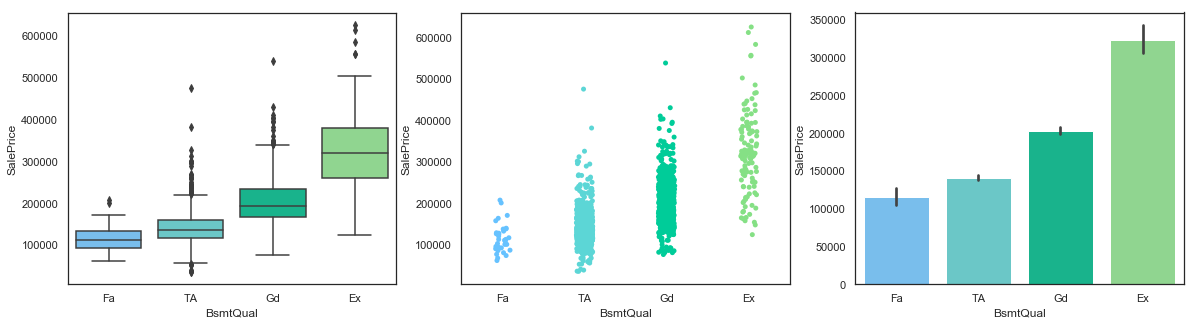

In [192]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtQual", y="SalePrice", data=train, order=['Fa', 'TA', 'Gd', 'Ex']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtQual", y="SalePrice", data=train, size = 5, jitter = True, order=['Fa', 'TA', 'Gd', 'Ex']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtQual", y="SalePrice", data=train, order=['Fa', 'TA', 'Gd', 'Ex']);

- На SalePrice явно влияет BsmtQual: чем выше качество, тем выше цена.
- Тем не менее, похоже, что большинство домов имеют подвальные помещения «хорошего» или «типичного» размера.
- Поскольку эта переменная является порядковой, то есть категории представляют разные уровни порядка, я заменю значения вручную.

In [193]:
all_data['BsmtQual'] = all_data['BsmtQual'].map({"None":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['BsmtQual'].unique()

array([3, 2, 4, 0, 1], dtype=int64)

***BsmtCond***
- Оценивает общее состояние фундамента.

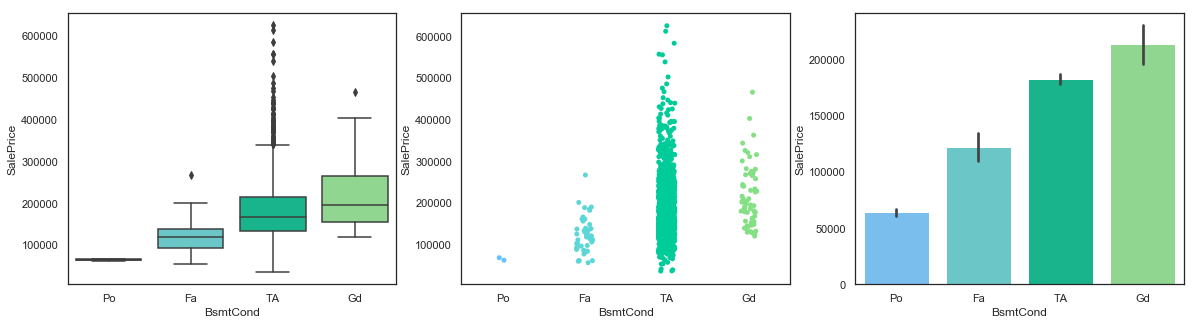

In [194]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtCond", y="SalePrice", data=train, order=['Po', 'Fa', 'TA', 'Gd']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtCond", y="SalePrice", data=train, size = 5, jitter = True, order=['Po', 'Fa', 'TA', 'Gd']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtCond", y="SalePrice", data=train, order=['Po', 'Fa', 'TA', 'Gd']);

- По мере улучшения состояния подвала, SalePrice также увеличивается.
- Тем не менее, мы видим очень высокие значения SalePrice для домов с «типичными» условиями подвала. Возможно, это говорит о том, что, хотя эти две переменные коррелируют положительно, BsmtCond может не оказать существенного влияния на SalePrice.
- Мы также видим наибольшее количество домов, попадающих в категорию «ТА».
- Поскольку эта переменная является порядковой, я заменю значения вручную.

In [195]:
all_data['BsmtCond'] = all_data['BsmtCond'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['BsmtCond'].unique()

array([3, 4, 0, 2, 1], dtype=int64)

***BsmtExposure***
- Относится к проходу или стенам на уровне сада

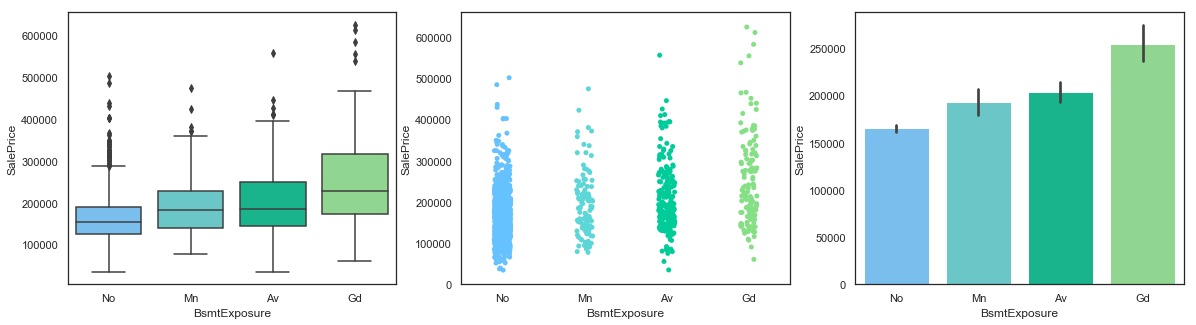

In [196]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtExposure", y="SalePrice", data=train, order=['No', 'Mn', 'Av', 'Gd']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtExposure", y="SalePrice", data=train, size = 5, jitter = True, order=['No', 'Mn', 'Av', 'Gd']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtExposure", y="SalePrice", data=train, order=['No', 'Mn', 'Av', 'Gd']);

- По мере того, как увеличивается количество экспозиции, увеличивается и типичная SalePrice. Интересно, что средняя разница SalePrice между категориями здесь довольно низкая, что говорит мне о том, что некоторые дома продаются по очень высоким ценам, даже без каких-либо воздействий.
- Из этого анализа я бы сказал, что он положительно коррелирует с SalePrice, но он не имеет большого влияния.
- Поскольку эта переменная является порядковой, я заменю значения вручную.

In [197]:
all_data['BsmtExposure'] = all_data['BsmtExposure'].map({"None":0, "No":1, "Mn":2, "Av":3, "Gd":4})
all_data['BsmtExposure'].unique()

array([1, 4, 2, 3, 0], dtype=int64)

***BsmtFinType1***
- Рейтинг отделки подвального помещения

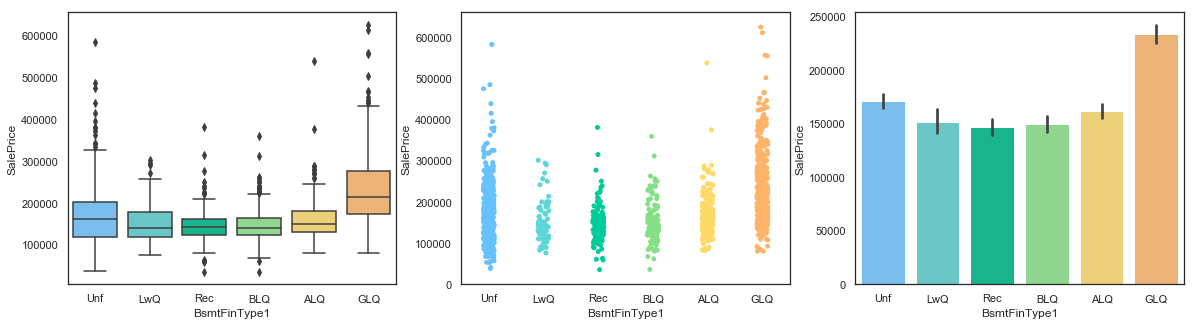

In [198]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtFinType1", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtFinType1", y="SalePrice", data=train, size = 5, jitter = True, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtFinType1", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

- Это очень интересно, кажется, что дома с подвалом без хорошей отделки в среднем продаются за большие деньги, чем дома со средним рейтингом
- Тем не менее, дома с хорошей отделкой в подвале по-прежнему требуют больше денег
- Это обычный признак однако, как вы можете видеть, эта последовательность не обязательно вызывает повышение SalePrice. Создав порядковую переменную, мы предположили, что по мере увеличения порядка объекта целевая переменная также будет. Мы видим, что это не так. Поэтому я создам фиктивные dummy переменные из этого признака

In [199]:
all_data = pd.get_dummies(all_data, columns = ["BsmtFinType1"], prefix="BsmtFinType1")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFinSF1  BsmtFinSF2        ...        WoodDeckSF-Sq  \
0             1       706.0         0.0        ...             0.000000   
1             4       978.0         0.0        ...            17.262677   
2             2       486.0         0.0        ...             0.000000   

   OpenPorchSF-Sq  2ndFlrSF-Sq  BsmtFinType1_ALQ  BsmtFinType1_BLQ  \
0        7.810250    29.223278                 0                 0   
1        0.000000     0.000000                 1                 0   
2        6.480741    29.427878                 0                 0   

  BsmtFinType1_GLQ BsmtFinType1_LwQ BsmtFinType1_None BsmtFinType1_Rec  \
0                1                0                 0                0   
1                0                0                 0                0   
2                1                0                 0                0   

   BsmtFinType1_Unf  
0                 0  
1                 0  
2                 0  

[3 rows x 129 columns]

***BsmtFinSF1***
- Тип 1 отделанных квадратных футов

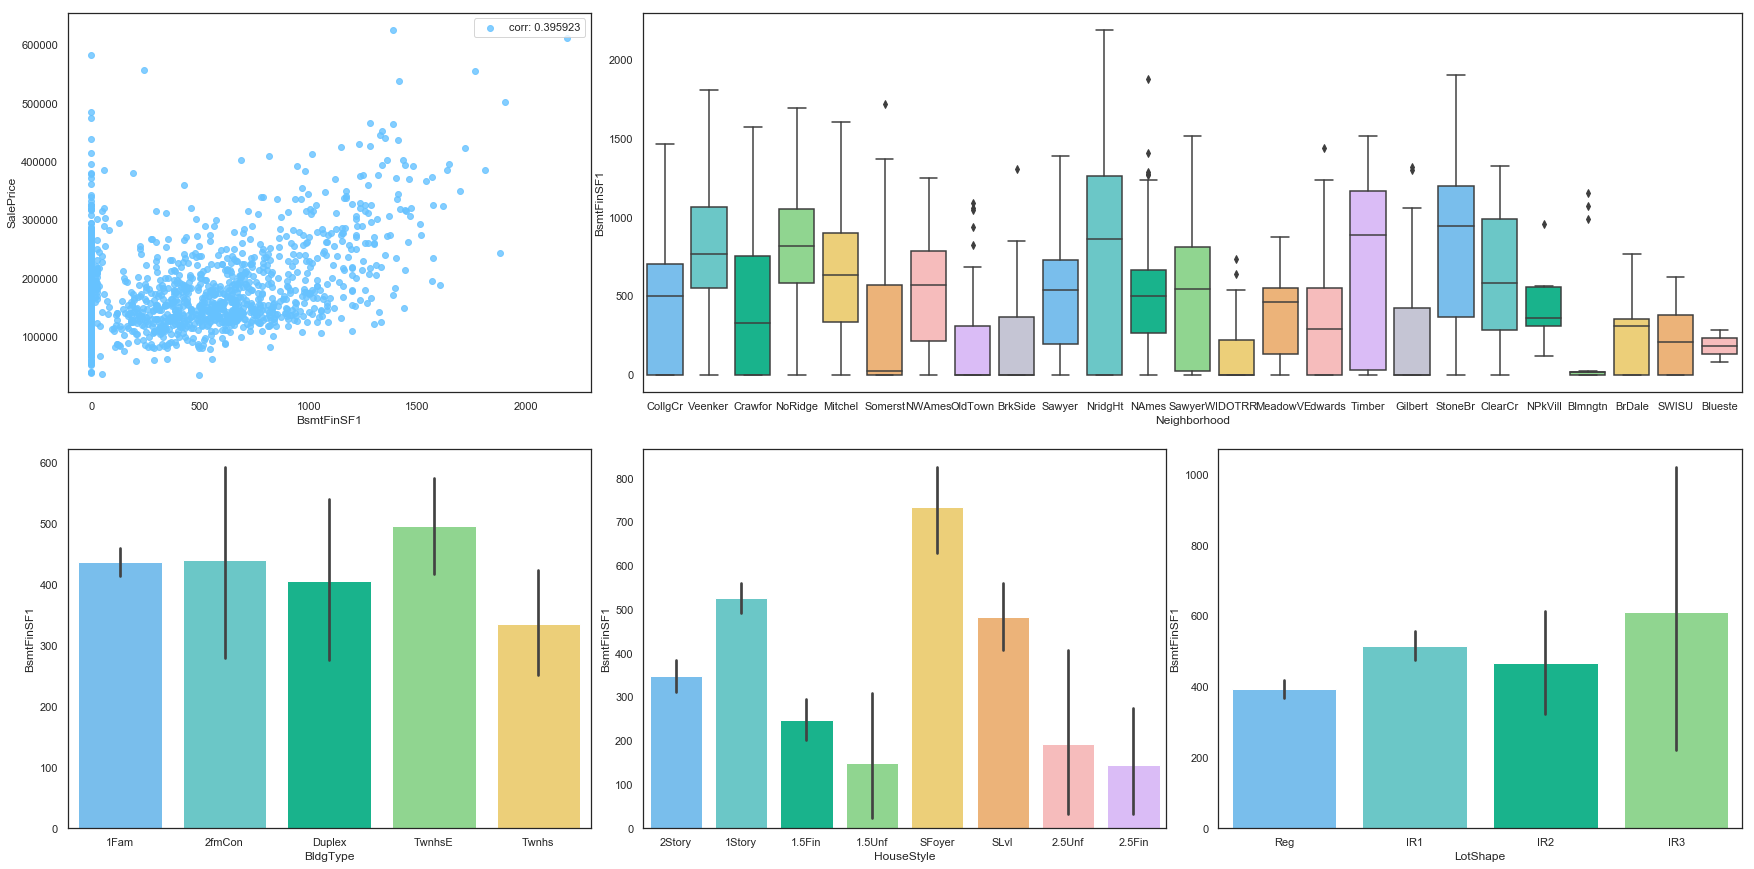

In [200]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtFinSF1'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtFinSF1'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtFinSF1", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtFinSF1", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtFinSF1", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtFinSF1", data=train, palette = mycols);

- Этот признак имеет положительную корреляцию с SalePrice, и разброс точек данных довольно велик.
- Также ясно, что локальная область (район) и стиль застройки (BldgType, HouseStyle и LotShape) по-разному влияют на этот признак.
- Поскольку это непрерывный числовой признак, я разделю его на несколько категорий и создам фиктивные dummy признаки.

In [201]:
all_data['BsmtFinSF1_Band'] = pd.cut(all_data['BsmtFinSF1'], 4)
all_data['BsmtFinSF1_Band'].unique()

[(-4.01, 1002.5], (1002.5, 2005.0], (2005.0, 3007.5], (3007.5, 4010.0]]
Categories (4, interval[float64]): [(-4.01, 1002.5] < (1002.5, 2005.0] < (2005.0, 3007.5] < (3007.5, 4010.0]]

In [202]:
all_data.loc[all_data['BsmtFinSF1']<=1002.5, 'BsmtFinSF1'] = 1
all_data.loc[(all_data['BsmtFinSF1']>1002.5) & (all_data['BsmtFinSF1']<=2005), 'BsmtFinSF1'] = 2
all_data.loc[(all_data['BsmtFinSF1']>2005) & (all_data['BsmtFinSF1']<=3007.5), 'BsmtFinSF1'] = 3
all_data.loc[all_data['BsmtFinSF1']>3007.5, 'BsmtFinSF1'] = 4
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].astype(int)

all_data.drop('BsmtFinSF1_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["BsmtFinSF1"], prefix="BsmtFinSF1")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFinSF2 BsmtFinType2     ...       BsmtFinType1_BLQ  \
0             1         0.0          Unf     ...                      0   
1             4         0.0          Unf     ...                      0   
2             2         0.0          Unf     ...                      0   

   BsmtFinType1_GLQ  BsmtFinType1_LwQ  BsmtFinType1_None BsmtFinType1_Rec  \
0                 1                 0                  0                0   
1                 0                 0                  0                0   
2                 1                 0                  0                0   

  BsmtFinType1_Unf BsmtFinSF1_1 BsmtFinSF1_2  BsmtFinSF1_3 BsmtFinSF1_4  
0                0            1            0             0            0  
1                0            1            0             0            0  
2                0            1            0             0            0  

[3 rows x 132 columns]

***BsmtFinType2***
- Рейтинг подвального отделанного этажа (если несколько типов)

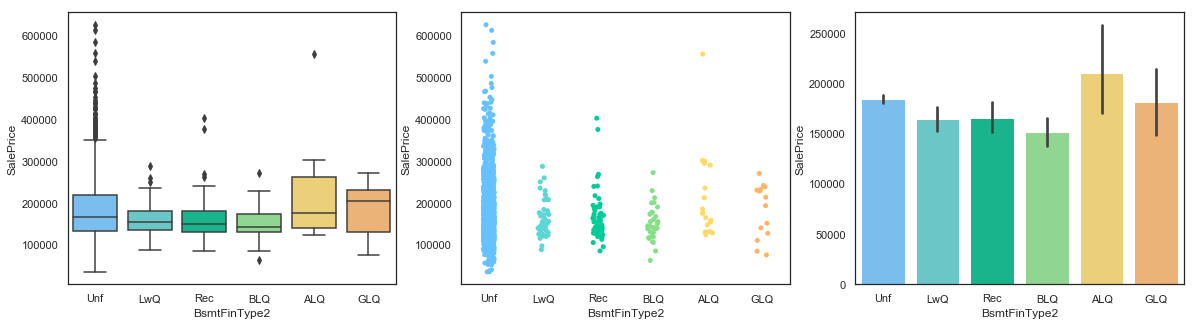

In [203]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtFinType2", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtFinType2", y="SalePrice", data=train, size = 5, jitter = True, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtFinType2", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

- Кажется, что есть много домов с неотделаными вторыми подвалами, и это может вызвать смещение с точки зрения того, что SalePrice относительно высока для них
- Похоже, что для каждой из других категорий есть только несколько значений, причем наивысшая средняя SalePrice приходится на вторую лучшую категорию.
- Хотя это и предназначено для обычного признака, мы видим, что SalePrice не обязательно увеличивается с ростом последовательности. Следовательно, здесь я приведу фиктивные переменные.

In [204]:
all_data = pd.get_dummies(all_data, columns = ["BsmtFinType2"], prefix="BsmtFinType2")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFinSF2  BsmtFullBath       ...         BsmtFinSF1_2  \
0             1         0.0           1.0       ...                    0   
1             4         0.0           0.0       ...                    0   
2             2         0.0           1.0       ...                    0   

   BsmtFinSF1_3  BsmtFinSF1_4 BsmtFinType2_ALQ BsmtFinType2_BLQ  \
0             0             0                0                0   
1             0             0                0                0   
2             0             0                0                0   

  BsmtFinType2_GLQ BsmtFinType2_LwQ  BsmtFinType2_None BsmtFinType2_Rec  \
0                0                0                  0                0   
1                0                0                  0                0   
2                0                0                  0                0   

  BsmtFinType2_Unf  
0                1  
1                1  
2                1  

[3 rows x 138 columns]

***BsmtFinSF2***
- Тип 2 отделанный квадратный фут

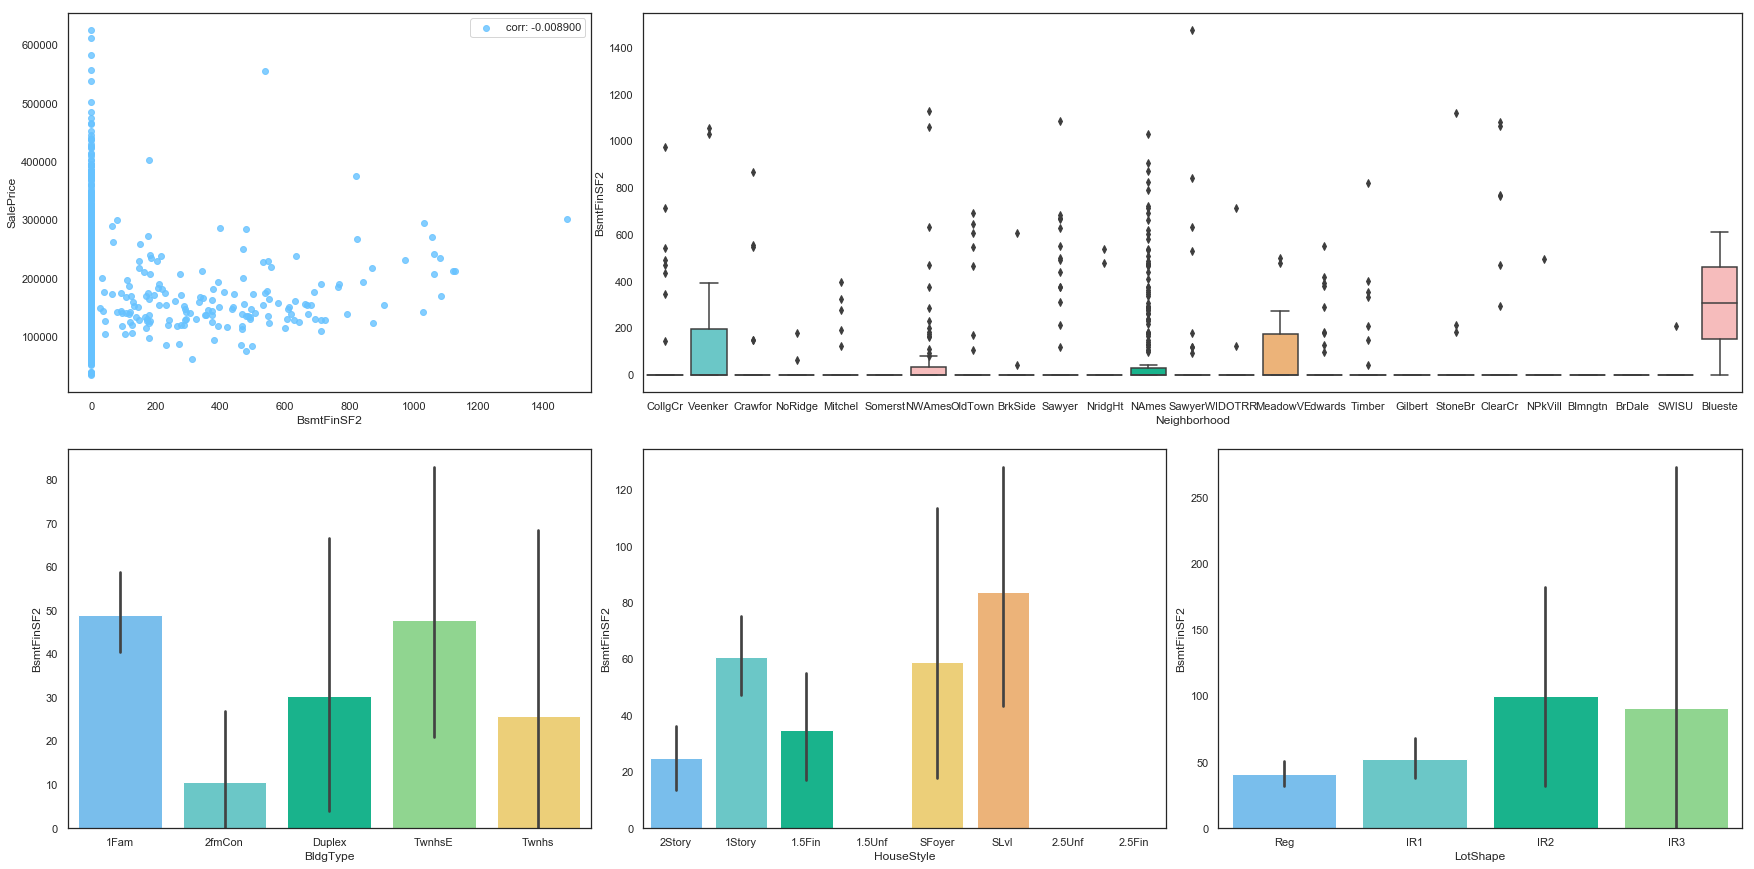

In [205]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtFinSF2'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtFinSF2'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtFinSF2", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtFinSF2", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtFinSF2", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtFinSF2", data=train, palette = mycols);

- Существует большое количество точек данных этого признака = 0. За пределами этого нет существенной корреляции с SalePrice и большим разбросом значений.
- Следовательно, я заменю этот признак флагом, всё, кроме 0 заменю на 1

In [206]:
all_data['BsmtFinSf2_Flag'] = all_data['BsmtFinSF2'].map(lambda x:0 if x==0 else 1)
all_data.drop('BsmtFinSF2', axis=1, inplace=True)

***BsmtUnfSF***
- Неотделанные квадратные футы подвального помещения

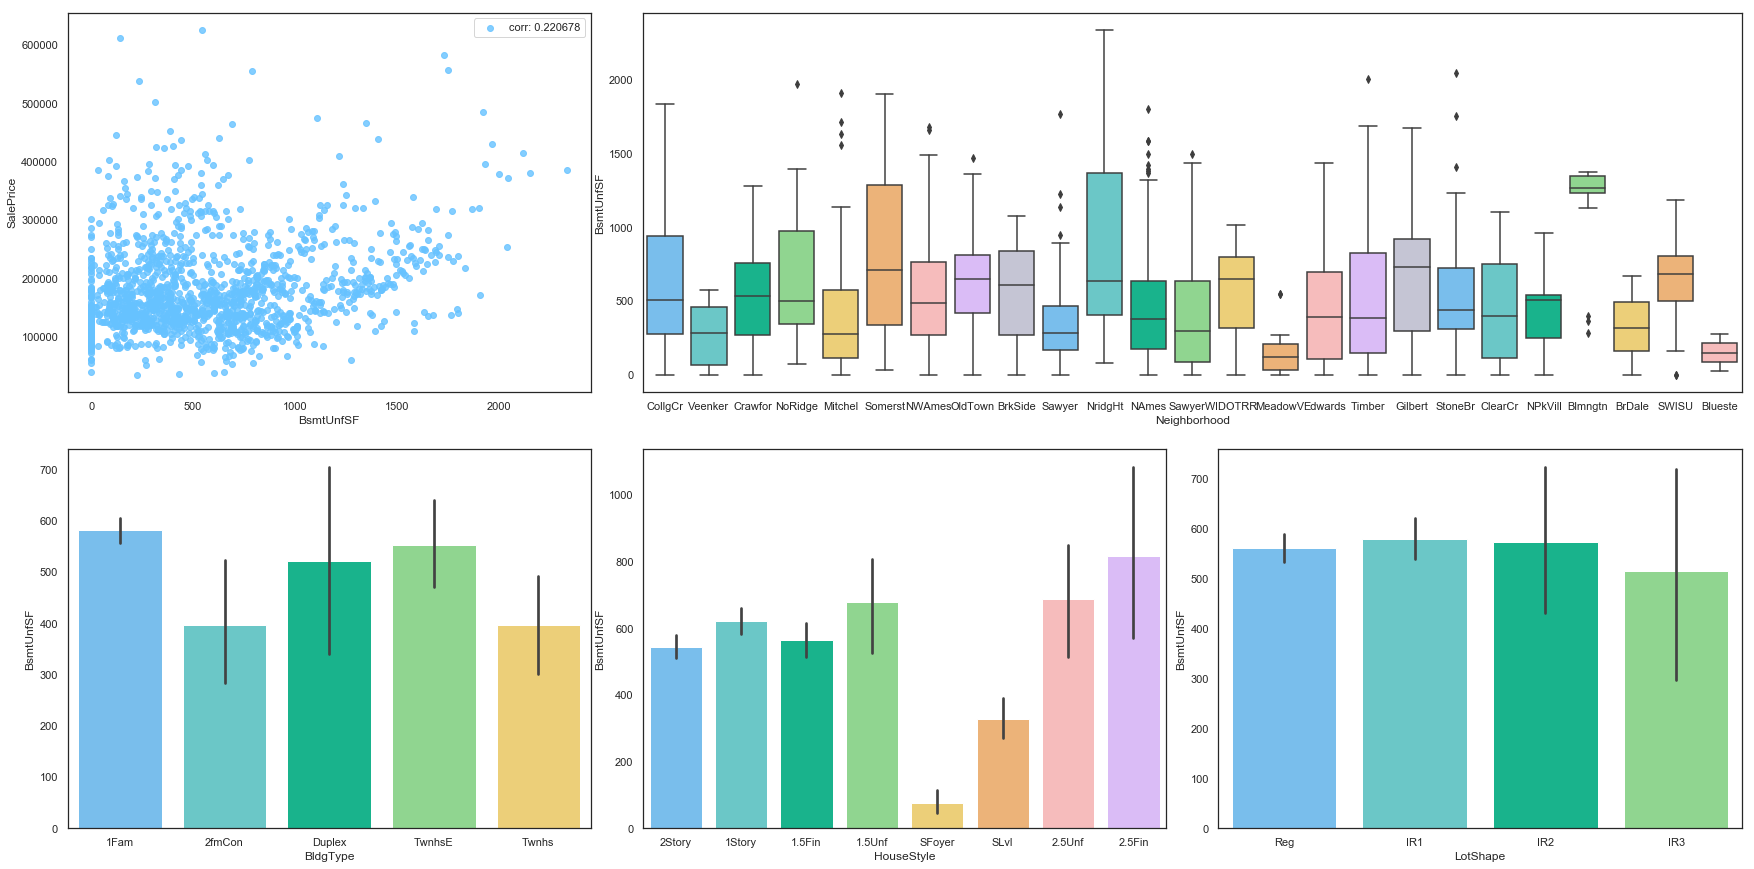

In [207]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtUnfSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtUnfSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtUnfSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtUnfSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtUnfSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtUnfSF", data=train, palette = mycols);

- Этот признак имеет существенную положительную корреляцию с SalePrice, с небольшой долей точек данных, имеющих значение 0. Это говорит мне о том, что у большинства домов будет некоторое количество неотделанных квадратных футов в подвале, и это фактически положительно влияет на SalePrice.
- Количество неотделанных квадратных футов также широко варьируется в зависимости от местоположения и стиля.
- В то время как средние неотделанных квадратные футы в подвале довольно одинаковы для разных форм участков.
- Так как это непрерывный числовой признак со значительной корреляцией, я сделаю биннинг (Исходные значения данных, попадающие в заданный небольшой интервал (ячейка), заменяются значением, представляющим этот интервал, часто центральным значением. Это форма квантования), создам фиктивные переменные.

In [208]:
all_data['BsmtUnfSF_Band'] = pd.cut(all_data['BsmtUnfSF'], 3)
all_data['BsmtUnfSF_Band'].unique()

[(-2.336, 778.667], (778.667, 1557.333], (1557.333, 2336.0]]
Categories (3, interval[float64]): [(-2.336, 778.667] < (778.667, 1557.333] < (1557.333, 2336.0]]

In [209]:
all_data.loc[all_data['BsmtUnfSF']<=778.667, 'BsmtUnfSF'] = 1
all_data.loc[(all_data['BsmtUnfSF']>778.667) & (all_data['BsmtUnfSF']<=1557.333), 'BsmtUnfSF'] = 2
all_data.loc[all_data['BsmtUnfSF']>1557.333, 'BsmtUnfSF'] = 3
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].astype(int)

all_data.drop('BsmtUnfSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["BsmtUnfSF"], prefix="BsmtUnfSF")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFullBath  BsmtHalfBath     ...      BsmtFinType2_BLQ  \
0             1           1.0           0.0     ...                     0   
1             4           0.0           1.0     ...                     0   
2             2           1.0           0.0     ...                     0   

  BsmtFinType2_GLQ BsmtFinType2_LwQ BsmtFinType2_None BsmtFinType2_Rec  \
0                0                0                 0                0   
1                0                0                 0                0   
2                0                0                 0                0   

   BsmtFinType2_Unf BsmtFinSf2_Flag BsmtUnfSF_1 BsmtUnfSF_2 BsmtUnfSF_3  
0                 1               0           1           0           0  
1                 1               0           1           0           0  
2                 1               0           1           0           0  

[3 rows x 140 columns]

***TotalBsmtSF***
- Общая площадь подвальных площадей.

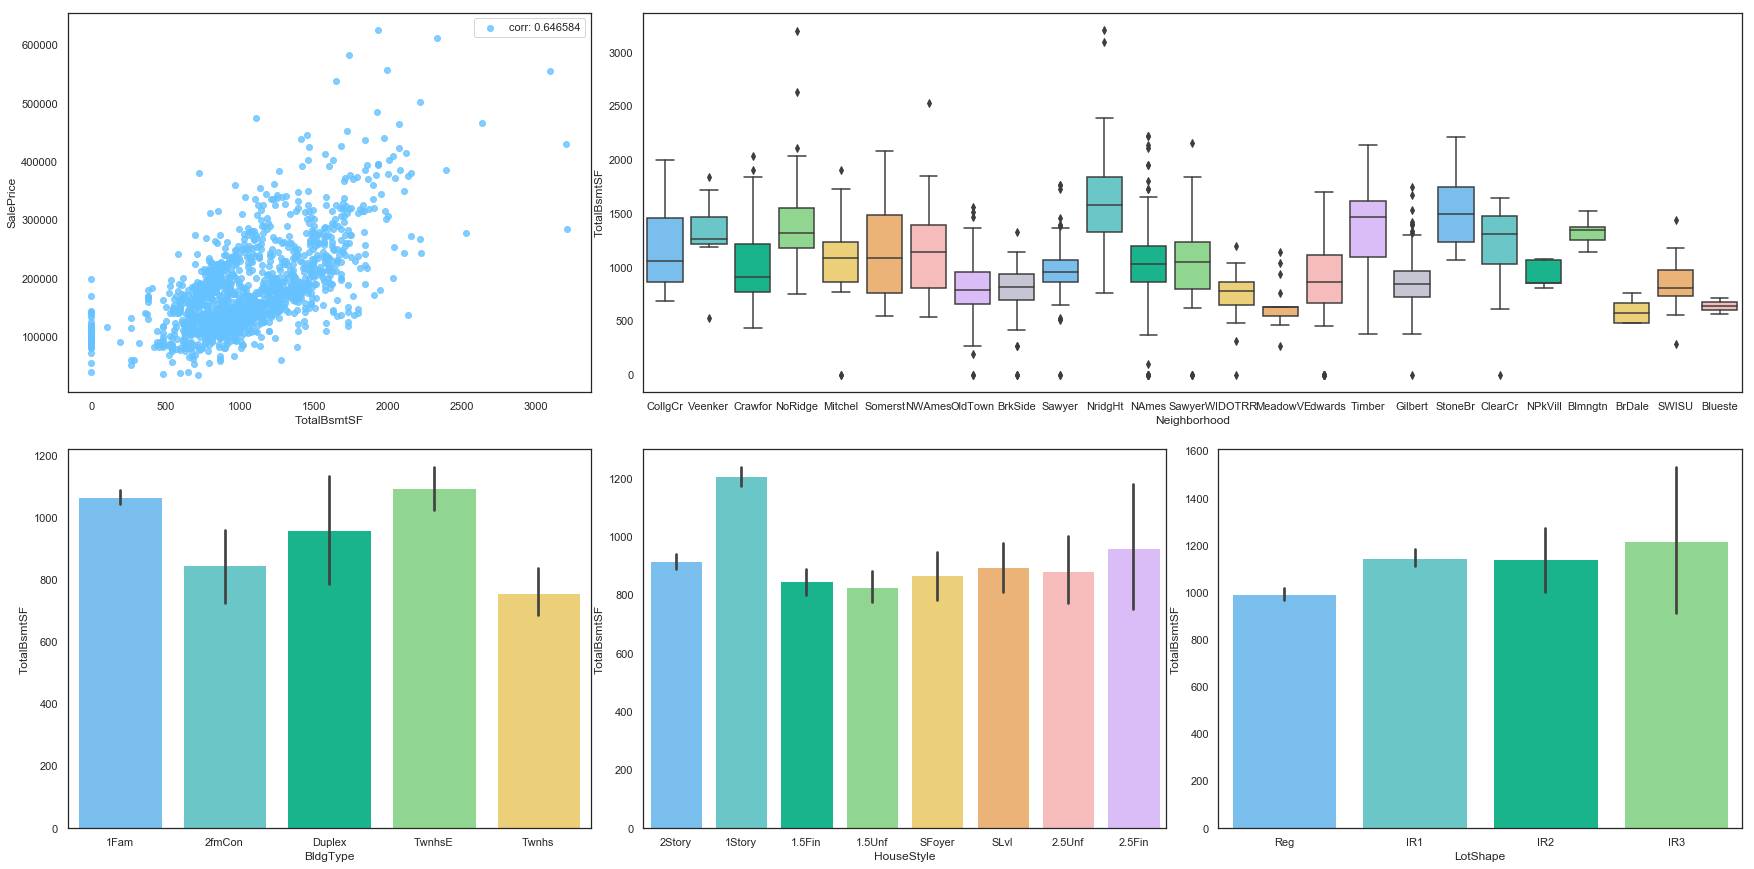

In [210]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['TotalBsmtSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['TotalBsmtSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="TotalBsmtSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="TotalBsmtSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="TotalBsmtSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="TotalBsmtSF", data=train, palette = mycols);

- Это будет очень важной переменной в моем анализе из-за такой высокой корреляции с Saleprice.
- Мы видим, что он широко варьируется в зависимости от местоположения, однако средний размер подвала имеет меньшую дисперсию в зависимости от типа, стиля и формы участка.
- Из-за того, что это непрерывный числовой признак, а также очень важный признак при описании SalePrice, я полагаю, что он может иметь большую ценность. Следовательно, я создам некоторые привязки binnings и фиктивные переменные.

In [211]:
all_data['TotalBsmtSF_Band'] = pd.cut(all_data['TotalBsmtSF'], 10)
all_data['TotalBsmtSF_Band'].unique()

[(509.5, 1019.0], (1019.0, 1528.5], (1528.5, 2038.0], (-5.095, 509.5], (2038.0, 2547.5], (3057.0, 3566.5], (2547.5, 3057.0], (4585.5, 5095.0]]
Categories (8, interval[float64]): [(-5.095, 509.5] < (509.5, 1019.0] < (1019.0, 1528.5] < (1528.5, 2038.0] < (2038.0, 2547.5] < (2547.5, 3057.0] < (3057.0, 3566.5] < (4585.5, 5095.0]]

In [212]:
all_data.loc[all_data['TotalBsmtSF']<=509.5, 'TotalBsmtSF'] = 1
all_data.loc[(all_data['TotalBsmtSF']>509.5) & (all_data['TotalBsmtSF']<=1019), 'TotalBsmtSF'] = 2
all_data.loc[(all_data['TotalBsmtSF']>1019) & (all_data['TotalBsmtSF']<=1528.5), 'TotalBsmtSF'] = 3
all_data.loc[(all_data['TotalBsmtSF']>1528.5) & (all_data['TotalBsmtSF']<=2038), 'TotalBsmtSF'] = 4
all_data.loc[(all_data['TotalBsmtSF']>2038) & (all_data['TotalBsmtSF']<=2547.5), 'TotalBsmtSF'] = 5
all_data.loc[(all_data['TotalBsmtSF']>2547.5) & (all_data['TotalBsmtSF']<=3057), 'TotalBsmtSF'] = 6
all_data.loc[(all_data['TotalBsmtSF']>3057) & (all_data['TotalBsmtSF']<=3566.5), 'TotalBsmtSF'] = 7
all_data.loc[all_data['TotalBsmtSF']>3566.5, 'TotalBsmtSF'] = 8
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].astype(int)

all_data.drop('TotalBsmtSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["TotalBsmtSF"], prefix="TotalBsmtSF")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFullBath  BsmtHalfBath      ...       BsmtUnfSF_2  \
0             1           1.0           0.0      ...                 0   
1             4           0.0           1.0      ...                 0   
2             2           1.0           0.0      ...                 0   

  BsmtUnfSF_3 TotalBsmtSF_1 TotalBsmtSF_2 TotalBsmtSF_3  TotalBsmtSF_4  \
0           0             0             1             0              0   
1           0             0             0             1              0   
2           0             0             1             0              0   

  TotalBsmtSF_5 TotalBsmtSF_6 TotalBsmtSF_7 TotalBsmtSF_8  
0             0             0             0             0  
1             0             0             0             0  
2             0             0             0             0  

[3 rows x 147 columns]

***1stFlrSF***
- Первый этаж квадратный фут.

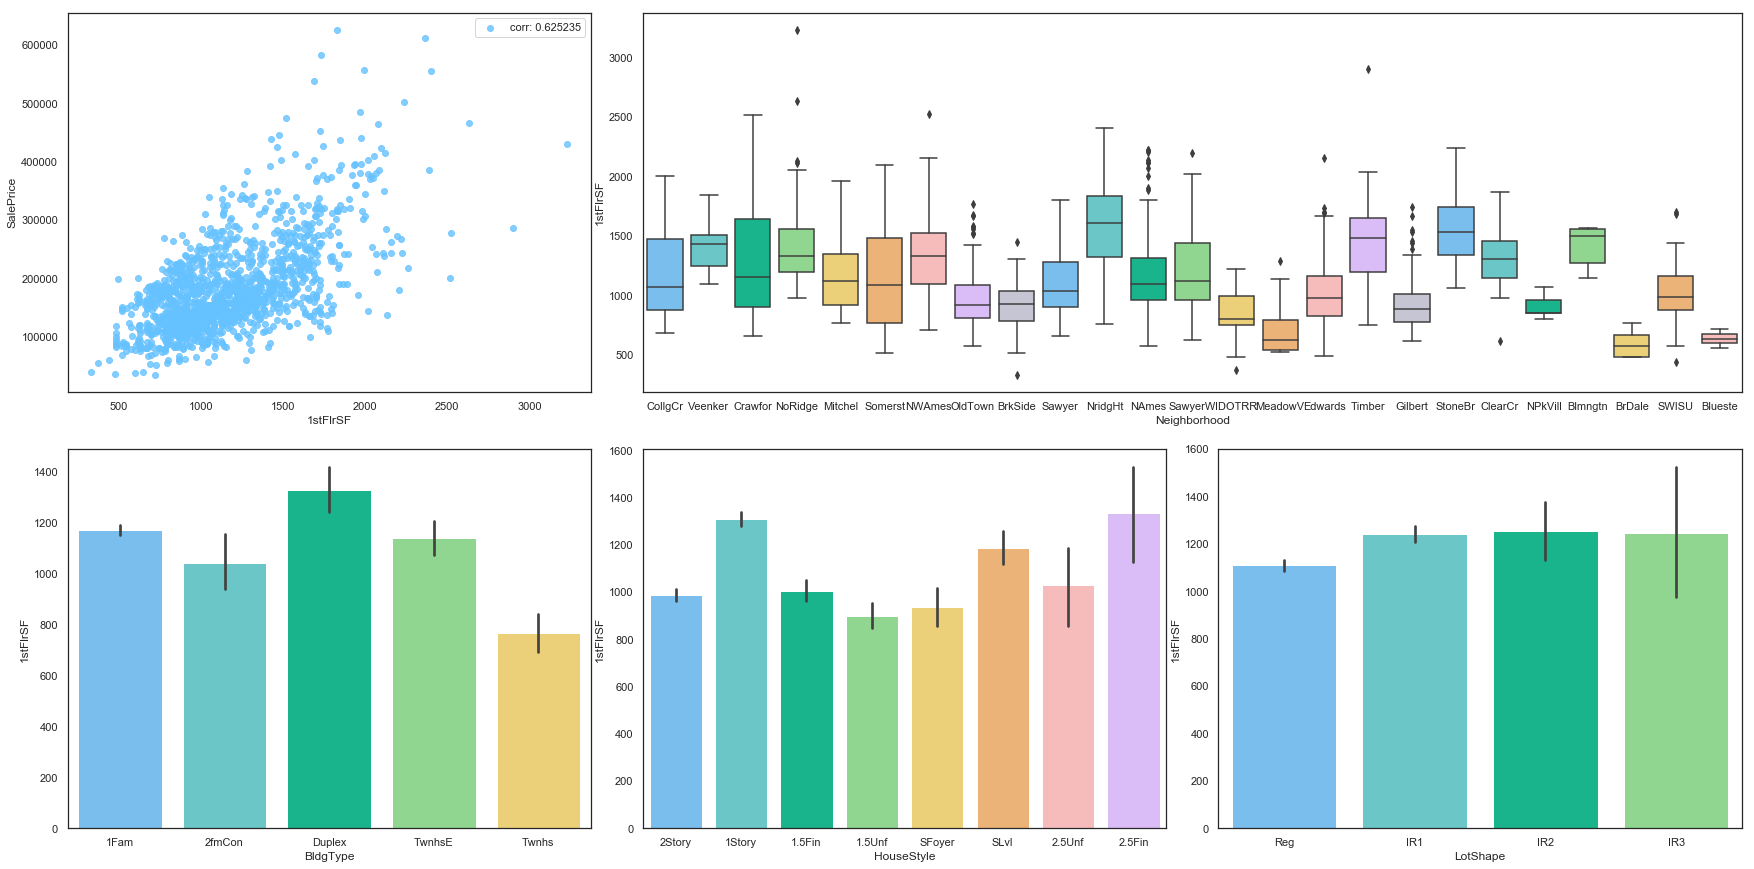

In [213]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['1stFlrSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['1stFlrSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="1stFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="1stFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="1stFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="1stFlrSF", data=train, palette = mycols);

- Очевидно, что это показывает очень высокую положительную корреляцию с SalePrice, это будет важной переменной при моделировании.
- Еще раз, этот признак сильно варьируется в зависимости от района, и его размер зависит от типа здания и стиля.
- Этот признак не сильно зависит от размера лота.
- Так как это непрерывный числовой признак, я создам привязки и фиктивные переменные.

In [214]:
all_data['1stFlrSF_Band'] = pd.cut(all_data['1stFlrSF'], 6)
all_data['1stFlrSF_Band'].unique()

[(329.239, 1127.5], (1127.5, 1921.0], (1921.0, 2714.5], (2714.5, 3508.0], (3508.0, 4301.5], (4301.5, 5095.0]]
Categories (6, interval[float64]): [(329.239, 1127.5] < (1127.5, 1921.0] < (1921.0, 2714.5] < (2714.5, 3508.0] < (3508.0, 4301.5] < (4301.5, 5095.0]]

In [215]:
all_data.loc[all_data['1stFlrSF']<=1127.5, '1stFlrSF'] = 1
all_data.loc[(all_data['1stFlrSF']>1127.5) & (all_data['1stFlrSF']<=1921), '1stFlrSF'] = 2
all_data.loc[(all_data['1stFlrSF']>1921) & (all_data['1stFlrSF']<=2714.5), '1stFlrSF'] = 3
all_data.loc[(all_data['1stFlrSF']>2714.5) & (all_data['1stFlrSF']<=3508), '1stFlrSF'] = 4
all_data.loc[(all_data['1stFlrSF']>3508) & (all_data['1stFlrSF']<=4301.5), '1stFlrSF'] = 5
all_data.loc[all_data['1stFlrSF']>4301.5, '1stFlrSF'] = 6
all_data['1stFlrSF'] = all_data['1stFlrSF'].astype(int)

all_data.drop('1stFlrSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["1stFlrSF"], prefix="1stFlrSF")
all_data.head(3)

2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  \
0       854          0  None             3     1Fam         3             1   
1         0          0  None             3     1Fam         3             4   
2       866          0  None             3     1Fam         3             2   

   BsmtFullBath  BsmtHalfBath  BsmtQual    ...     TotalBsmtSF_5  \
0           1.0           0.0         3    ...                 0   
1           0.0           1.0         3    ...                 0   
2           1.0           0.0         3    ...                 0   

  TotalBsmtSF_6 TotalBsmtSF_7 TotalBsmtSF_8  1stFlrSF_1 1stFlrSF_2 1stFlrSF_3  \
0             0             0             0           1          0          0   
1             0             0             0           0          1          0   
2             0             0             0           1          0          0   

  1stFlrSF_4 1stFlrSF_5 1stFlrSF_6  
0          0          0          0  
1          0          0          0  
2          0          0          0  

[3 rows x 152 columns]

***2ndFlrSF***
- Второй эта квадратный фут

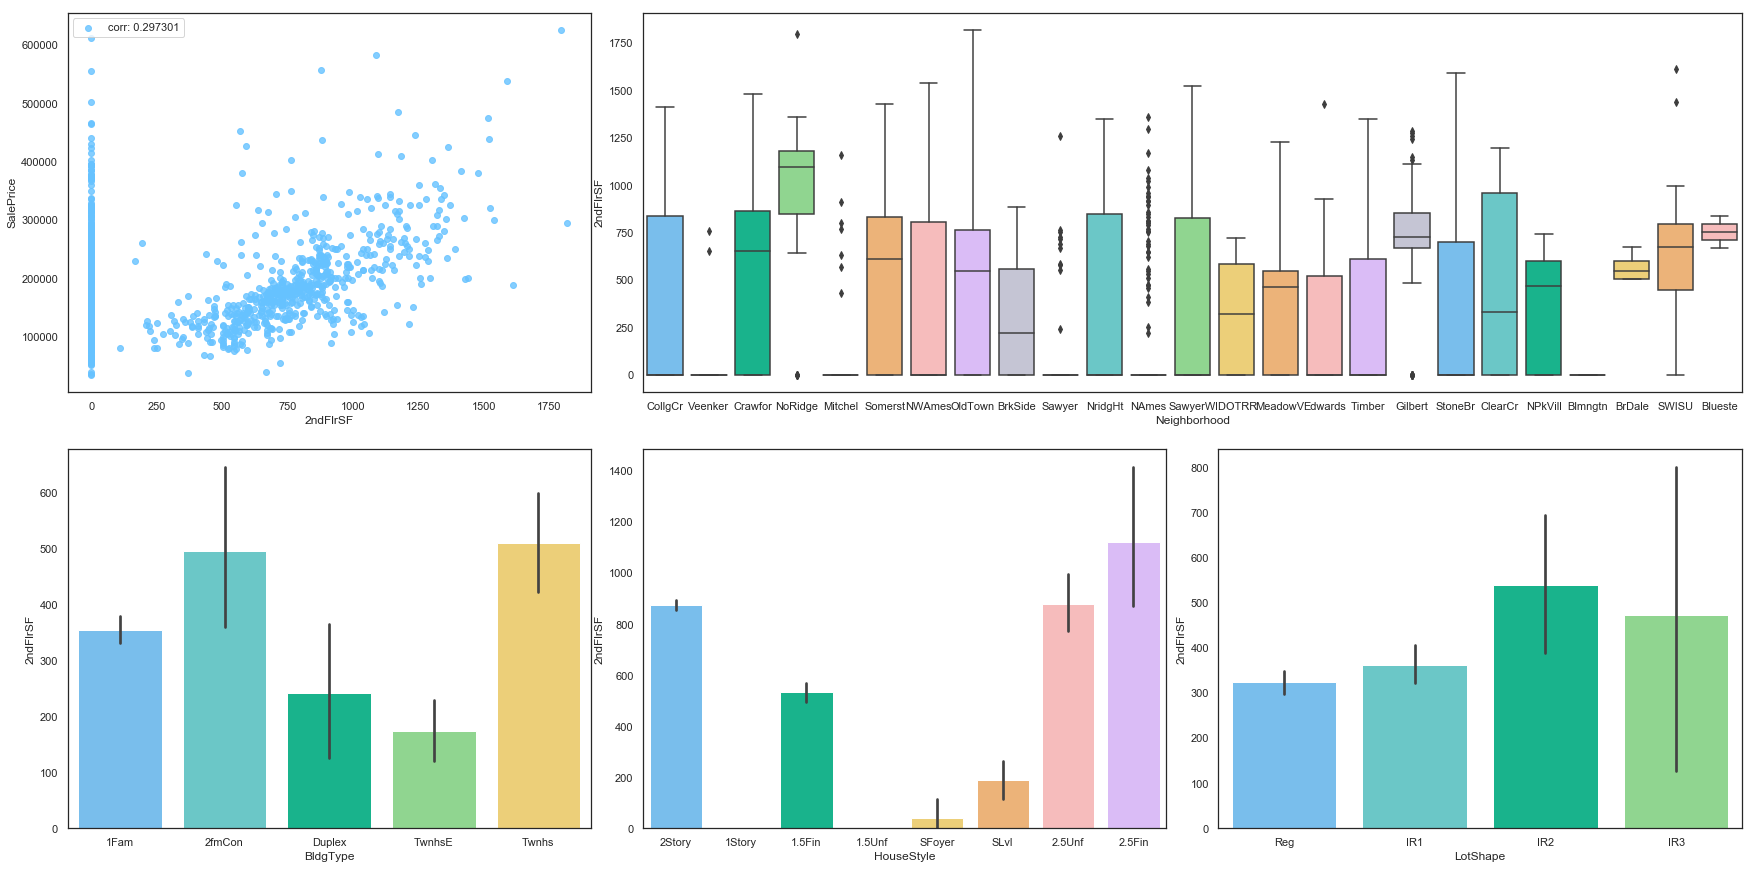

In [216]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['2ndFlrSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['2ndFlrSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="2ndFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="2ndFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="2ndFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="2ndFlrSF", data=train, palette = mycols);

- Интересно, что мы видим очень позитивно коррелированные отношения с SalePrice, однако мы также видим значительное количество домов со значением = 0.
- Это объясняется другими визуальными изображениями, показывающими, что в некоторых стилях домов, возможно, нет второго этажа, следовательно, они не могут иметь значение для этой переменной, например, в домах «1Story».
- Мы также видим высокую зависимость и различия между районами, типами зданий и размерами участков.
- Очевидно, что все переменные, связанные с «пространством», важны в этом анализе. Так как эта переменная представляет собой непрерывную числовую переменную, я сделаю привязку и создам фиктивные переменные.

In [217]:
all_data['2ndFlrSF_Band'] = pd.cut(all_data['2ndFlrSF'], 6)
all_data['2ndFlrSF_Band'].unique()

[(620.667, 931.0], (-1.862, 310.333], (931.0, 1241.333], (310.333, 620.667], (1241.333, 1551.667], (1551.667, 1862.0]]
Categories (6, interval[float64]): [(-1.862, 310.333] < (310.333, 620.667] < (620.667, 931.0] < (931.0, 1241.333] < (1241.333, 1551.667] < (1551.667, 1862.0]]

In [218]:
all_data.loc[all_data['2ndFlrSF']<=310.333, '2ndFlrSF'] = 1
all_data.loc[(all_data['2ndFlrSF']>310.333) & (all_data['2ndFlrSF']<=620.667), '2ndFlrSF'] = 2
all_data.loc[(all_data['2ndFlrSF']>620.667) & (all_data['2ndFlrSF']<=931), '2ndFlrSF'] = 3
all_data.loc[(all_data['2ndFlrSF']>931) & (all_data['2ndFlrSF']<=1241.333), '2ndFlrSF'] = 4
all_data.loc[(all_data['2ndFlrSF']>1241.333) & (all_data['2ndFlrSF']<=1551.667), '2ndFlrSF'] = 5
all_data.loc[all_data['2ndFlrSF']>1551.667, '2ndFlrSF'] = 6
all_data['2ndFlrSF'] = all_data['2ndFlrSF'].astype(int)

all_data.drop('2ndFlrSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["2ndFlrSF"], prefix="2ndFlrSF")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  \
0          0  None             3     1Fam         3             1   
1          0  None             3     1Fam         3             4   
2          0  None             3     1Fam         3             2   

   BsmtFullBath  BsmtHalfBath  BsmtQual CentralAir    ...     1stFlrSF_3  \
0           1.0           0.0         3          Y    ...              0   
1           0.0           1.0         3          Y    ...              0   
2           1.0           0.0         3          Y    ...              0   

  1stFlrSF_4 1stFlrSF_5  1stFlrSF_6 2ndFlrSF_1 2ndFlrSF_2 2ndFlrSF_3  \
0          0          0           0          0          0          1   
1          0          0           0          1          0          0   
2          0          0           0          0          0          1   

  2ndFlrSF_4 2ndFlrSF_5 2ndFlrSF_6  
0          0          0          0  
1          0          0          0  
2          0          0          0  

[3 rows x 157 columns]

***LowQualFinSF***
- Низкое качество отделки квадратных футов (все этажи)

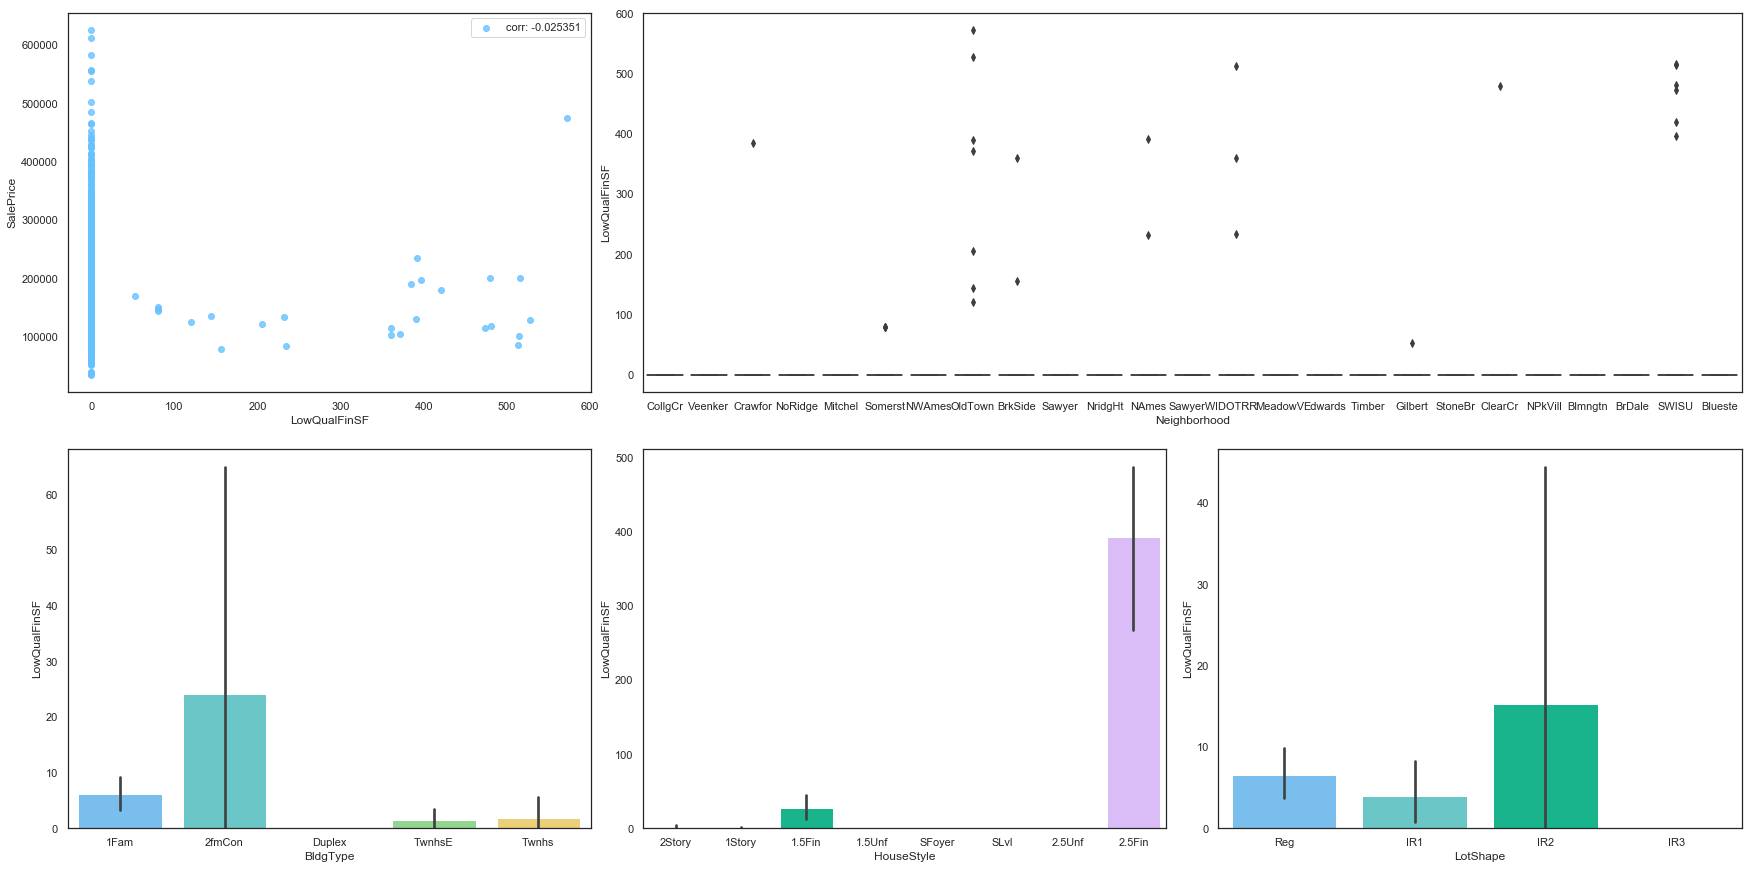

In [219]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['LowQualFinSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['LowQualFinSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="LowQualFinSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="LowQualFinSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="LowQualFinSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="LowQualFinSF", data=train, palette = mycols);

- Мы видим, что для этой переменной существует большое количество свойств со значением 0. Понятно, что он не имеет существенной корреляции с SalePrice.
- По этой причине я заменю эту переменную флагом (0 и 1)

In [220]:
all_data['LowQualFinSF_Flag'] = all_data['LowQualFinSF'].map(lambda x:0 if x==0 else 1)
all_data.drop('LowQualFinSF', axis=1, inplace=True)

***BsmtHalfBath***, ***BsmtFullBath***, ***HalfBath***, ***FullBath***

- Количество ванных комнат.
- Для этой переменной имело смысл объединить их вместе и создать общую переменную ванных комнат.

In [221]:
all_data['TotalBathrooms'] = all_data['BsmtHalfBath'] + all_data['BsmtFullBath'] + all_data['HalfBath'] + all_data['FullBath']

columns = ['BsmtHalfBath', 'BsmtFullBath', 'HalfBath', 'FullBath']
all_data.drop(columns, axis=1, inplace=True)

***Bedroom***
- Спальни (не включает в себя подвальные спальни)

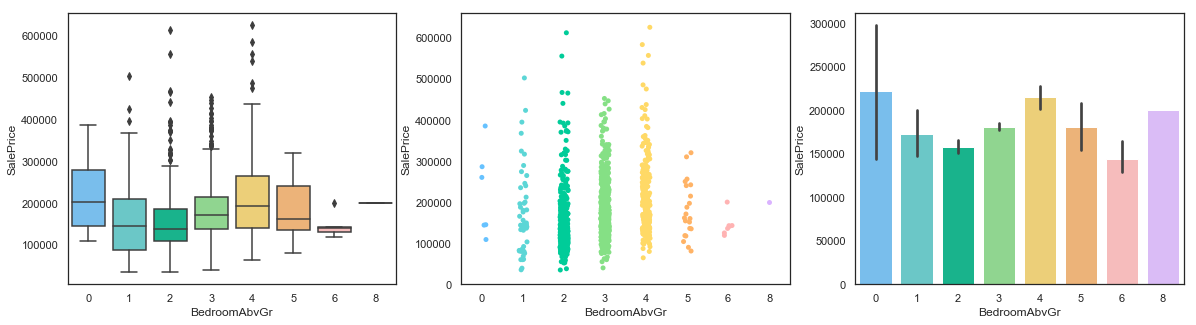

In [222]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BedroomAbvGr", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="BedroomAbvGr", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BedroomAbvGr", y="SalePrice", data=train, palette = mycols);

- Мы видим много домов с 2, 3 и 4 спальнями, и очень мало домов с 6 или выше.
- Поскольку это непрерывная числовая переменная, я оставлю все как есть.

***Kitchen***
- Кухни 

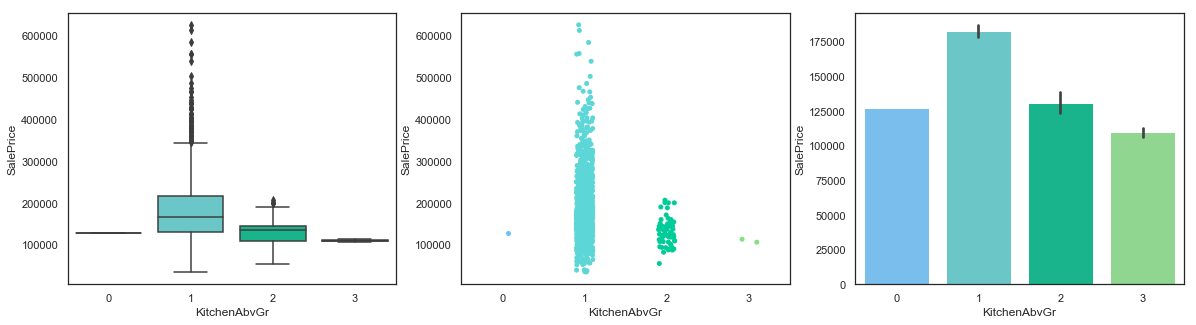

In [223]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="KitchenAbvGr", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="KitchenAbvGr", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="KitchenAbvGr", y="SalePrice", data=train, palette = mycols);

- Подобно последней предыдущей переменной, мы видим лишь небольшое количество домов с большим количеством кухонь. Это показывает, что в большинстве домов есть 1 кухня
- Поскольку это непрерывная числовая переменная, я оставлю ее как есть.

***KitchenQual***
- Качество кухни

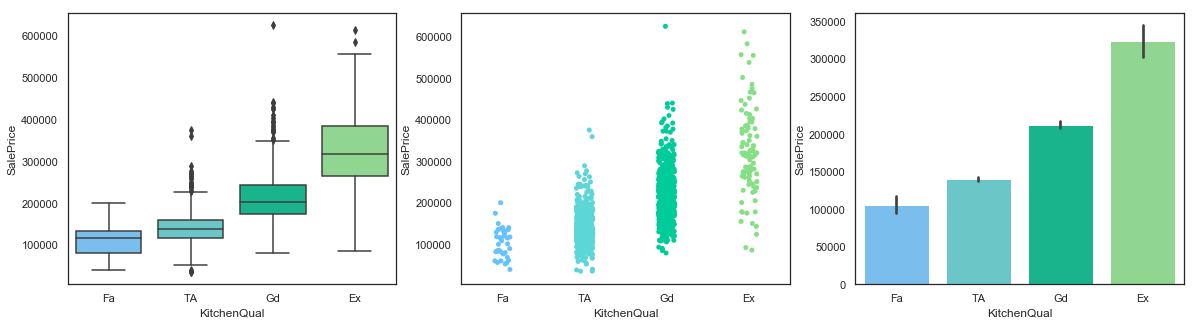

In [224]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="KitchenQual", y="SalePrice", data=train, order=["Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="KitchenQual", y="SalePrice", data=train, size = 5, jitter = True, order=["Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="KitchenQual", y="SalePrice", data=train, order=["Fa", "TA", "Gd", "Ex"], palette = mycols);

- Существует четкая положительная корреляция с SalePrice и качеством кухни.
- Существует одно значение для «Gd», которое имеет чрезвычайно высокий SalePrice.
- Для этой переменной, поскольку она является категориальной, я заменю эти значения вручную.

In [225]:
all_data['KitchenQual'] = all_data['KitchenQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['KitchenQual'].unique()

array([3, 2, 4, 1], dtype=int64)

***TotRmsAbvGrd***
- Общее количество комнат (не включает ванные комнаты)

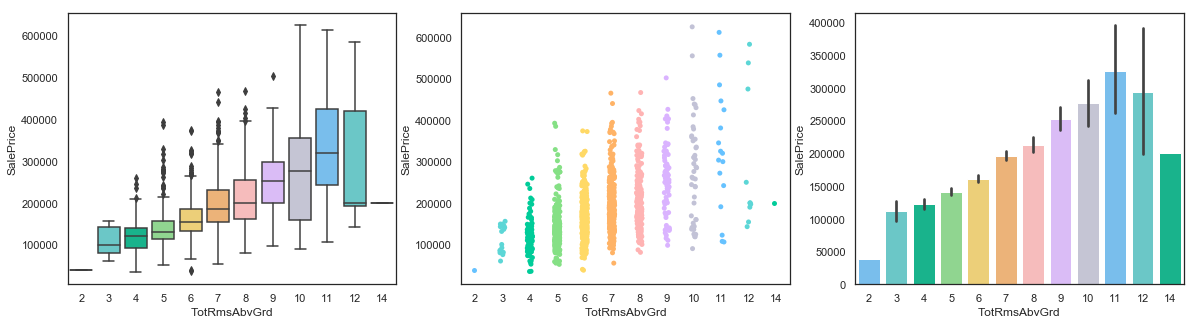

In [226]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="TotRmsAbvGrd", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="TotRmsAbvGrd", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="TotRmsAbvGrd", y="SalePrice", data=train, palette = mycols);

- Как правило, мы видим положительную корреляцию, так как количество комнат увеличивается, также как и SalePrice.
- Однако из-за низкой частоты мы видим ненадежные результаты для очень больших и малых значений для этой переменной.
- Поскольку это непрерывная числовая переменная, я оставлю ее как есть.

***Fireplaces***
- Количество каминов.

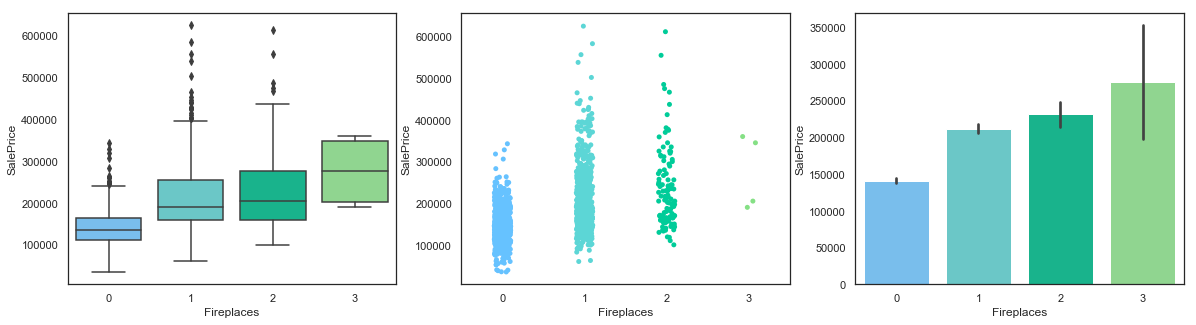

In [227]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Fireplaces", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Fireplaces", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Fireplaces", y="SalePrice", data=train, palette = mycols);

- Еще раз у нас есть положительная корреляция с SalePrice, с большинством домов, имеющих только 1 или 0 каминов.
- Я оставлю как есть.

***FireplaceQu***
- Качество каминов

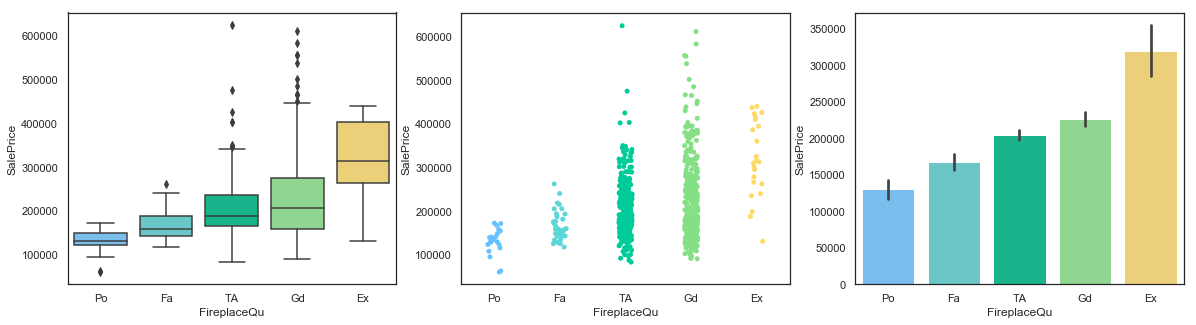

In [228]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="FireplaceQu", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="FireplaceQu", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="FireplaceQu", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

- Мы также видим положительную корреляцию и качество камина увеличивается. В большинстве домов есть камины "TA" или "Gd".
- Поскольку это категориальная переменная, я заменю значения вручную.

In [229]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['FireplaceQu'].unique()

array([0, 3, 4, 2, 5, 1], dtype=int64)

***GrLivArea***
- Надземная жилая площадь в квадратных футах.

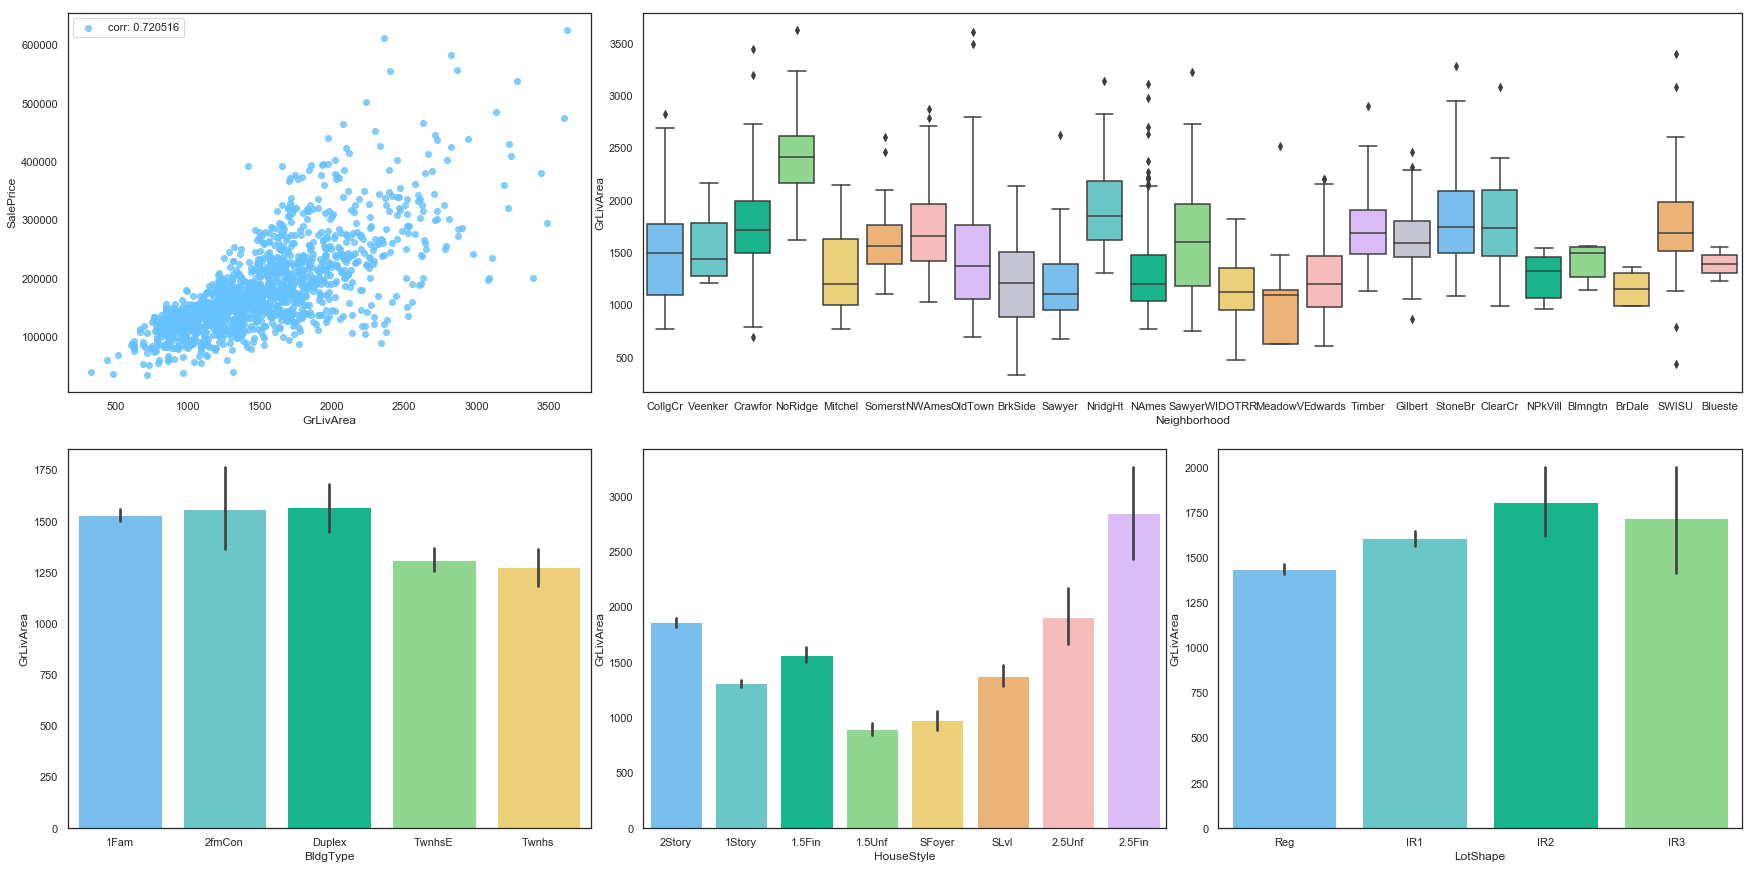

In [230]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['GrLivArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="GrLivArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="GrLivArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="GrLivArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="GrLivArea", data=train, palette = mycols);

- Мы видим очень высокую положительную корреляцию с SalePrice.
- Мы также видим, что значения очень сильно различаются между стилями домов и окрестностей.
- Так как это будет важной переменной в нашем моделировании, я буду создавать привязки и фиктивные элементы.

In [231]:
all_data['GrLivArea_Band'] = pd.cut(all_data['GrLivArea'], 6)
all_data['GrLivArea_Band'].unique()

[(1127.5, 1921.0], (1921.0, 2714.5], (329.239, 1127.5], (2714.5, 3508.0], (3508.0, 4301.5], (4301.5, 5095.0]]
Categories (6, interval[float64]): [(329.239, 1127.5] < (1127.5, 1921.0] < (1921.0, 2714.5] < (2714.5, 3508.0] < (3508.0, 4301.5] < (4301.5, 5095.0]]

In [232]:
all_data.loc[all_data['GrLivArea']<=1127.5, 'GrLivArea'] = 1
all_data.loc[(all_data['GrLivArea']>1127.5) & (all_data['GrLivArea']<=1921), 'GrLivArea'] = 2
all_data.loc[(all_data['GrLivArea']>1921) & (all_data['GrLivArea']<=2714.5), 'GrLivArea'] = 3
all_data.loc[(all_data['GrLivArea']>2714.5) & (all_data['GrLivArea']<=3508), 'GrLivArea'] = 4
all_data.loc[(all_data['GrLivArea']>3508) & (all_data['GrLivArea']<=4301.5), 'GrLivArea'] = 5
all_data.loc[all_data['GrLivArea']>4301.5, 'GrLivArea'] = 6
all_data['GrLivArea'] = all_data['GrLivArea'].astype(int)

all_data.drop('GrLivArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GrLivArea"], prefix="GrLivArea")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  BsmtQual  \
0          0  None             3     1Fam         3             1         3   
1          0  None             3     1Fam         3             4         3   
2          0  None             3     1Fam         3             2         3   

  CentralAir Condition1 Condition2     ...     2ndFlrSF_5  2ndFlrSF_6  \
0          Y       Norm       Norm     ...              0           0   
1          Y      Feedr       Norm     ...              0           0   
2          Y       Norm       Norm     ...              0           0   

  LowQualFinSF_Flag TotalBathrooms GrLivArea_1 GrLivArea_2 GrLivArea_3  \
0                 0            4.0           0           1           0   
1                 0            3.0           0           1           0   
2                 0            4.0           0           1           0   

   GrLivArea_4  GrLivArea_5 GrLivArea_6  
0            0            0           0  
1            0            0           0  
2            0            0           0  

[3 rows x 159 columns]

<a id='architectural_&_structural'></a>
#### 4.2.3 - Архитектура и структура

***MSSubClass***
- Тпп жилья, участвующего в продаже.

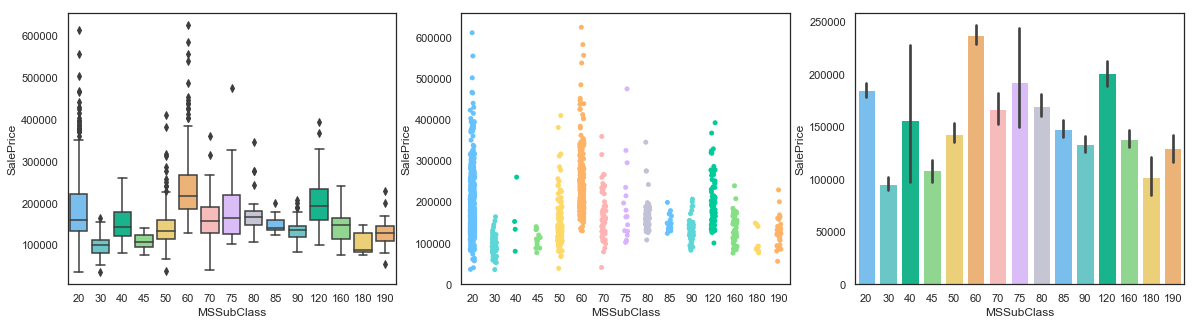

In [233]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MSSubClass", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="MSSubClass", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MSSubClass", y="SalePrice", data=train, palette = mycols);

- Каждый из этих классов представляет собой совершенно другой стиль построения, как показано в описании данных. Следовательно, мы видим большую разницу между классами с помощью SalePrice.
- Это числовая переменная, но она должна быть категориальной. Я мог бы объединить некоторые из этих категорий вместе, но сейчас я создам фиктивную переменную для каждой категории.

In [234]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

all_data = pd.get_dummies(all_data, columns = ["MSSubClass"], prefix="MSSubClass")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  BsmtQual  \
0          0  None             3     1Fam         3             1         3   
1          0  None             3     1Fam         3             4         3   
2          0  None             3     1Fam         3             2         3   

  CentralAir Condition1 Condition2      ...      MSSubClass_30  MSSubClass_40  \
0          Y       Norm       Norm      ...                  0              0   
1          Y      Feedr       Norm      ...                  0              0   
2          Y       Norm       Norm      ...                  0              0   

  MSSubClass_45 MSSubClass_50 MSSubClass_60 MSSubClass_70 MSSubClass_75  \
0             0             0             1             0             0   
1             0             0             0             0             0   
2             0             0             1             0             0   

   MSSubClass_80  MSSubClass_85 MSSubClass_90  
0              0              0             0  
1              0              0             0  
2              0              0             0  

[3 rows x 174 columns]

***BldgType***
- Тип жилья

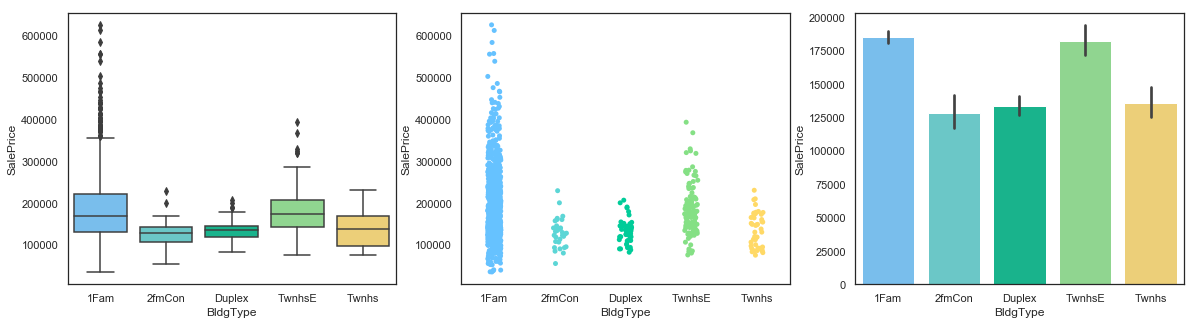

In [235]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BldgType", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="BldgType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BldgType", y="SalePrice", data=train, palette = mycols);

- Различные категории показывают ряд средних SalePrice's. Класс с наибольшим количеством наблюдений - «1Fam».
- Мы также можем видеть, что дисперсия внутри классов довольно узкая, с несколькими экстремальными значениями в каждом случае.
- Может быть возможность кластеризовать эти классы, но сейчас я собираюсь создать фиктивные переменные.

In [236]:
all_data['BldgType'] = all_data['BldgType'].astype(str)

all_data = pd.get_dummies(all_data, columns = ["BldgType"], prefix="BldgType")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...        MSSubClass_70  \
0       Norm       Norm      SBrkr       ...                    0   
1      Feedr       Norm      SBrkr       ...                    0   
2       Norm       Norm      SBrkr       ...                    0   

  MSSubClass_75 MSSubClass_80 MSSubClass_85 MSSubClass_90 BldgType_1Fam  \
0             0             0             0             0             1   
1             0             0             0             0             1   
2             0             0             0             0             1   

   BldgType_2fmCon  BldgType_Duplex BldgType_Twnhs BldgType_TwnhsE  
0                0                0              0               0  
1                0                0              0               0  
2                0                0              0               0  

[3 rows x 178 columns]

***HouseStyle***
- Стиль жилья.

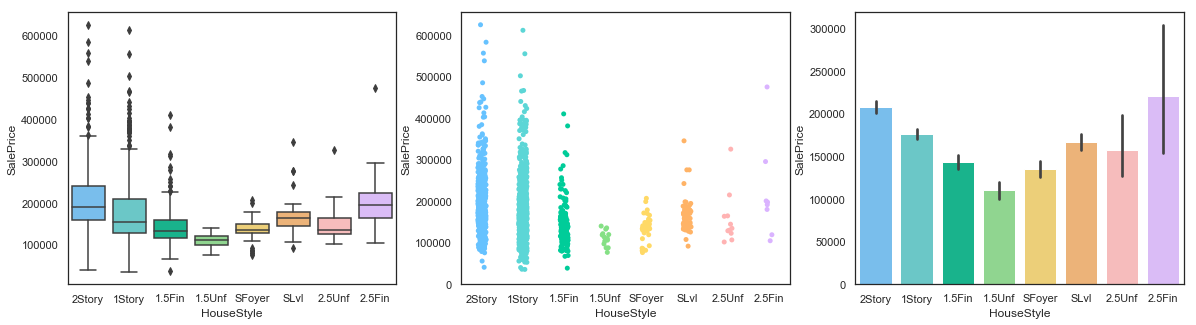

In [237]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="HouseStyle", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="HouseStyle", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="HouseStyle", y="SalePrice", data=train, palette = mycols);

- Здесь мы видим довольно много экстремальных значений по категориям и большое количество наблюдений за целочисленными домами.
- Хотя самый высокий средний SalePrice приходится на «2.5Fin», он имеет очень высокое стандартное отклонение и, следовательно, более надежно, дома «2Story» также имеют очень высокую цену в среднем.
- Поскольку есть некоторые категории с очень небольшим количеством значений, я сгруппирую их в другую категорию и создам фиктивные переменные.

In [238]:
all_data['HouseStyle'] = all_data['HouseStyle'].map({"2Story":"2Story", "1Story":"1Story", "1.5Fin":"1.5Story", "1.5Unf":"1.5Story", 
                                                     "SFoyer":"SFoyer", "SLvl":"SLvl", "2.5Unf":"2.5Story", "2.5Fin":"2.5Story"})

all_data = pd.get_dummies(all_data, columns = ["HouseStyle"], prefix="HouseStyle")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...        BldgType_2fmCon  \
0       Norm       Norm      SBrkr       ...                      0   
1      Feedr       Norm      SBrkr       ...                      0   
2       Norm       Norm      SBrkr       ...                      0   

  BldgType_Duplex BldgType_Twnhs BldgType_TwnhsE HouseStyle_1.5Story  \
0               0              0               0                   0   
1               0              0               0                   0   
2               0              0               0                   0   

  HouseStyle_1Story  HouseStyle_2.5Story  HouseStyle_2Story HouseStyle_SFoyer  \
0                 0                    0                  1                 0   
1                 1                    0                  0                 0   
2                 0                    0                  1                 0   

  HouseStyle_SLvl  
0               0  
1               0  
2               0  

[3 rows x 183 columns]

***OverallQual***
- Оцениваю в целом материал и отделку дома.

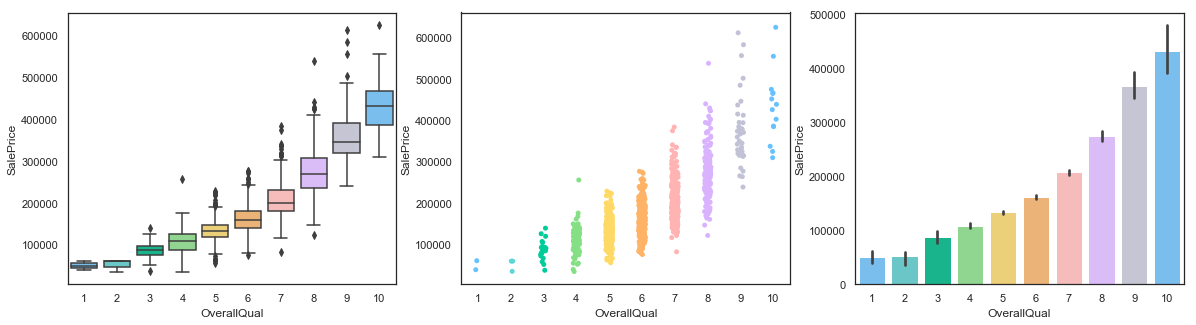

In [239]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="OverallQual", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="OverallQual", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="OverallQual", y="SalePrice", data=train, palette = mycols);

- Эта переменная, хотя и является числовой, на самом деле является категориальной и порядковой, так как значение увеличивается, так же как и SalePrice. Следовательно, я буду держать это как числовую переменную.
- Мы видим здесь хорошую положительную корреляцию с увеличением TotalQual и SalePrice, как и следовало ожидать.

***OverallCond***
- Оцениваю общее состояние дома.

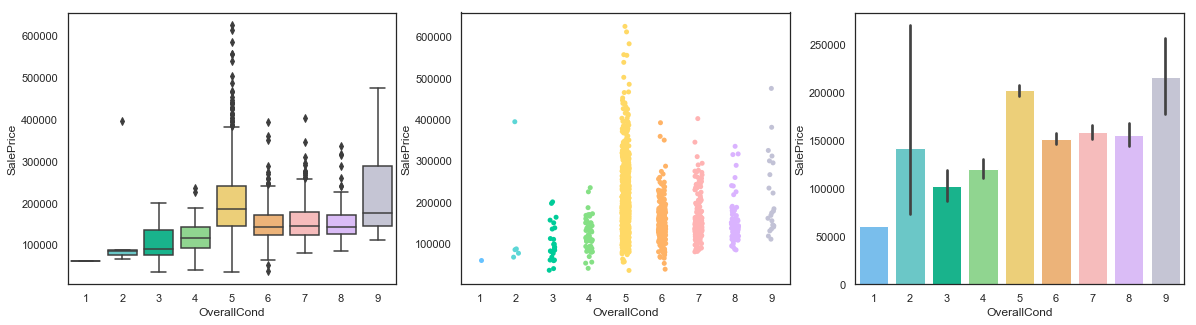

In [240]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="OverallCond", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="OverallCond", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="OverallCond", y="SalePrice", data=train, palette = mycols);

- Интересно, что мы видим здесь, что есть положительная корреляции с SalePrice, однако мы видим пик при значении 5, наряду с большим количеством наблюдений при этом значении.
- Наивысшая средняя SalePrice фактически получается из значения 5, а не 10, что может быть разумным предположением.
- Для этой переменной я оставлю ее как числовую и порядковую.

***YearRemodAdd***
- Дата реконструкции

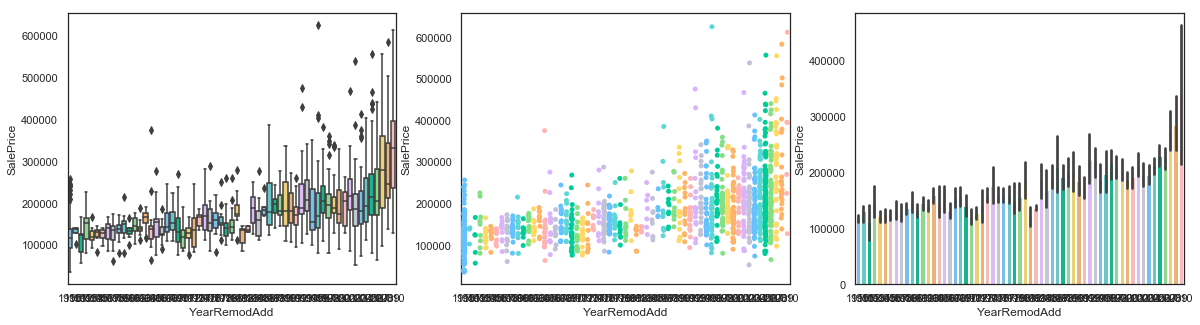

In [241]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="YearRemodAdd", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="YearRemodAdd", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="YearRemodAdd", y="SalePrice", data=train, palette = mycols);

- Здесь мы видим, что чем новее реконструкция дома, тем выше SalePrice.
- Исходя из описания данных, я считаю, что создание новой переменной, описывающей разницу в количестве лет между реконструкцией и строительством, может быть хорошим выбором.

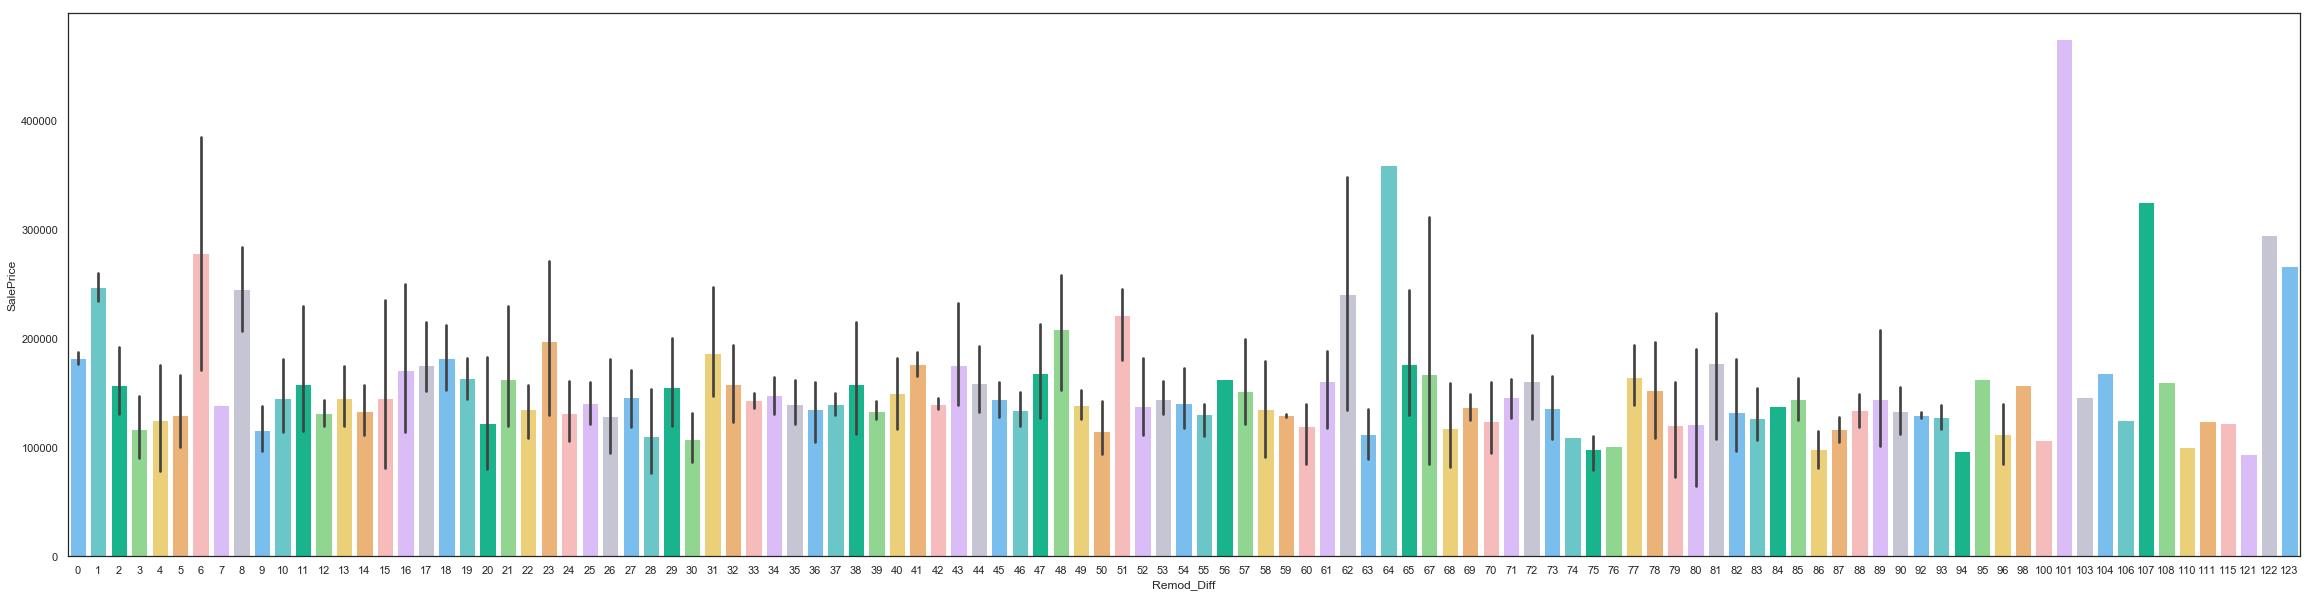

In [242]:
train['Remod_Diff'] = train['YearRemodAdd'] - train['YearBuilt']

plt.subplots(figsize =(40, 10))
sns.barplot(x="Remod_Diff", y="SalePrice", data=train, palette = mycols);

- Ясно видно, что есть некоторые значения, которые имеют гораздо более высокий SalePrice, чем другие. Я оставлю эту переменную без изменений.

In [243]:
all_data['Remod_Diff'] = all_data['YearRemodAdd'] - all_data['YearBuilt']

all_data.drop('YearRemodAdd', axis=1, inplace=True)

***YearBuilt***
- Оригинальная дата строительства.

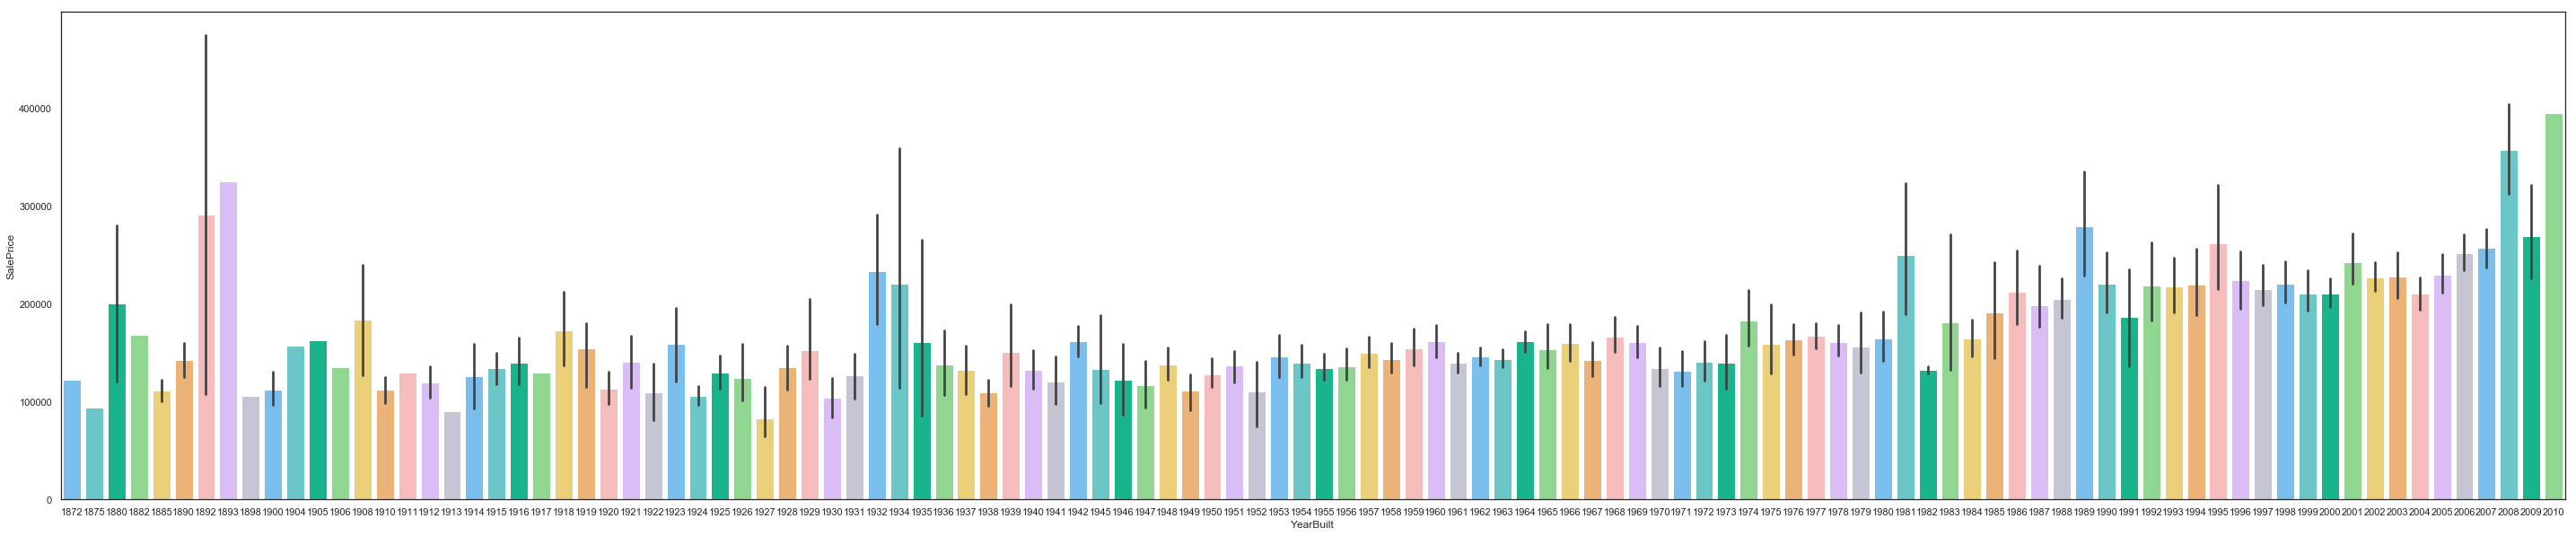

In [244]:
plt.subplots(figsize =(50, 10))

sns.barplot(x="YearBuilt", y="SalePrice", data=train, palette = mycols);

- Здесь мы видим довольно устойчивую тенденцию к росту для SalePrice, так как дома более современные.
- Для этой переменной я собираюсь создать бины и фиктивные переменные

In [245]:
all_data['YearBuilt_Band'] = pd.cut(all_data['YearBuilt'], 7)
all_data['YearBuilt_Band'].unique()

[(1990.286, 2010.0], (1970.571, 1990.286], (1911.429, 1931.143], (1931.143, 1950.857], (1950.857, 1970.571], (1891.714, 1911.429], (1871.862, 1891.714]]
Categories (7, interval[float64]): [(1871.862, 1891.714] < (1891.714, 1911.429] < (1911.429, 1931.143] < (1931.143, 1950.857] < (1950.857, 1970.571] < (1970.571, 1990.286] < (1990.286, 2010.0]]

In [246]:
all_data.loc[all_data['YearBuilt']<=1892, 'YearBuilt'] = 1
all_data.loc[(all_data['YearBuilt']>1892) & (all_data['YearBuilt']<=1911), 'YearBuilt'] = 2
all_data.loc[(all_data['YearBuilt']>1911) & (all_data['YearBuilt']<=1931), 'YearBuilt'] = 3
all_data.loc[(all_data['YearBuilt']>1931) & (all_data['YearBuilt']<=1951), 'YearBuilt'] = 4
all_data.loc[(all_data['YearBuilt']>1951) & (all_data['YearBuilt']<=1971), 'YearBuilt'] = 5
all_data.loc[(all_data['YearBuilt']>1971) & (all_data['YearBuilt']<=1990), 'YearBuilt'] = 6
all_data.loc[all_data['YearBuilt']>1990, 'YearBuilt'] = 7
all_data['YearBuilt'] = all_data['YearBuilt'].astype(int)

all_data.drop('YearBuilt_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["YearBuilt"], prefix="YearBuilt")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical     ...      HouseStyle_SFoyer  \
0       Norm       Norm      SBrkr     ...                      0   
1      Feedr       Norm      SBrkr     ...                      0   
2       Norm       Norm      SBrkr     ...                      0   

  HouseStyle_SLvl Remod_Diff YearBuilt_1 YearBuilt_2 YearBuilt_3  YearBuilt_4  \
0               0          0           0           0           0            0   
1               0          0           0           0           0            0   
2               0          1           0           0           0            0   

   YearBuilt_5 YearBuilt_6 YearBuilt_7  
0            0           0           1  
1            0           1           0  
2            0           0           1  

[3 rows x 189 columns]

***Foundation***
- Тип фундамента.

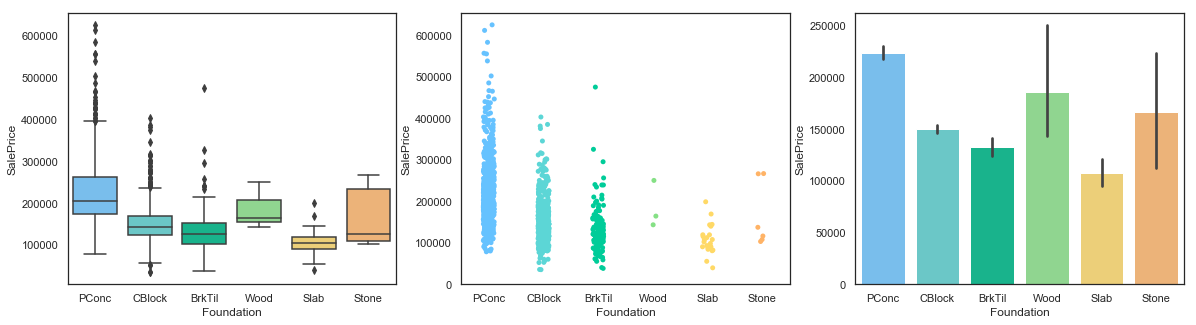

In [247]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Foundation", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="Foundation", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Foundation", y="SalePrice", data=train, palette = mycols);

- У нас есть 3 класса с высокой частотой, но у нас есть 3 с низкой частотой.
- Из-за большой разницы в медиане и средних значениях SalePrice в 3 классах с низкой частотой я не собираюсь объединять их в группы.
- Кроме того, поскольку эта переменная не является порядковой, маркировка не имеет смысла. Вместо этого я создам фиктивные переменные.

In [248]:
all_data = pd.get_dummies(all_data, columns = ["Foundation"], prefix="Foundation")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...         YearBuilt_4 YearBuilt_5  \
0       Norm       Norm      SBrkr       ...                   0           0   
1      Feedr       Norm      SBrkr       ...                   0           0   
2       Norm       Norm      SBrkr       ...                   0           0   

  YearBuilt_6 YearBuilt_7 Foundation_BrkTil Foundation_CBlock  \
0           0           1                 0                 0   
1           1           0                 0                 1   
2           0           1                 0                 0   

   Foundation_PConc  Foundation_Slab Foundation_Stone  Foundation_Wood  
0                 1                0                0                0  
1                 0                0                0                0  
2                 1                0                0                0  

[3 rows x 194 columns]

***Functional***
- Домашняя функциональность.

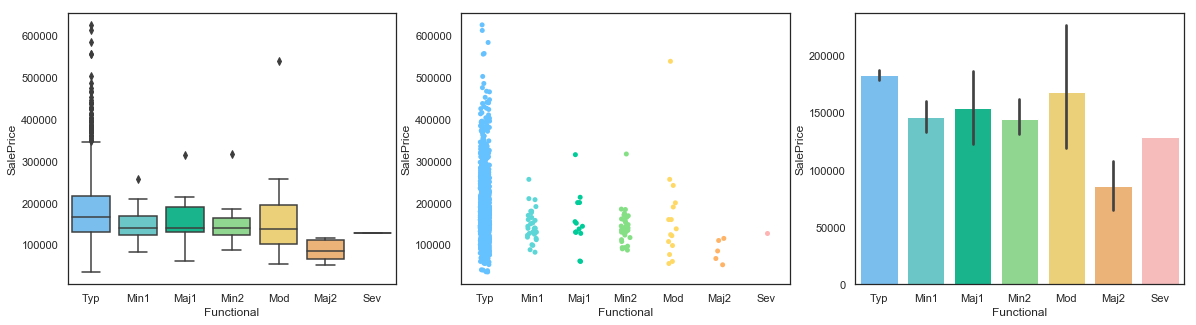

In [249]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Functional", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Functional", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Functional", y="SalePrice", data=train, palette = mycols);

- Эта категориальная переменная показывает, что большинство домов имеют функциональность «Typ», и просмотр описания данных позволяет мне полагать, что в этих категориях есть порядок, причем «Typ» имеет наивысший порядок.
- Поэтому я заменю значения этой переменной вручную цифрами.

In [250]:
all_data['Functional'] = all_data['Functional'].map({"Sev":1, "Maj2":2, "Maj1":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7})
all_data['Functional'].unique()

array([7, 6, 3, 5, 4, 2, 1], dtype=int64)

<a id='exterior'></a>
#### 4.2.4 - Exterior

***RoofStyle***
- Тип крыши.

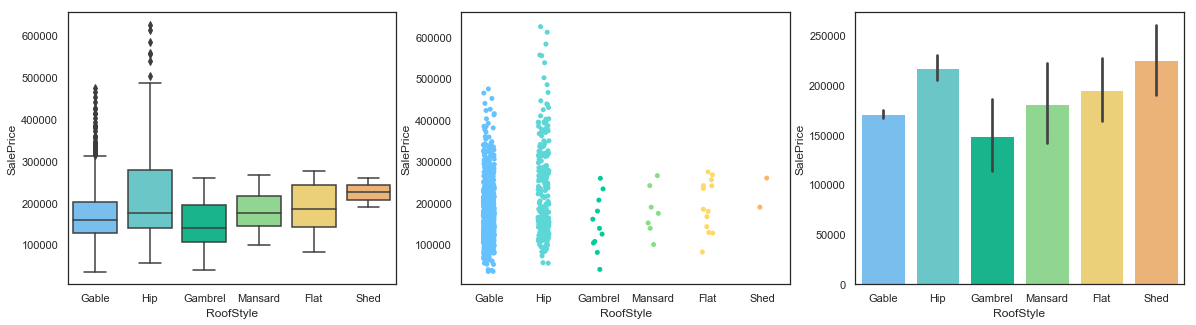

In [251]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="RoofStyle", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="RoofStyle", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="RoofStyle", y="SalePrice", data=train, palette = mycols);

- Эта переменная имеет две очень частые категории, но значения SalePrice отличаются между собой.
- Поскольку это категорическая переменная без порядка, я создам фиктивные переменные.

In [252]:
all_data = pd.get_dummies(all_data, columns = ["RoofStyle"], prefix="RoofStyle")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...        Foundation_PConc  \
0       Norm       Norm      SBrkr       ...                       1   
1      Feedr       Norm      SBrkr       ...                       0   
2       Norm       Norm      SBrkr       ...                       1   

  Foundation_Slab Foundation_Stone Foundation_Wood RoofStyle_Flat  \
0               0                0               0              0   
1               0                0               0              0   
2               0                0               0              0   

  RoofStyle_Gable  RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  \
0               1                  0              0                  0   
1               1                  0              0                  0   
2               1                  0              0                  0   

   RoofStyle_Shed  
0               0  
1               0  
2               0  

[3 rows x 199 columns]

***RoofMatl***
- Материал крыши.

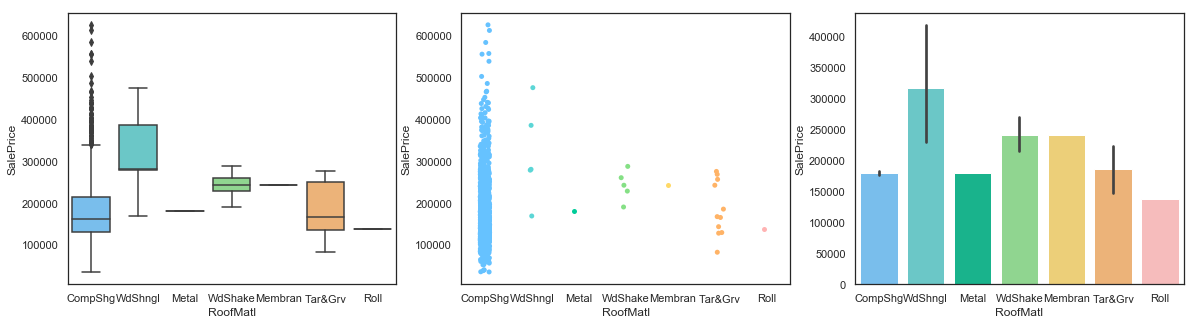

In [253]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="RoofMatl", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="RoofMatl", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="RoofMatl", y="SalePrice", data=train, palette = mycols);

- Интересно, что в учебных данных для нескольких классов очень мало наблюдений. Тем не менее, они будут отброшены во время  feature reduction, если они окажутся незначительными.
- Следовательно, я буду создавать фиктивные переменные.

In [254]:
all_data = pd.get_dummies(all_data, columns = ["RoofMatl"], prefix="RoofMatl")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical        ...         RoofStyle_Hip  \
0       Norm       Norm      SBrkr        ...                     0   
1      Feedr       Norm      SBrkr        ...                     0   
2       Norm       Norm      SBrkr        ...                     0   

  RoofStyle_Mansard RoofStyle_Shed RoofMatl_CompShg RoofMatl_Membran  \
0                 0              0                1                0   
1                 0              0                1                0   
2                 0              0                1                0   

  RoofMatl_Metal  RoofMatl_Roll  RoofMatl_Tar&Grv  RoofMatl_WdShake  \
0              0              0                 0                 0   
1              0              0                 0                 0   
2              0              0                 0                 0   

   RoofMatl_WdShngl  
0                 0  
1                 0  
2                 0  

[3 rows x 205 columns]

***Exterior1st*** & ***Exterior2nd***
- Наружное покрытие дома.

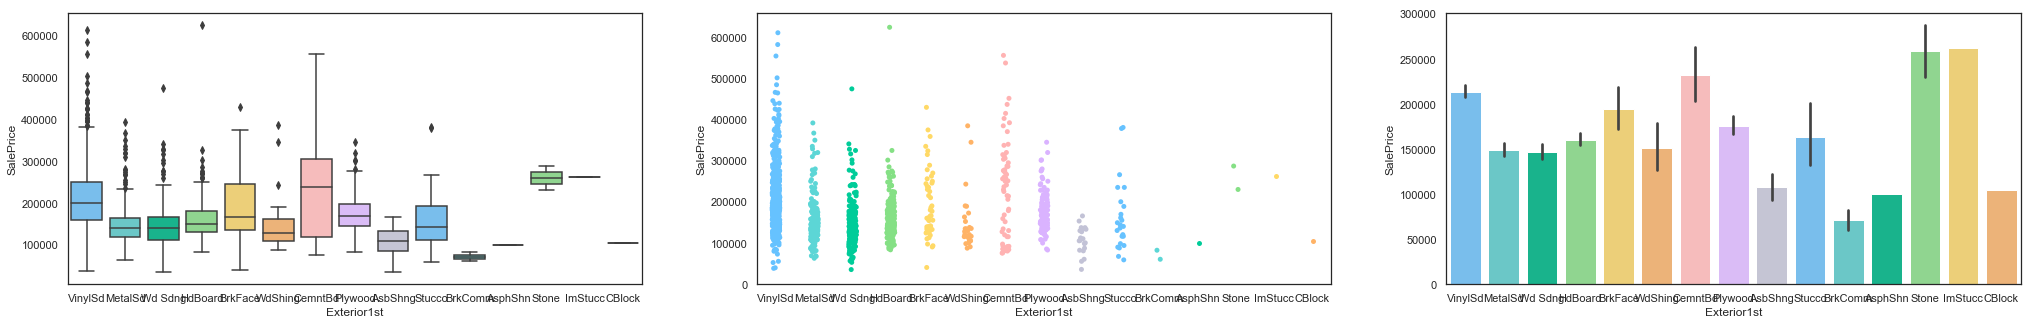

In [255]:
plt.subplots(figsize =(35, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Exterior1st", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="Exterior1st", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Exterior1st", y="SalePrice", data=train, palette = mycols);

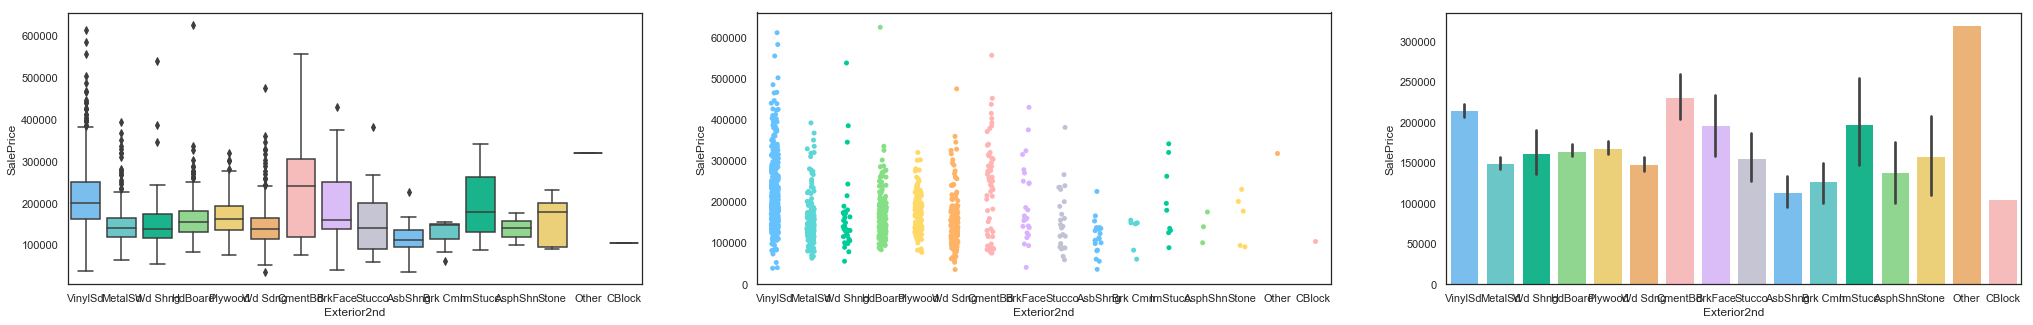

In [256]:
plt.subplots(figsize =(35, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Exterior2nd", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="Exterior2nd", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Exterior2nd", y="SalePrice", data=train, palette = mycols);

- Рассматривая эти 2 переменные вместе, мы видим, что они демонстрируют очень похожее поведение по сравнению с SalePrice. Это говорит мне, что они очень тесно связаны.
- Следовательно, я создам флаг, чтобы указать, есть ли второе внешнее покрытие, отличное от первого.
- Тогда я сохраню «Exterior1st» и создам фиктивные переменные из этого.

In [257]:
def Exter2(col):
    if col['Exterior2nd'] == col['Exterior1st']:
        return 1
    else:
        return 0
    
all_data['ExteriorMatch_Flag'] = all_data.apply(Exter2, axis=1)
all_data.drop('Exterior2nd', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["Exterior1st"], prefix="Exterior1st")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical         ...          Exterior1st_CemntBd  \
0       Norm       Norm      SBrkr         ...                            0   
1      Feedr       Norm      SBrkr         ...                            0   
2       Norm       Norm      SBrkr         ...                            0   

  Exterior1st_HdBoard Exterior1st_ImStucc Exterior1st_MetalSd  \
0                   0                   0                   0   
1                   0                   0                   1   
2                   0                   0                   0   

   Exterior1st_Plywood  Exterior1st_Stone  Exterior1st_Stucco  \
0                    0                  0                   0   
1                    0                  0                   0   
2                    0                  0                   0   

   Exterior1st_VinylSd  Exterior1st_Wd Sdng Exterior1st_WdShing  
0                    1                    0                   0  
1                    0                    0                   0  
2                    1                    0                   0  

[3 rows x 219 columns]

***MasVnrType***
- Кирпичный тип шпона.

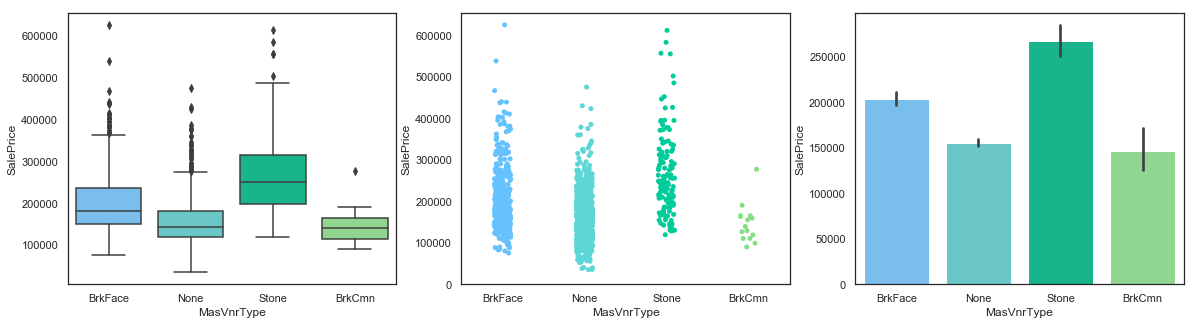

In [258]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MasVnrType", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="MasVnrType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MasVnrType", y="SalePrice", data=train, palette = mycols);

- Каждый класс имеет совершенно уникальный диапазон значений для SalePrice, единственный выделяющийся класс - BrkCmn, который имеет низкую частоту.
- Очевидно, что «Stone» требует в среднем наивысшую SalePrice, хотя в BrkFace есть некоторые экстремальные значения.
- Поскольку это категориальная переменная без порядка, я создам фиктивные переменные здесь.

In [259]:
all_data = pd.get_dummies(all_data, columns = ["MasVnrType"], prefix="MasVnrType")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...         Exterior1st_Plywood  \
0       Norm       Norm      SBrkr       ...                           0   
1      Feedr       Norm      SBrkr       ...                           0   
2       Norm       Norm      SBrkr       ...                           0   

  Exterior1st_Stone Exterior1st_Stucco Exterior1st_VinylSd  \
0                 0                  0                   1   
1                 0                  0                   0   
2                 0                  0                   1   

   Exterior1st_Wd Sdng  Exterior1st_WdShing  MasVnrType_BrkCmn  \
0                    0                    0                  0   
1                    0                    0                  0   
2                    0                    0                  0   

   MasVnrType_BrkFace  MasVnrType_None MasVnrType_Stone  
0                   1                0                0  
1                   0                1                0  
2                   1                0                0  

[3 rows x 222 columns]

***MasVnrArea***
- Площадь шпона в квадратных футах.

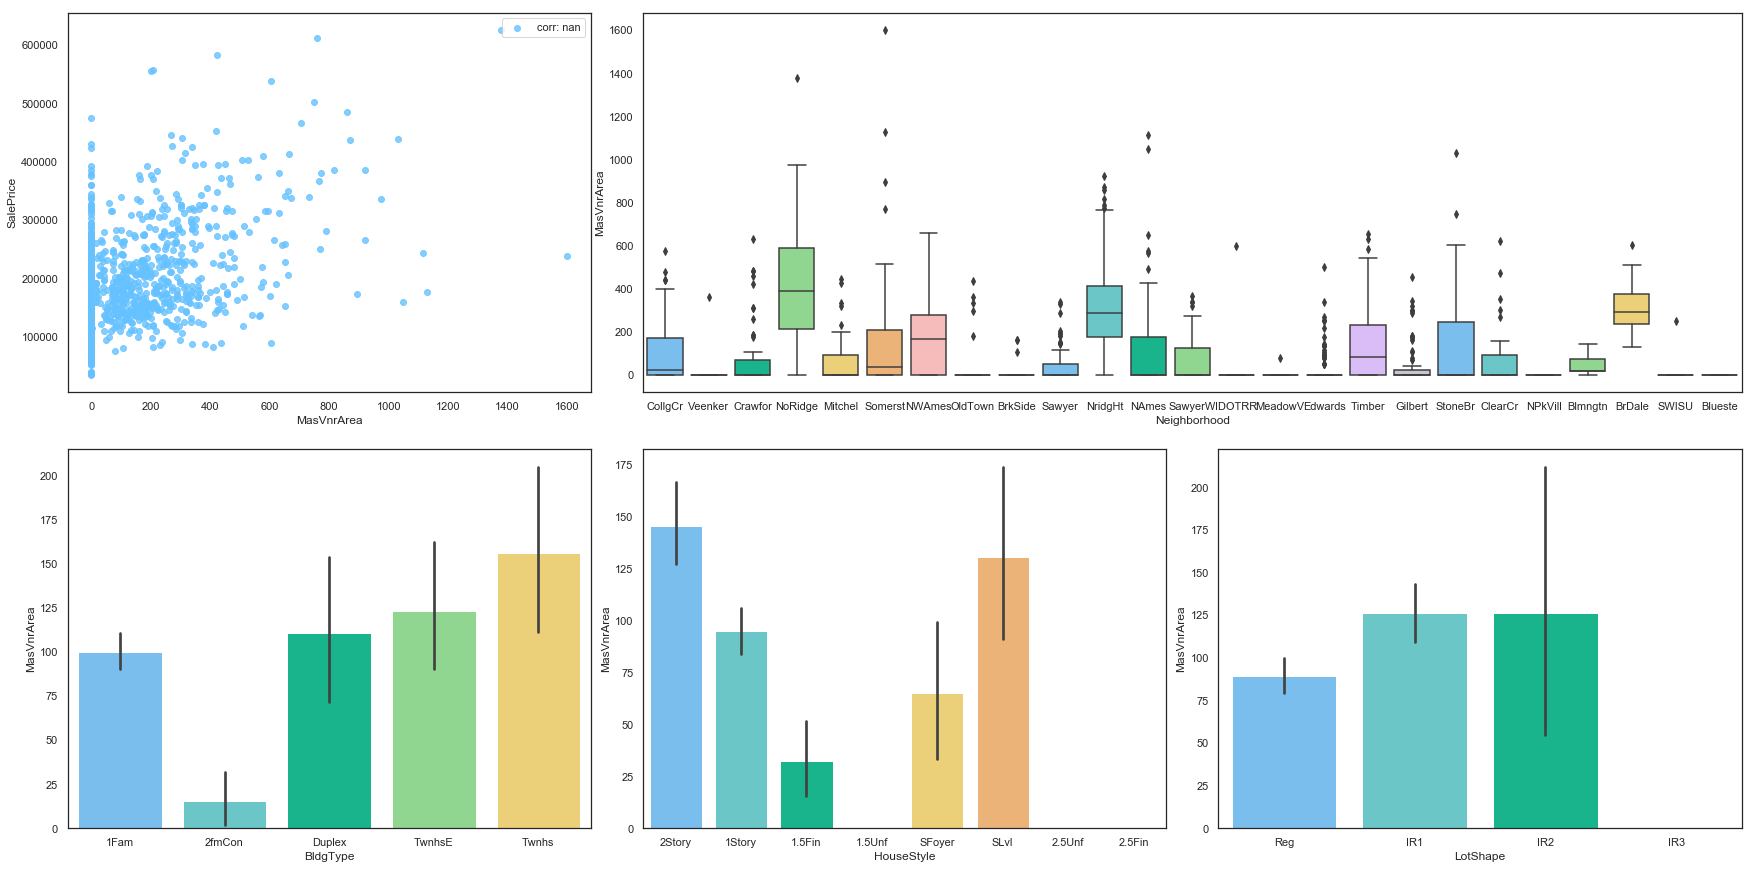

In [260]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['MasVnrArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['MasVnrArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="MasVnrArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="MasVnrArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="MasVnrArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="MasVnrArea", data=train, palette = mycols);

- Из этого мы видим, что эта переменная имеет незначительную корреляцию с SalePrice, и значения для этой переменой широко варьируются в зависимости от типа дома, стиля и размера.
- Поскольку эта переменая незначительна по отношению к SalePrice, и она также сильно коррелирует с «MasVnrType» (если «MasVnrType =« None », то она должна быть равна 0), я откажусь от этой переменной.

In [261]:
all_data.drop('MasVnrArea', axis=1, inplace=True)

***ExterQual***
- Оценивает качество материала по экстерьеру.

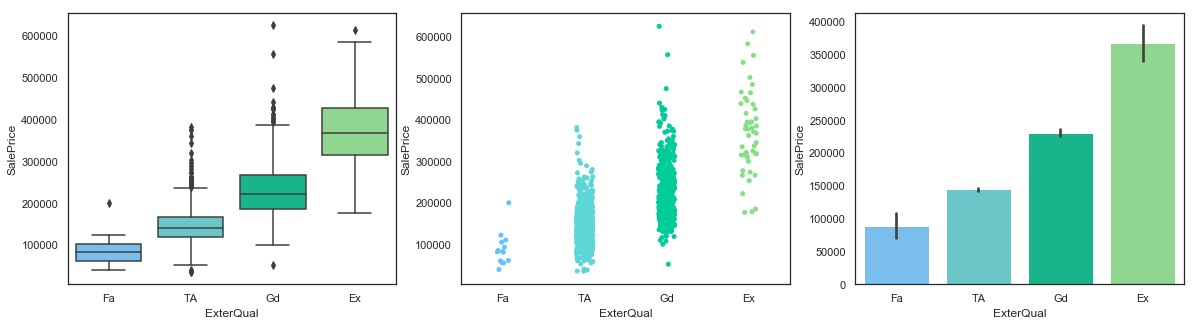

In [262]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="ExterQual", y="SalePrice", data=train, order=['Fa','TA','Gd', 'Ex'], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="ExterQual", y="SalePrice", data=train, size = 5, jitter = True, order=['Fa','TA','Gd', 'Ex'], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="ExterQual", y="SalePrice", data=train, order=['Fa','TA','Gd', 'Ex'], palette = mycols);

- Мы видим здесь, что эта переменная показывает четкий порядок и имеет положительную корреляцию с SalePrice. По мере повышения качества, увеличивается и SalePrice.
- Мы видим наибольшее количество наблюдений в двух средних классах и самые низкие в низшем классе.
- Поскольку это категориальная переменная с порядком, я заменю эти значения вручную.

In [263]:
all_data['ExterQual'] = all_data['ExterQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['ExterQual'].unique()

array([3, 2, 4, 1], dtype=int64)

***ExterCond***
- Оценивает текущее состояние материала по экстерьеру.

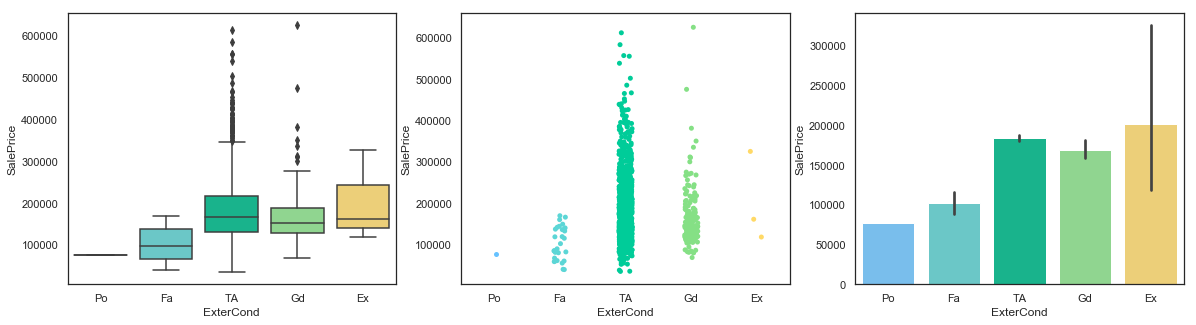

In [264]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="ExterCond", y="SalePrice", data=train, order=['Po','Fa','TA','Gd', 'Ex'], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="ExterCond", y="SalePrice", data=train, size = 5, jitter = True, order=['Po','Fa','TA','Gd', 'Ex'], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="ExterCond", y="SalePrice", data=train, order=['Po','Fa','TA','Gd', 'Ex'], palette = mycols);

- Интересно, что мы видим самые большие значения SalePrice для второго и третьего лучших классов. Возможно, это связано с большой частотой значений в этих классах, в то время как мы видим только 3 наблюдения в «Ex» из данных обучения.
- Поскольку у этой категориальной переменнрй есть порядок, но SalePrice не обязательно соотносится с этим порядком. Я создам фиктивные переменные.

In [265]:
all_data = pd.get_dummies(all_data, columns = ["ExterCond"], prefix="ExterCond")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical     ...       Exterior1st_WdShing  \
0       Norm       Norm      SBrkr     ...                         0   
1      Feedr       Norm      SBrkr     ...                         0   
2       Norm       Norm      SBrkr     ...                         0   

   MasVnrType_BrkCmn MasVnrType_BrkFace  MasVnrType_None  MasVnrType_Stone  \
0                  0                  1                0                 0   
1                  0                  0                1                 0   
2                  0                  1                0                 0   

   ExterCond_Ex  ExterCond_Fa  ExterCond_Gd ExterCond_Po ExterCond_TA  
0             0             0             0            0            1  
1             0             0             0            0            1  
2             0             0             0            0            1  

[3 rows x 225 columns]

***GarageType***
- Расположение гаража.

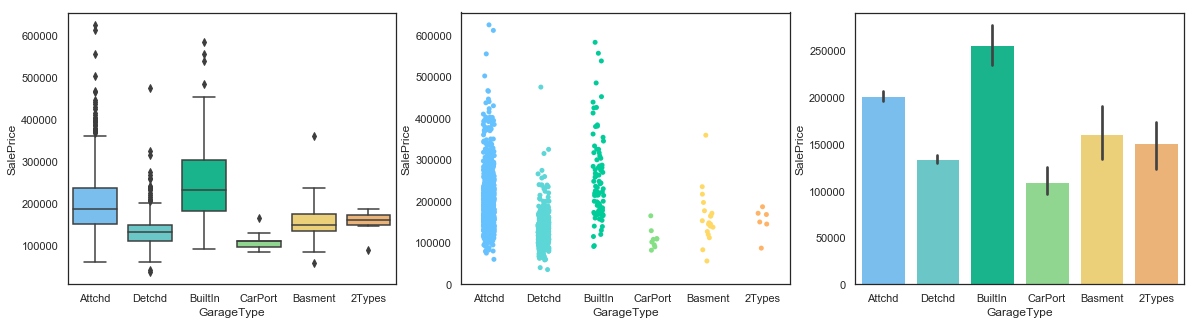

In [266]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageType", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageType", y="SalePrice", data=train, palette = mycols);

- Здесь мы видим, что «BuiltIn» и «Attched» имеют 2 самых высоких средних SalePrices, с несколькими экстремальными значениями в каждом классе.
- Поскольку это категорически без порядка, я создам фиктивные переменные.

In [267]:
all_data = pd.get_dummies(all_data, columns = ["GarageType"], prefix="GarageType")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...        ExterCond_Gd  \
0       Norm       Norm      SBrkr       ...                   0   
1      Feedr       Norm      SBrkr       ...                   0   
2       Norm       Norm      SBrkr       ...                   0   

   ExterCond_Po ExterCond_TA  GarageType_2Types  GarageType_Attchd  \
0             0            1                  0                  1   
1             0            1                  0                  1   
2             0            1                  0                  1   

   GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   

  GarageType_Detchd GarageType_None  
0                 0               0  
1                 0               0  
2                 0               0  

[3 rows x 231 columns]

***GarageYrBlt***
- Год, в котором гараж был построен.

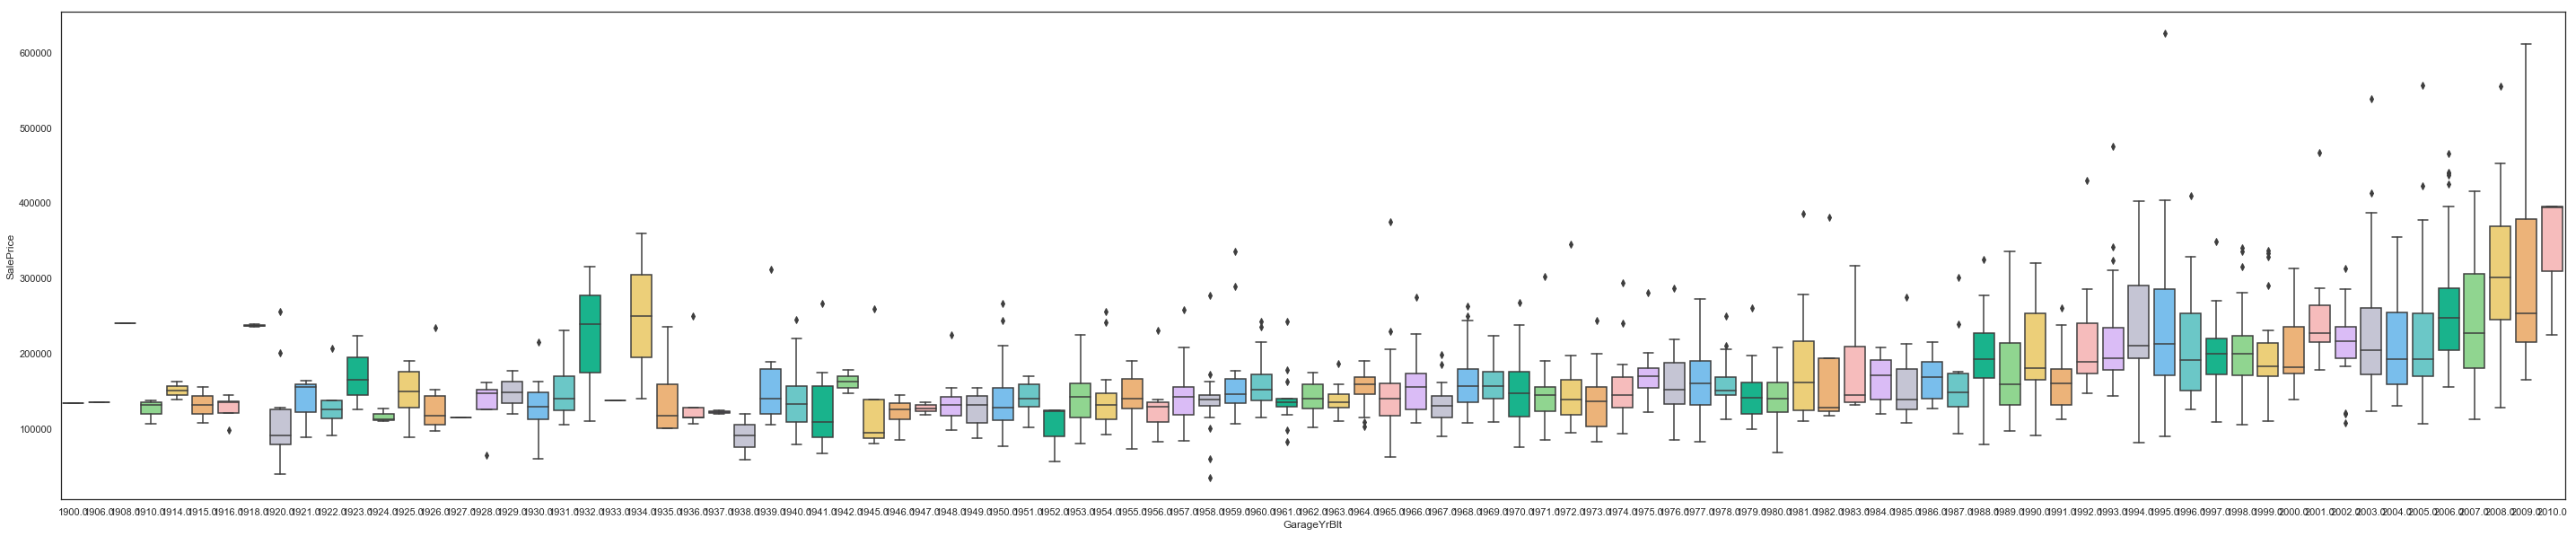

In [268]:
plt.subplots(figsize =(50, 10))

sns.boxplot(x="GarageYrBlt", y="SalePrice", data=train, palette = mycols);

- Мы видим небольшую тенденцию к росту, поскольку год строительства гаража становится все более современным.
- Для этой переменной я собираюсь создать бины и фиктивные переменные.

In [269]:
all_data['GarageYrBlt_Band'] = pd.qcut(all_data['GarageYrBlt'], 3)
all_data['GarageYrBlt_Band'].unique()

[(1996.0, 2207.0], (1964.0, 1996.0], (-0.001, 1964.0]]
Categories (3, interval[float64]): [(-0.001, 1964.0] < (1964.0, 1996.0] < (1996.0, 2207.0]]

In [270]:
all_data.loc[all_data['GarageYrBlt']<=1964, 'GarageYrBlt'] = 1
all_data.loc[(all_data['GarageYrBlt']>1964) & (all_data['GarageYrBlt']<=1996), 'GarageYrBlt'] = 2
all_data.loc[all_data['GarageYrBlt']>1996, 'GarageYrBlt'] = 3
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(int)

all_data.drop('GarageYrBlt_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GarageYrBlt"], prefix="GarageYrBlt")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical      ...       GarageType_2Types  \
0       Norm       Norm      SBrkr      ...                       0   
1      Feedr       Norm      SBrkr      ...                       0   
2       Norm       Norm      SBrkr      ...                       0   

   GarageType_Attchd GarageType_Basment  GarageType_BuiltIn  \
0                  1                  0                   0   
1                  1                  0                   0   
2                  1                  0                   0   

   GarageType_CarPort  GarageType_Detchd  GarageType_None  GarageYrBlt_1  \
0                   0                  0                0              0   
1                   0                  0                0              0   
2                   0                  0                0              0   

  GarageYrBlt_2 GarageYrBlt_3  
0             0             1  
1             1             0  
2             0             1  

[3 rows x 233 columns]

***GarageFinish***
- внутренняя отделка гаража.

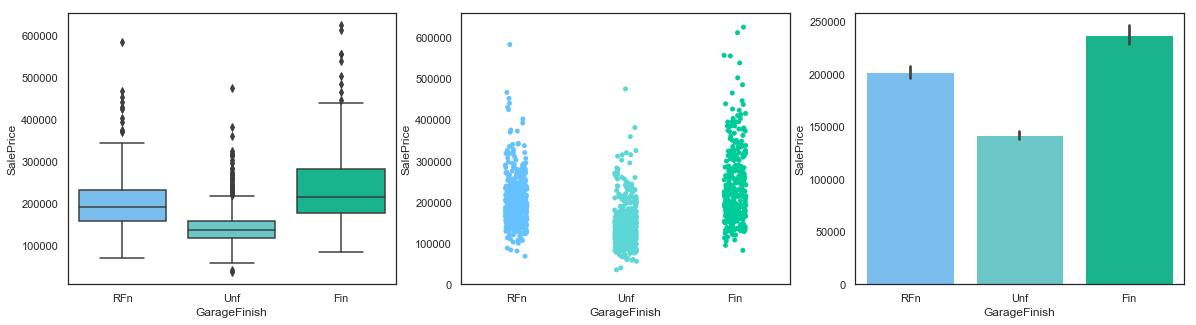

In [271]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageFinish", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageFinish", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageFinish", y="SalePrice", data=train, palette = mycols);

- Здесь мы видим хорошее разделение между 3 классами, причем «Fin» дает в среднем самые высокие SalePrice.
- Я создам фиктивные переменные для этой переменной.

In [272]:
all_data = pd.get_dummies(all_data, columns = ["GarageFinish"], prefix="GarageFinish")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...         GarageType_CarPort  \
0       Norm       Norm      SBrkr       ...                          0   
1      Feedr       Norm      SBrkr       ...                          0   
2       Norm       Norm      SBrkr       ...                          0   

   GarageType_Detchd GarageType_None  GarageYrBlt_1  GarageYrBlt_2  \
0                  0               0              0              0   
1                  0               0              0              1   
2                  0               0              0              0   

   GarageYrBlt_3  GarageFinish_Fin  GarageFinish_None GarageFinish_RFn  \
0              1                 0                  0                1   
1              0                 0                  0                1   
2              1                 0                  0                1   

  GarageFinish_Unf  
0                0  
1                0  
2                0  

[3 rows x 236 columns]

***GarageCars***
- Размер гаража по вместимости машины.

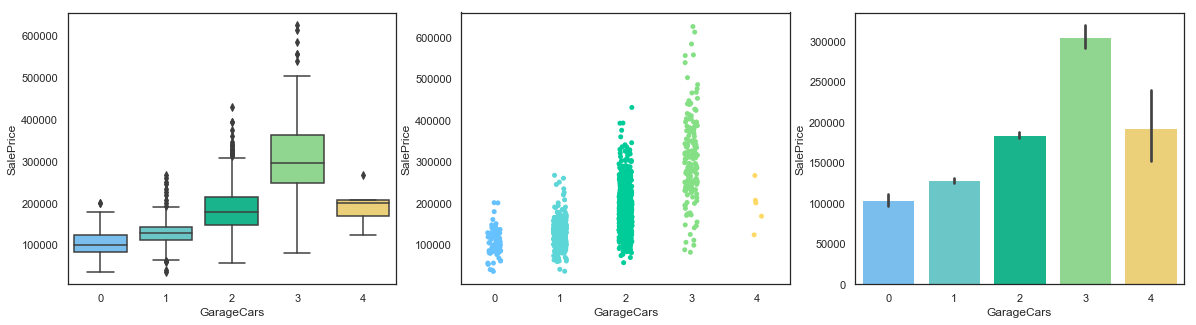

In [273]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageCars", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageCars", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageCars", y="SalePrice", data=train, palette = mycols);

- В целом мы видим положительную корреляцию с увеличением вместимости гаражных автомобилей. Тем не менее, мы видим небольшое падение на 4 машины, я полагаю, из-за низкой частоты домов с гаражом на 4 машины.

***GarageArea***
- Размер гаража в квадратных футах.

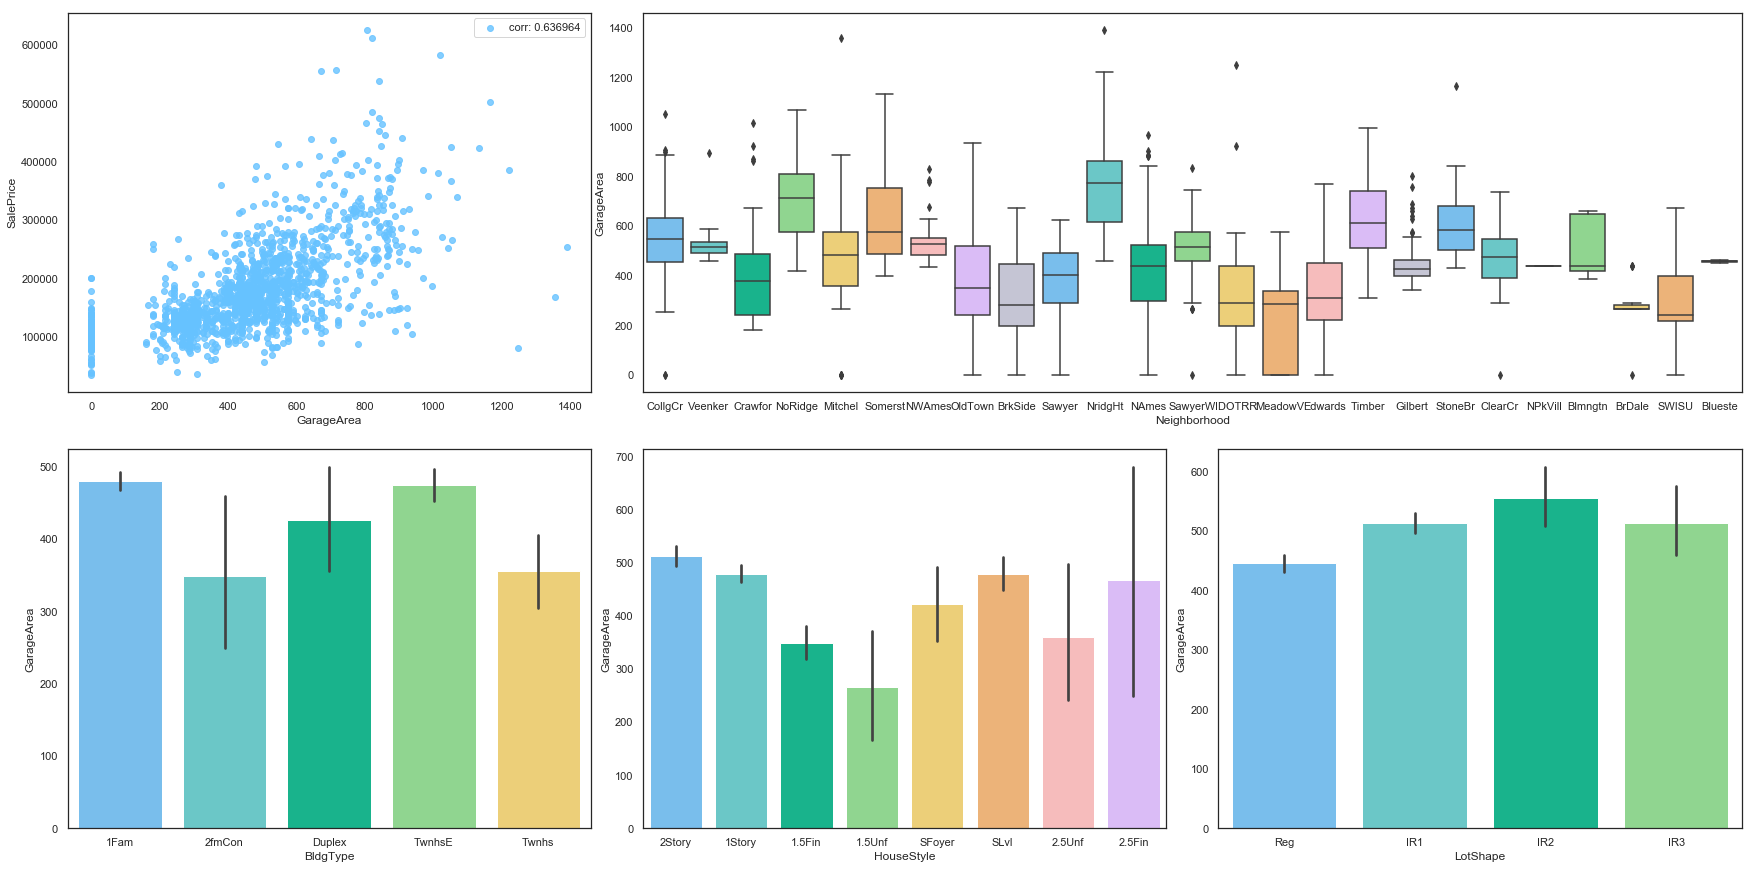

In [274]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['GarageArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['GarageArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="GarageArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="GarageArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="GarageArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="GarageArea", data=train, palette = mycols);

- Это имеет чрезвычайно высокую положительную корреляцию с SalePrice, и это сильно зависит от района, типа здания и стиля дома.
- Это может быть важной переменной в анализе, поэтому я сделаю бин и создам фиктивные переменные.

In [275]:
all_data['GarageArea_Band'] = pd.cut(all_data['GarageArea'], 3)
all_data['GarageArea_Band'].unique()

[(496.0, 992.0], (-1.488, 496.0], (992.0, 1488.0]]
Categories (3, interval[float64]): [(-1.488, 496.0] < (496.0, 992.0] < (992.0, 1488.0]]

In [276]:
all_data.loc[all_data['GarageArea']<=496, 'GarageArea'] = 1
all_data.loc[(all_data['GarageArea']>496) & (all_data['GarageArea']<=992), 'GarageArea'] = 2
all_data.loc[all_data['GarageArea']>992, 'GarageArea'] = 3
all_data['GarageArea'] = all_data['GarageArea'].astype(int)

all_data.drop('GarageArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GarageArea"], prefix="GarageArea")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical     ...       GarageYrBlt_1  GarageYrBlt_2  \
0       Norm       Norm      SBrkr     ...                   0              0   
1      Feedr       Norm      SBrkr     ...                   0              1   
2       Norm       Norm      SBrkr     ...                   0              0   

  GarageYrBlt_3  GarageFinish_Fin  GarageFinish_None  GarageFinish_RFn  \
0             1                 0                  0                 1   
1             0                 0                  0                 1   
2             1                 0                  0                 1   

   GarageFinish_Unf GarageArea_1 GarageArea_2 GarageArea_3  
0                 0            0            1            0  
1                 0            1            0            0  
2                 0            0            1            0  

[3 rows x 238 columns]

***GarageQual***
- Качество гаража

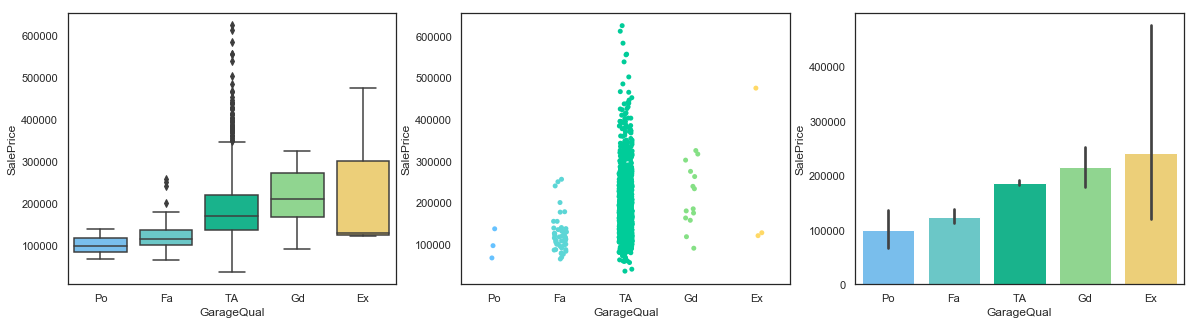

In [277]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageQual", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageQual", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageQual", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

- Мы видим много домов, имеющих качественные гаражи "ТА", и очень мало домов, имеющих качественные и некачественные.
- Я собираюсь кластеризовать классы, а затем создать фиктивные переменные.

In [278]:
all_data['GarageQual'] = all_data['GarageQual'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data['GarageQual'].unique()

array(['TA', 'Low', 'High', 'None'], dtype=object)

In [279]:
all_data = pd.get_dummies(all_data, columns = ["GarageQual"], prefix="GarageQual")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical      ...       GarageFinish_None  \
0       Norm       Norm      SBrkr      ...                       0   
1      Feedr       Norm      SBrkr      ...                       0   
2       Norm       Norm      SBrkr      ...                       0   

   GarageFinish_RFn GarageFinish_Unf  GarageArea_1  GarageArea_2  \
0                 1                0             0             1   
1                 1                0             1             0   
2                 1                0             0             1   

   GarageArea_3  GarageQual_High GarageQual_Low GarageQual_None GarageQual_TA  
0             0                0              0               0             1  
1             0                0              0               0             1  
2             0                0              0               0             1  

[3 rows x 241 columns]

***GarageCond***
- Состояние гаража.

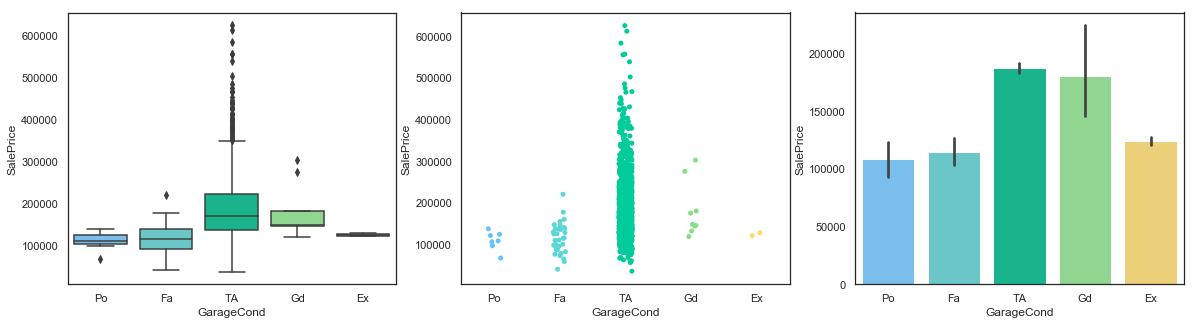

In [280]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageCond", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageCond", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageCond", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

- Мы видим довольно похожую картину здесь с предыдущей переменной. Мы видим небольшую положительную корреляцию и затем падение, я полагаю, из-за небольшого числа домов, которые имеют гаражные условия "Ex" или "Gd".
- Как и прежде, я собираюсь кластеризовать и затем dummy.

In [281]:
all_data['GarageCond'] = all_data['GarageCond'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data['GarageCond'].unique()

array(['TA', 'Low', 'None', 'High'], dtype=object)

In [282]:
all_data = pd.get_dummies(all_data, columns = ["GarageCond"], prefix="GarageCond")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical      ...        GarageArea_2  GarageArea_3  \
0       Norm       Norm      SBrkr      ...                   1             0   
1      Feedr       Norm      SBrkr      ...                   0             0   
2       Norm       Norm      SBrkr      ...                   1             0   

  GarageQual_High  GarageQual_Low  GarageQual_None  GarageQual_TA  \
0               0               0                0              1   
1               0               0                0              1   
2               0               0                0              1   

   GarageCond_High GarageCond_Low GarageCond_None  GarageCond_TA  
0                0              0               0              1  
1                0              0               0              1  
2                0              0               0              1  

[3 rows x 244 columns]

***WoodDeckSF***
- Деревянная палубная зона в SF.

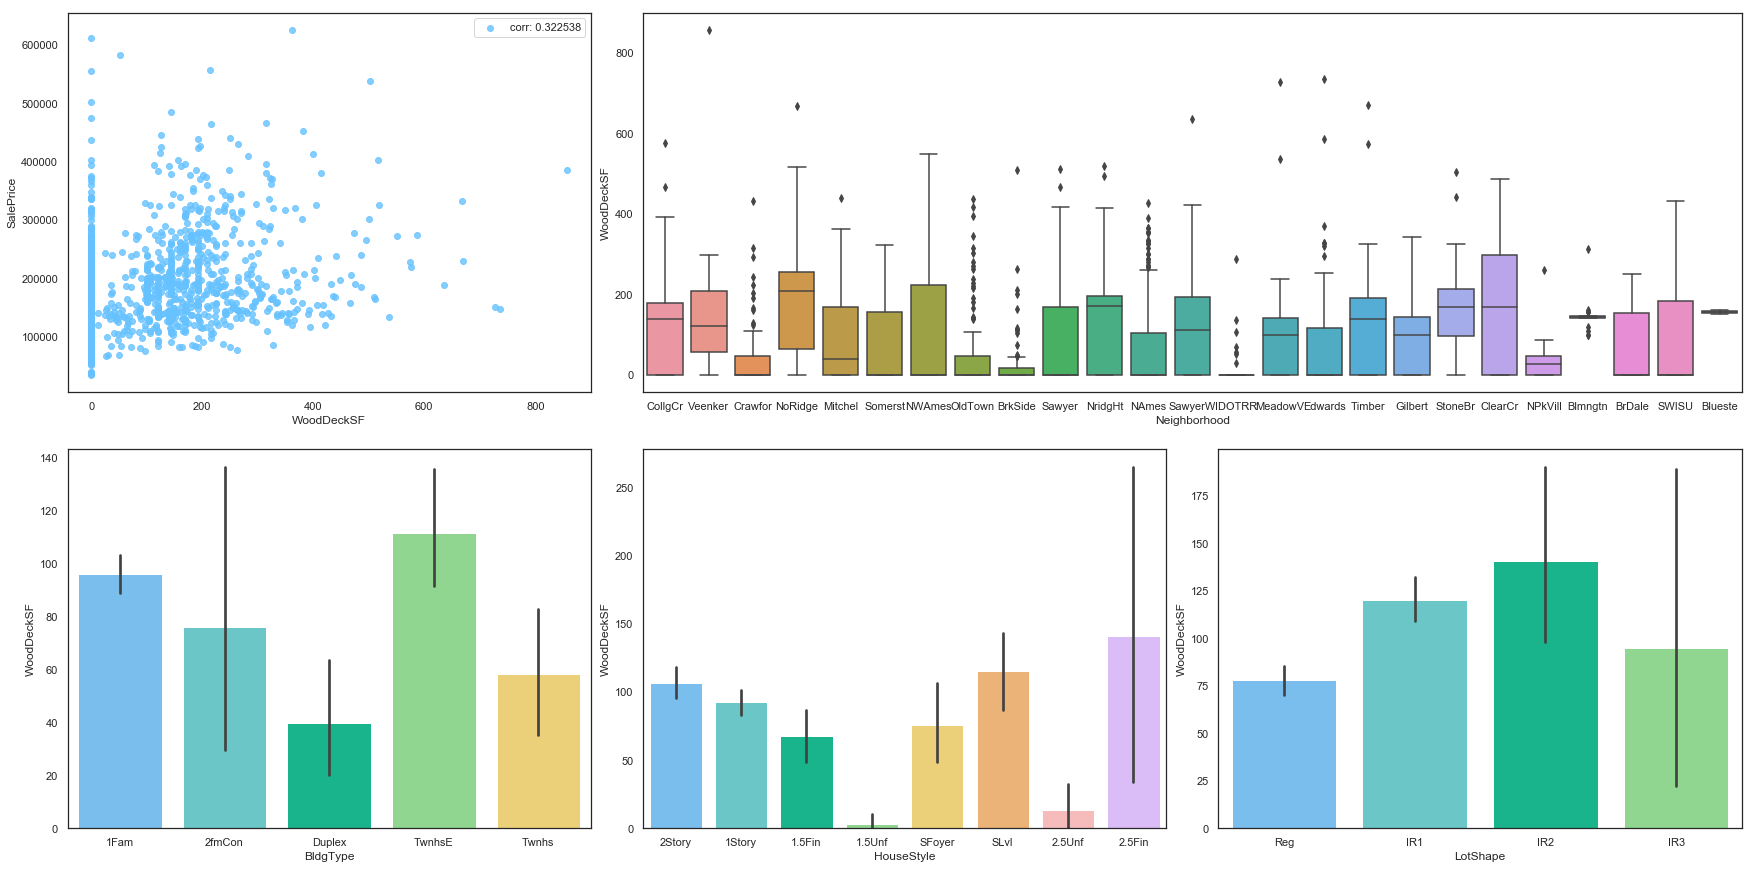

In [283]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['WoodDeckSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['WoodDeckSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="WoodDeckSF", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="WoodDeckSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="WoodDeckSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="WoodDeckSF", data=train, palette = mycols);

- Эта переменная имеет высокую положительную корреляцию с SalePrice.
- Мы также видим, что он сильно зависит от местоположения, типа здания, стиля и размера участка.
- Существует значительное количество точек данных со значением 0, поэтому я создам флаг, чтобы указать отсутствие деревянной колоды. Затем, поскольку это непрерывная числовая переменная, и я считаю, что она важна, я ее скопирую, а затем создам фиктивные переменные.

In [284]:
def WoodDeckFlag(col):
    if col['WoodDeckSF'] == 0:
        return 1
    else:
        return 0
    
all_data['NoWoodDeck_Flag'] = all_data.apply(WoodDeckFlag, axis=1)

all_data['WoodDeckSF_Band'] = pd.cut(all_data['WoodDeckSF'], 4)

all_data.loc[all_data['WoodDeckSF']<=356, 'WoodDeckSF'] = 1
all_data.loc[(all_data['WoodDeckSF']>356) & (all_data['WoodDeckSF']<=712), 'WoodDeckSF'] = 2
all_data.loc[(all_data['WoodDeckSF']>712) & (all_data['WoodDeckSF']<=1068), 'WoodDeckSF'] = 3
all_data.loc[all_data['WoodDeckSF']>1068, 'WoodDeckSF'] = 4
all_data['WoodDeckSF'] = all_data['WoodDeckSF'].astype(int)

all_data.drop('WoodDeckSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["WoodDeckSF"], prefix="WoodDeckSF")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical      ...       GarageQual_TA  \
0       Norm       Norm      SBrkr      ...                   1   
1      Feedr       Norm      SBrkr      ...                   1   
2       Norm       Norm      SBrkr      ...                   1   

   GarageCond_High GarageCond_Low  GarageCond_None  GarageCond_TA  \
0                0              0                0              1   
1                0              0                0              1   
2                0              0                0              1   

   NoWoodDeck_Flag  WoodDeckSF_1 WoodDeckSF_2 WoodDeckSF_3  WoodDeckSF_4  
0                1             1            0            0             0  
1                0             1            0            0             0  
2                1             1            0            0             0  

[3 rows x 248 columns]

***OpenPorchSF***, ***EnclosedPorch***, ***3SsnPorch*** & ***ScreenPorch***
- Я суммирую эти переменные вместе, чтобы создать общий подъезд в квадратных футах.

In [285]:
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch'] 
train['TotalPorchSF'] = train['OpenPorchSF'] + train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

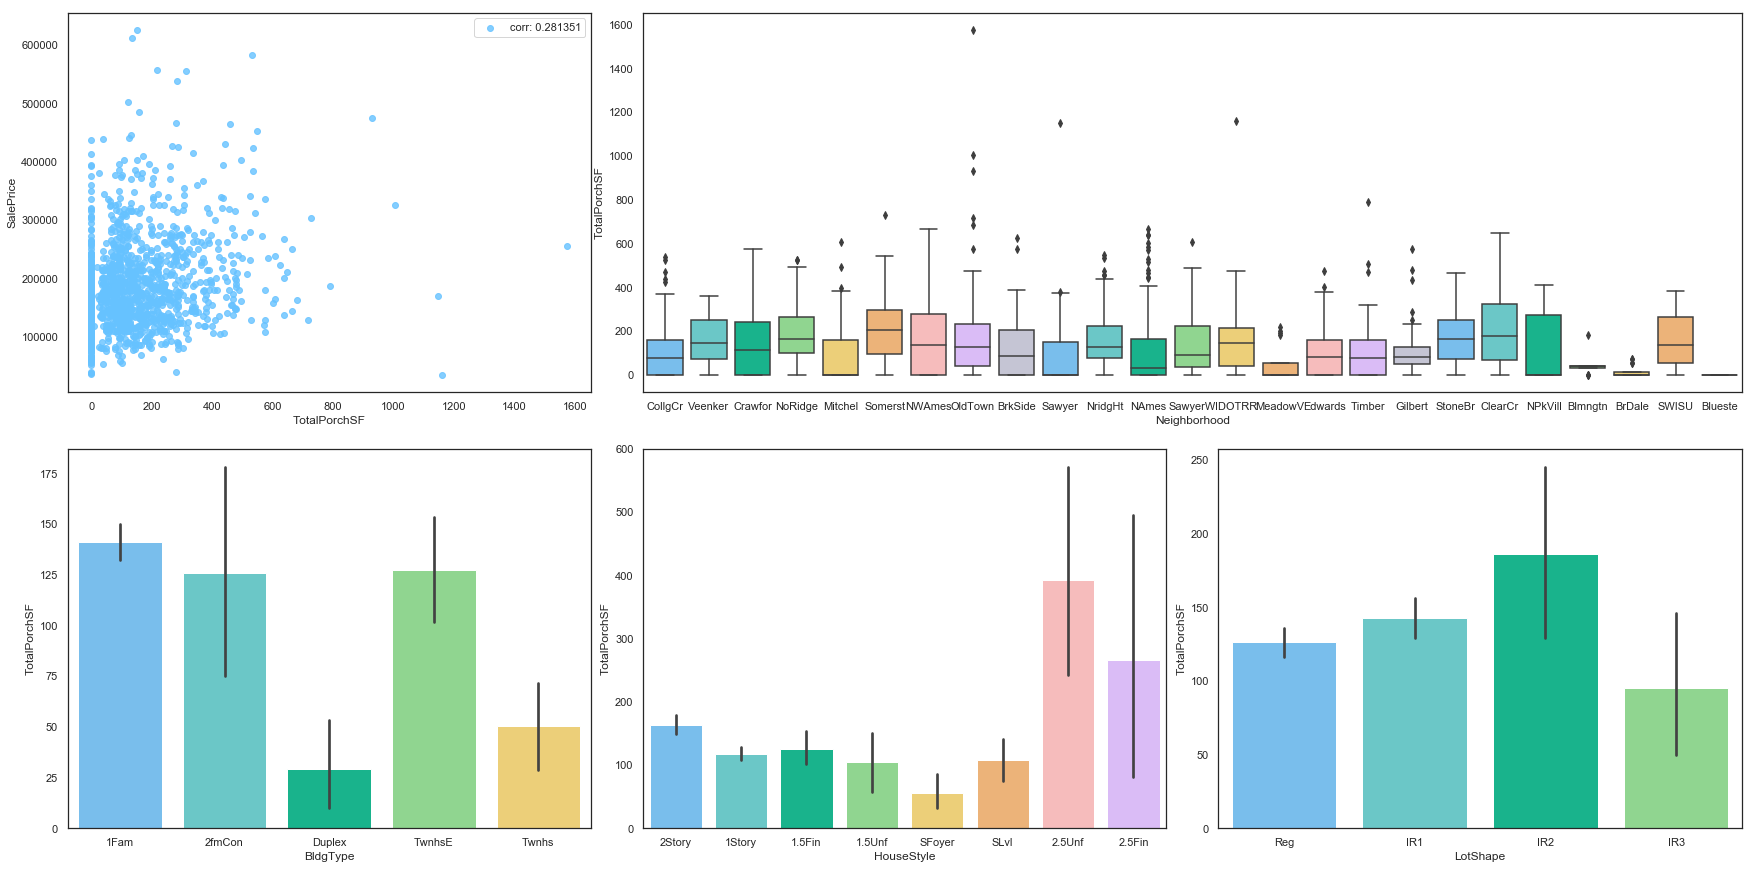

In [286]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['TotalPorchSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['TotalPorchSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="TotalPorchSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="TotalPorchSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="TotalPorchSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="TotalPorchSF", data=train, palette = mycols);

- Мы снова видим большое количество точек данных, имеющих значение 0.
- Помимо этого, мы видим высокую положительную корреляцию с SalePrice, показывающую, что это может быть влиятельным фактором для анализа.
- Наконец, мы видим, что это значение широко варьируется в зависимости от местоположения, типа здания, стиля и участка.
- Я создам флаг, указывающий на отсутствие открытого крыльца, затем я скомпоную переменную и создам фиктивные переменные.

In [287]:
def PorchFlag(col):
    if col['TotalPorchSF'] == 0:
        return 1
    else:
        return 0
    
all_data['NoPorch_Flag'] = all_data.apply(PorchFlag, axis=1)

all_data['TotalPorchSF_Band'] = pd.cut(all_data['TotalPorchSF'], 4)
all_data['TotalPorchSF_Band'].unique()

[(-1.724, 431.0], (431.0, 862.0], (862.0, 1293.0], (1293.0, 1724.0]]
Categories (4, interval[float64]): [(-1.724, 431.0] < (431.0, 862.0] < (862.0, 1293.0] < (1293.0, 1724.0]]

In [288]:
all_data.loc[all_data['TotalPorchSF']<=431, 'TotalPorchSF'] = 1
all_data.loc[(all_data['TotalPorchSF']>431) & (all_data['TotalPorchSF']<=862), 'TotalPorchSF'] = 2
all_data.loc[(all_data['TotalPorchSF']>862) & (all_data['TotalPorchSF']<=1293), 'TotalPorchSF'] = 3
all_data.loc[all_data['TotalPorchSF']>1293, 'TotalPorchSF'] = 4
all_data['TotalPorchSF'] = all_data['TotalPorchSF'].astype(int)

all_data.drop('TotalPorchSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["TotalPorchSF"], prefix="TotalPorchSF")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...        NoWoodDeck_Flag  \
0       Norm       Norm      SBrkr       ...                      1   
1      Feedr       Norm      SBrkr       ...                      0   
2       Norm       Norm      SBrkr       ...                      1   

   WoodDeckSF_1 WoodDeckSF_2  WoodDeckSF_3  WoodDeckSF_4  NoPorch_Flag  \
0             1            0             0             0             0   
1             1            0             0             0             1   
2             1            0             0             0             0   

   TotalPorchSF_1 TotalPorchSF_2 TotalPorchSF_3  TotalPorchSF_4  
0               1              0              0               0  
1               1              0              0               0  
2               1              0              0               0  

[3 rows x 253 columns]

***PoolArea***
- Площадь бассейна в квадратных футах.

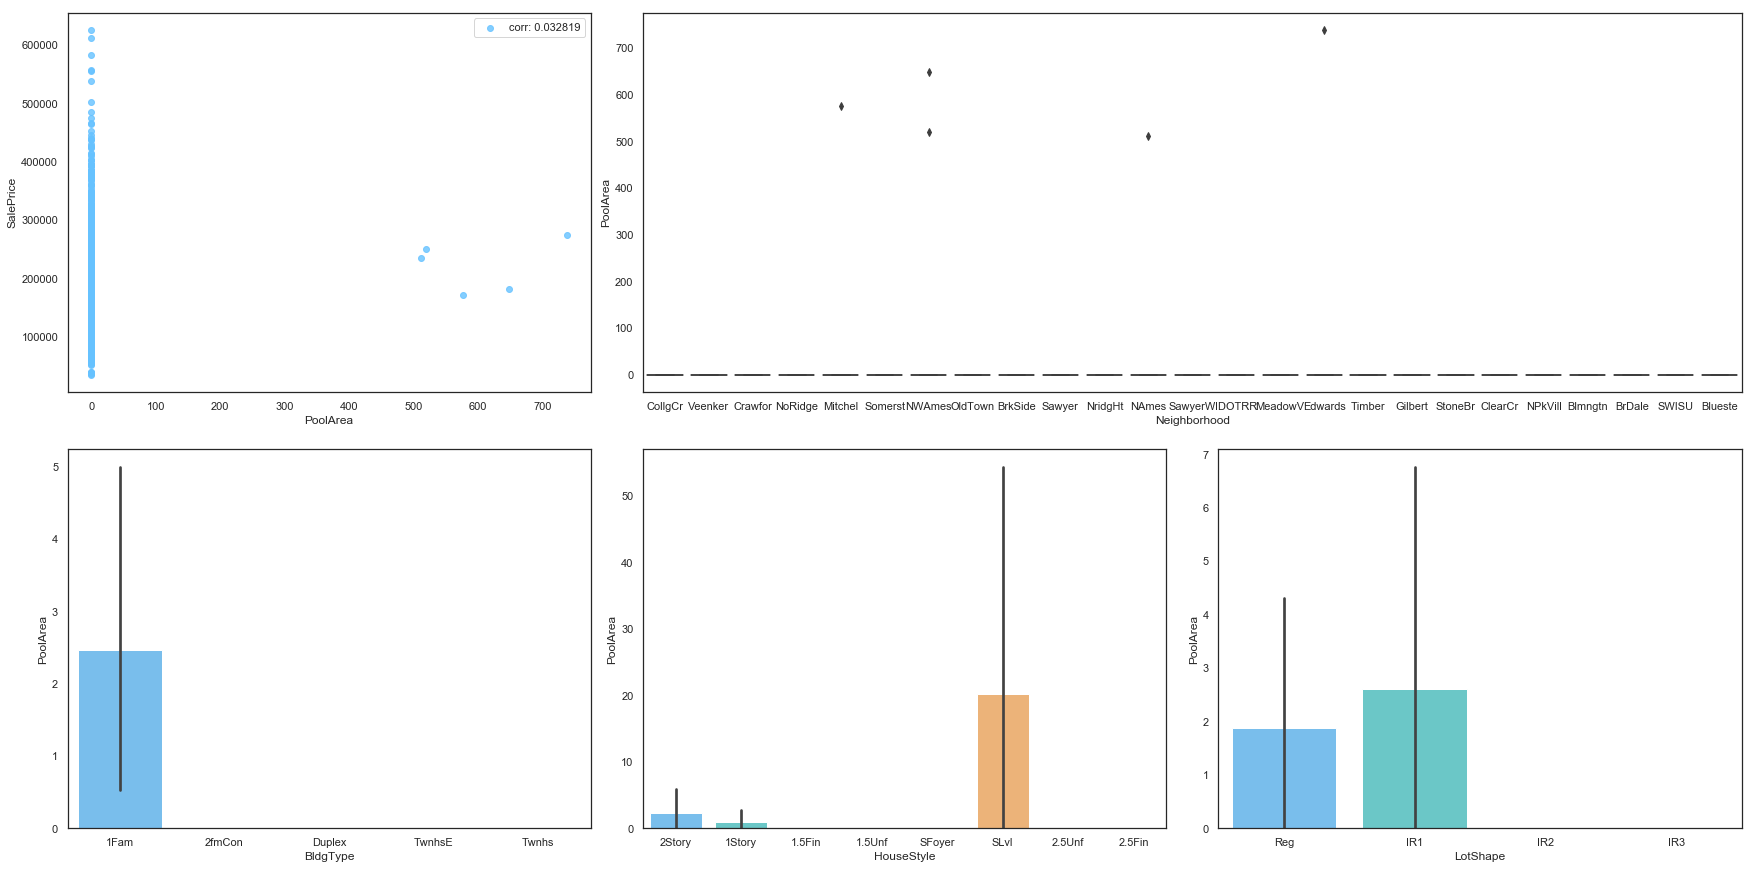

In [289]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['PoolArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['PoolArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="PoolArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="PoolArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="PoolArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="PoolArea", data=train, palette = mycols);

- Мы видим почти нулевую корреляцию из-за большого количества домов без бассейна.
- Следовательно, я создам здесь флаг.

In [290]:
def PoolFlag(col):
    if col['PoolArea'] == 0:
        return 0
    else:
        return 1
    
all_data['HasPool_Flag'] = all_data.apply(PoolFlag, axis=1)
all_data.drop('PoolArea', axis=1, inplace=True)

***PoolQC***
- Качество бассейна.

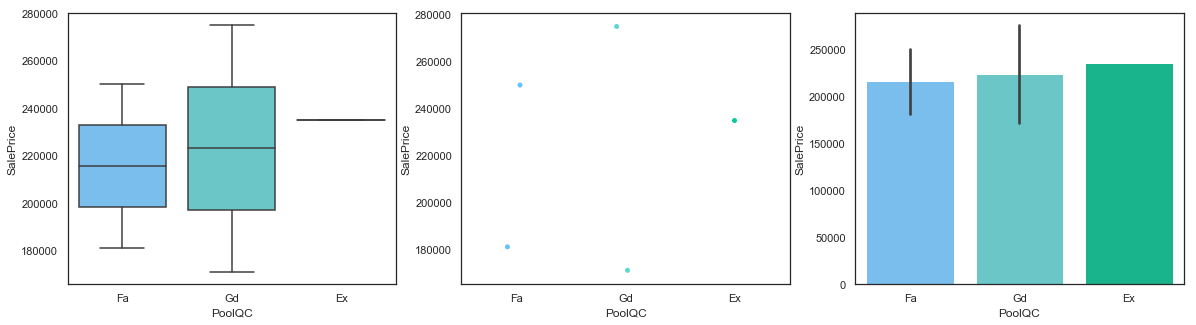

In [291]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="PoolQC", y="SalePrice", data=train, order=["Fa", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="PoolQC", y="SalePrice", data=train, size = 5, jitter = True, order=["Fa", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="PoolQC", y="SalePrice", data=train, order=["Fa", "Gd", "Ex"], palette = mycols);

- Из-за небольшого количества домов, имеющих бассейн, мы видим очень небольшое количество наблюдений для каждого класса.
- Поскольку эта переменная не содержит много информации, я просто удалю ее.

In [292]:
all_data.drop('PoolQC', axis=1, inplace=True)

***Fence***
- Качество забора.

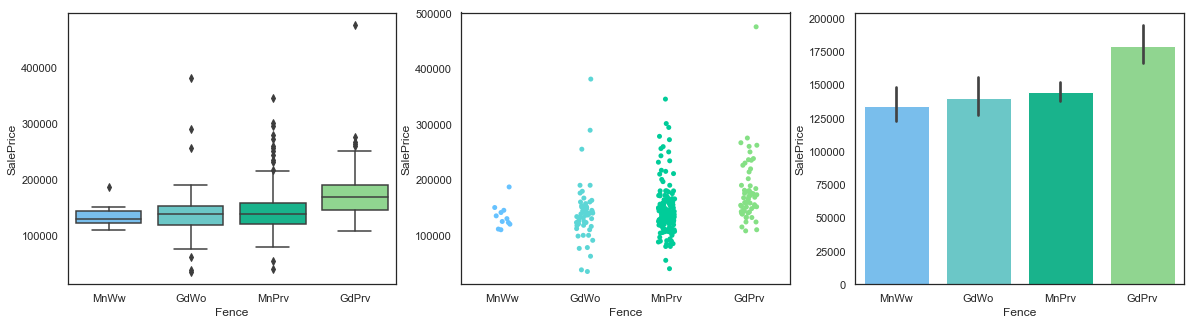

In [293]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Fence", y="SalePrice", data=train, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Fence", y="SalePrice", data=train, size = 5, jitter = True, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Fence", y="SalePrice", data=train, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"], palette = mycols);

- Здесь мы видим, что дома с наибольшей приватностью имеют самый высокий средний SalePrice.
- Кажется, в классах есть небольшой порядок, однако некоторые описания классов немного двусмысленны, поэтому я создам фиктивные переменные здесь из этой категориальной переменной.

In [294]:
all_data = pd.get_dummies(all_data, columns = ["Fence"], prefix="Fence")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical     ...      TotalPorchSF_1  \
0       Norm       Norm      SBrkr     ...                   1   
1      Feedr       Norm      SBrkr     ...                   1   
2       Norm       Norm      SBrkr     ...                   1   

   TotalPorchSF_2  TotalPorchSF_3  TotalPorchSF_4  HasPool_Flag  Fence_GdPrv  \
0               0               0               0             0            0   
1               0               0               0             0            0   
2               0               0               0             0            0   

  Fence_GdWo Fence_MnPrv  Fence_MnWw  Fence_None  
0          0           0           0           1  
1          0           0           0           1  
2          0           0           0           1  

[3 rows x 256 columns]

<a id='location'></a>
#### 4.2.5 - Локация

***MSZoning***
- Определяет общую классификацию зонирования продажи.

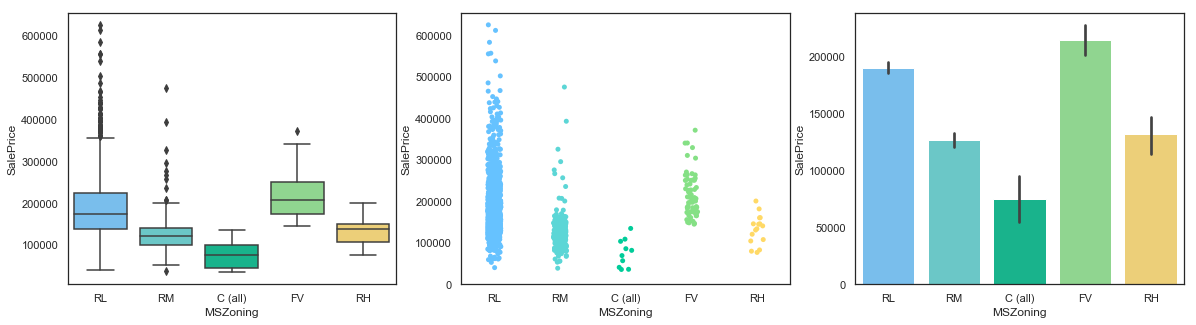

In [295]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MSZoning", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="MSZoning", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MSZoning", y="SalePrice", data=train, palette = mycols);

- Поскольку это категориальная переменная без порядка, и каждый из классов имеет очень разные диапазоны и средние значения для SalePrice, я создам здесь фиктивные переменные.

In [296]:
all_data = pd.get_dummies(all_data, columns = ["MSZoning"], prefix="MSZoning")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical     ...       Fence_GdPrv  Fence_GdWo  \
0       Norm       Norm      SBrkr     ...                 0           0   
1      Feedr       Norm      SBrkr     ...                 0           0   
2       Norm       Norm      SBrkr     ...                 0           0   

   Fence_MnPrv  Fence_MnWw  Fence_None  MSZoning_C (all) MSZoning_FV  \
0            0           0           1                 0           0   
1            0           0           1                 0           0   
2            0           0           1                 0           0   

  MSZoning_RH  MSZoning_RL  MSZoning_RM  
0           0            1            0  
1           0            1            0  
2           0            1            0  

[3 rows x 260 columns]

***Neighborhood***
- Физические местоположения в пределах города Эймса.

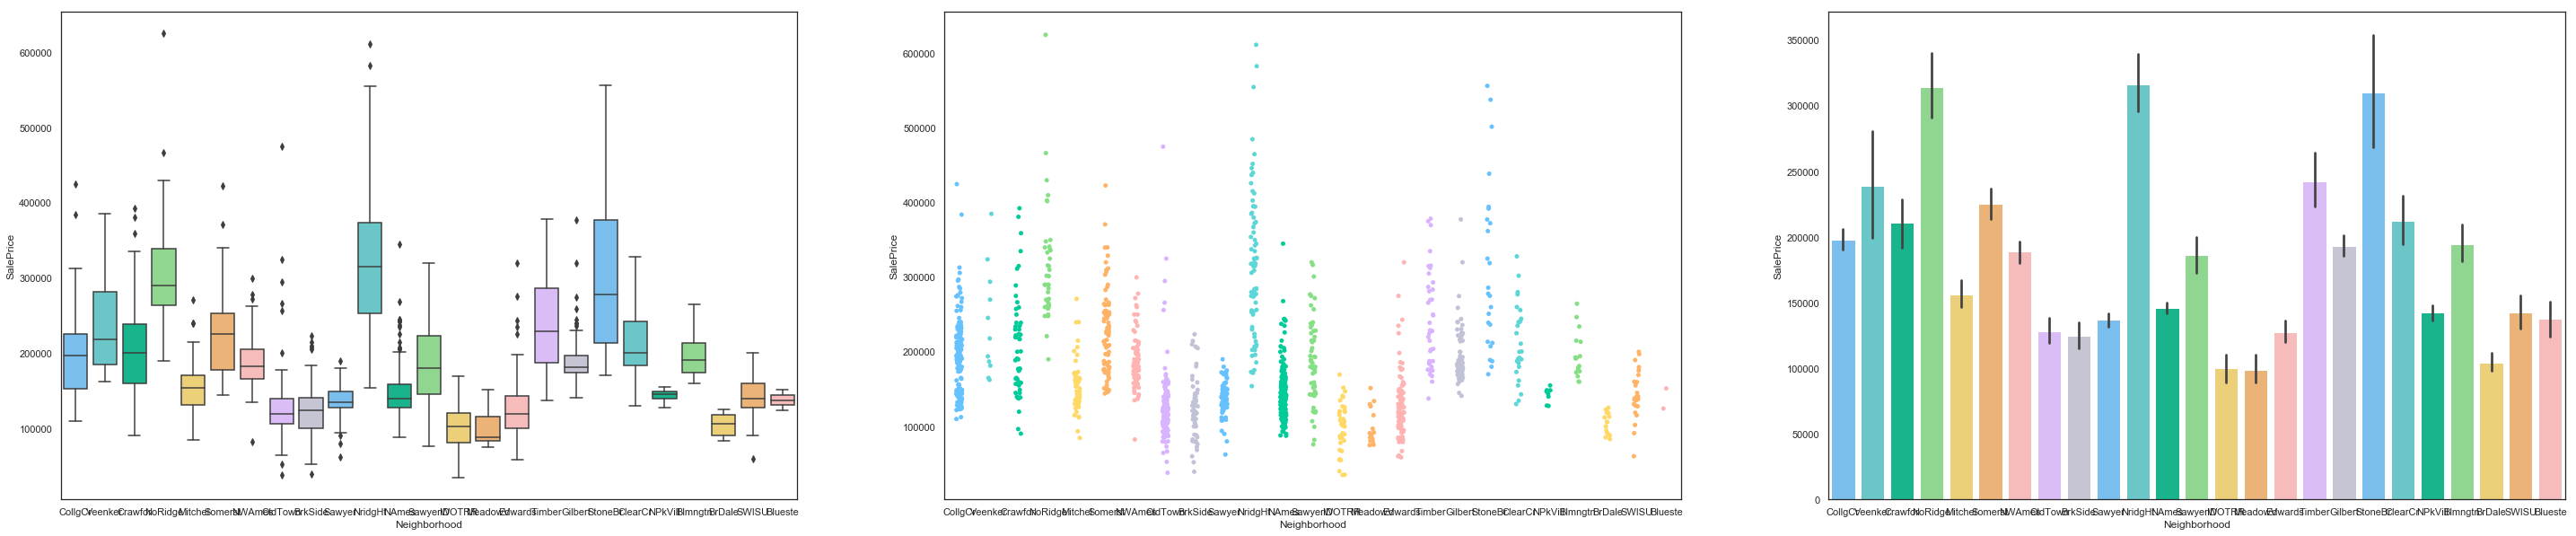

In [297]:
plt.subplots(figsize =(50, 10))

plt.subplot(1, 3, 1)
sns.boxplot(x="Neighborhood", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Neighborhood", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Neighborhood", y="SalePrice", data=train, palette = mycols);

- Соседство явно вносит важный вклад в SalePrice, так как мы видим такие высокие значения для некоторых областей и низкие значения для других.
- Поскольку это категориальная переменная без порядка, я буду создавать фиктивные переменные.

In [298]:
all_data = pd.get_dummies(all_data, columns = ["Neighborhood"], prefix="Neighborhood")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical          ...           \
0       Norm       Norm      SBrkr          ...            
1      Feedr       Norm      SBrkr          ...            
2       Norm       Norm      SBrkr          ...            

   Neighborhood_NoRidge  Neighborhood_NridgHt  Neighborhood_OldTown  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   

   Neighborhood_SWISU  Neighborhood_Sawyer  Neighborhood_SawyerW  \
0                   0                    0                     0   
1                   0                    0                     0   
2                   0                    0                     0   

  Neighborhood_Somerst Neighborhood_StoneBr  Neighborhood_Timber  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   

   Neighborhood_Veenker  
0                     0  
1                     1  
2                     0  

[3 rows x 284 columns]

***Condition1*** & ***Condition2***
- Близость к различным удобствам.

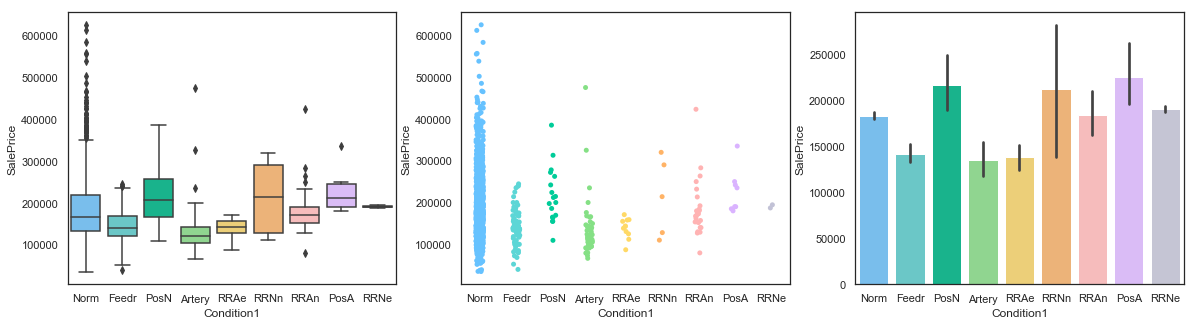

In [299]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Condition1", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Condition1", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Condition1", y="SalePrice", data=train, palette = mycols);

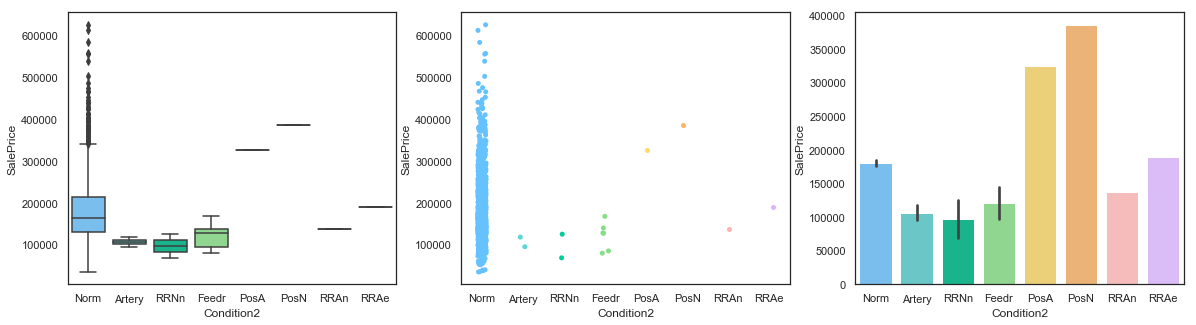

In [300]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Condition2", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Condition2", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Condition2", y="SalePrice", data=train, palette = mycols);

- Поскольку эта переменная основана на местных удобствах, понятно, что наличие более желательных вещей, таких как парки поблизости, является фактором, который будет способствовать повышению SalePrice.
- Для этой переменной я собираюсь кластеризовать классы на основе описания класса. Затем я буду создавать фиктивные перерменные.
- Затем я создам флажок «Condition2», чтобы указать, находится ли рядом условие, отличное от первого.

In [301]:
all_data['Condition1'] = all_data['Condition1'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})
all_data['Condition2'] = all_data['Condition2'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})

In [302]:
def ConditionMatch(col):
    if col['Condition1'] == col['Condition2']:
        return 0
    else:
        return 1
    
all_data['Diff2ndCondition_Flag'] = all_data.apply(ConditionMatch, axis=1)
all_data.drop('Condition2', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["Condition1"], prefix="Condition1")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual       ...         Neighborhood_SawyerW  \
0      SBrkr              0          3       ...                            0   
1      SBrkr              0          2       ...                            0   
2      SBrkr              0          3       ...                            0   

   Neighborhood_Somerst  Neighborhood_StoneBr  Neighborhood_Timber  \
0                     0                     0                    0   
1                     0                     0                    0   
2                     0                     0                    0   

  Neighborhood_Veenker Diff2ndCondition_Flag  Condition1_Norm  Condition1_Pos  \
0                    0                     0                1               0   
1                    1                     1                0               0   
2                    0                     0                1               0   

  Condition1_Street Condition1_Train  
0                 0                0  
1                 1                0  
2                 0                0  

[3 rows x 287 columns]

#### 4.2.6 - Земля

***LotFrontage***
- Линия улицы

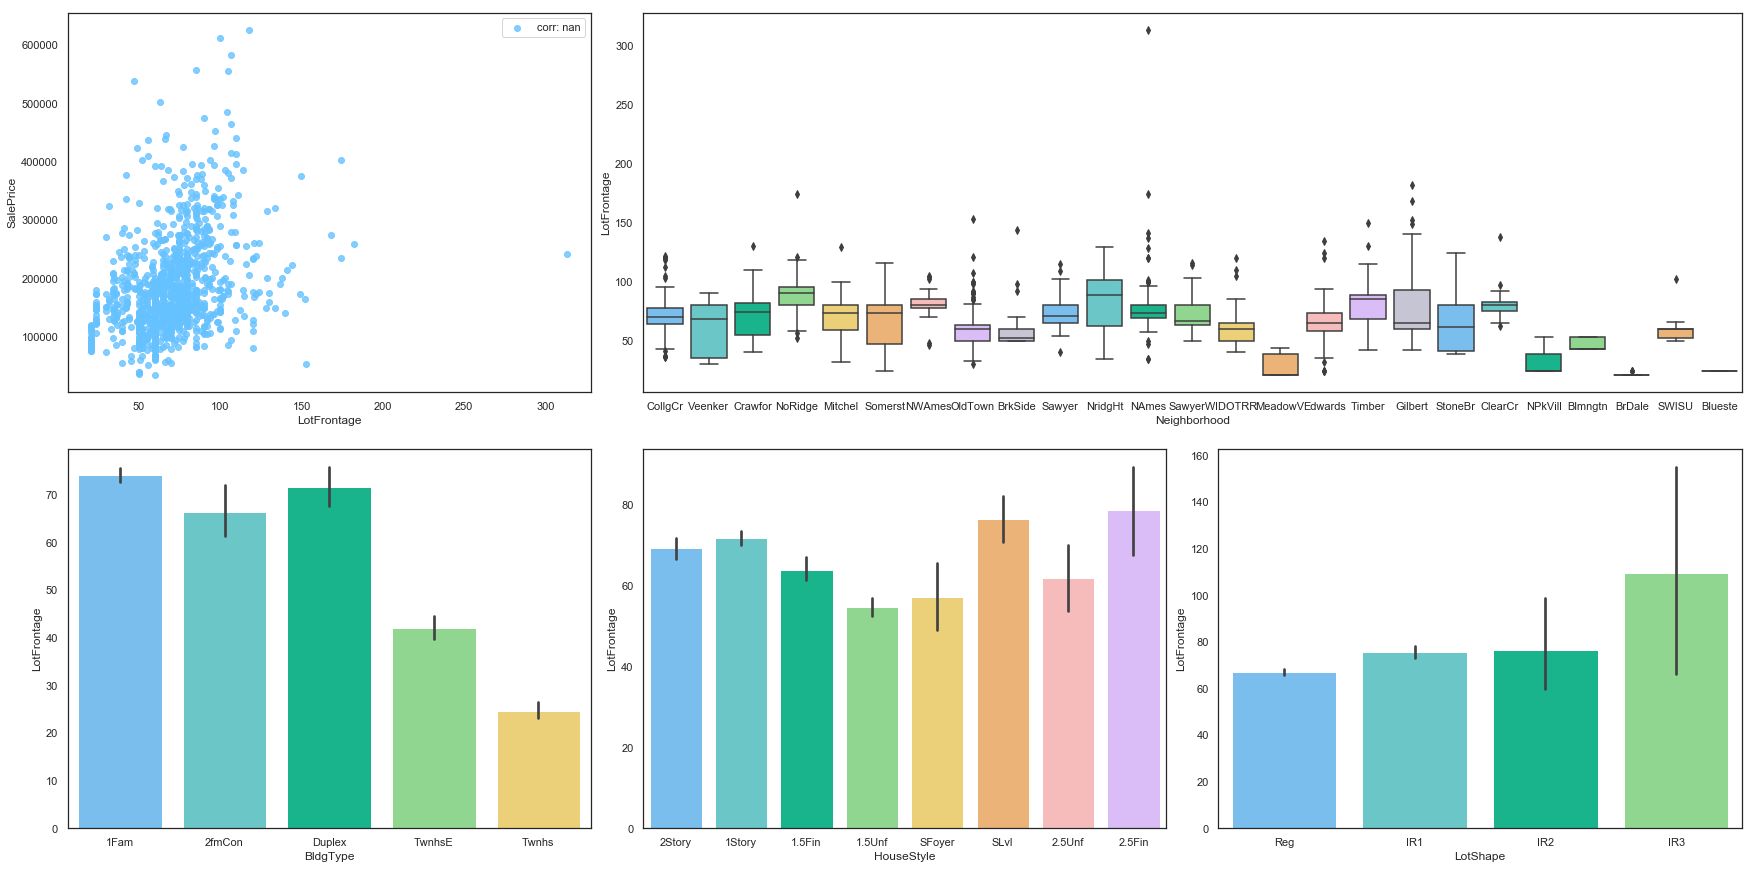

In [303]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['LotFrontage'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['LotFrontage'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="LotFrontage", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="LotFrontage", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="LotFrontage", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="LotFrontage", data=train, palette = mycols);

- Похоже, что эта переменная довольно случайно распределена по SalePrice без какой-либо значительной корреляции.
- LotFrontage, кажется, не слишком сильно зависит от «Соседства», но «BldgType», похоже, влияет на средний LotFrontage.
- Поскольку эта переменная, кажется, не имеет никакого значения для объединения в группы, я оставлю эту переменную такой, какая она есть, до тех пор, пока не масштабирую переменные.

***LotArea***
- Размер участка

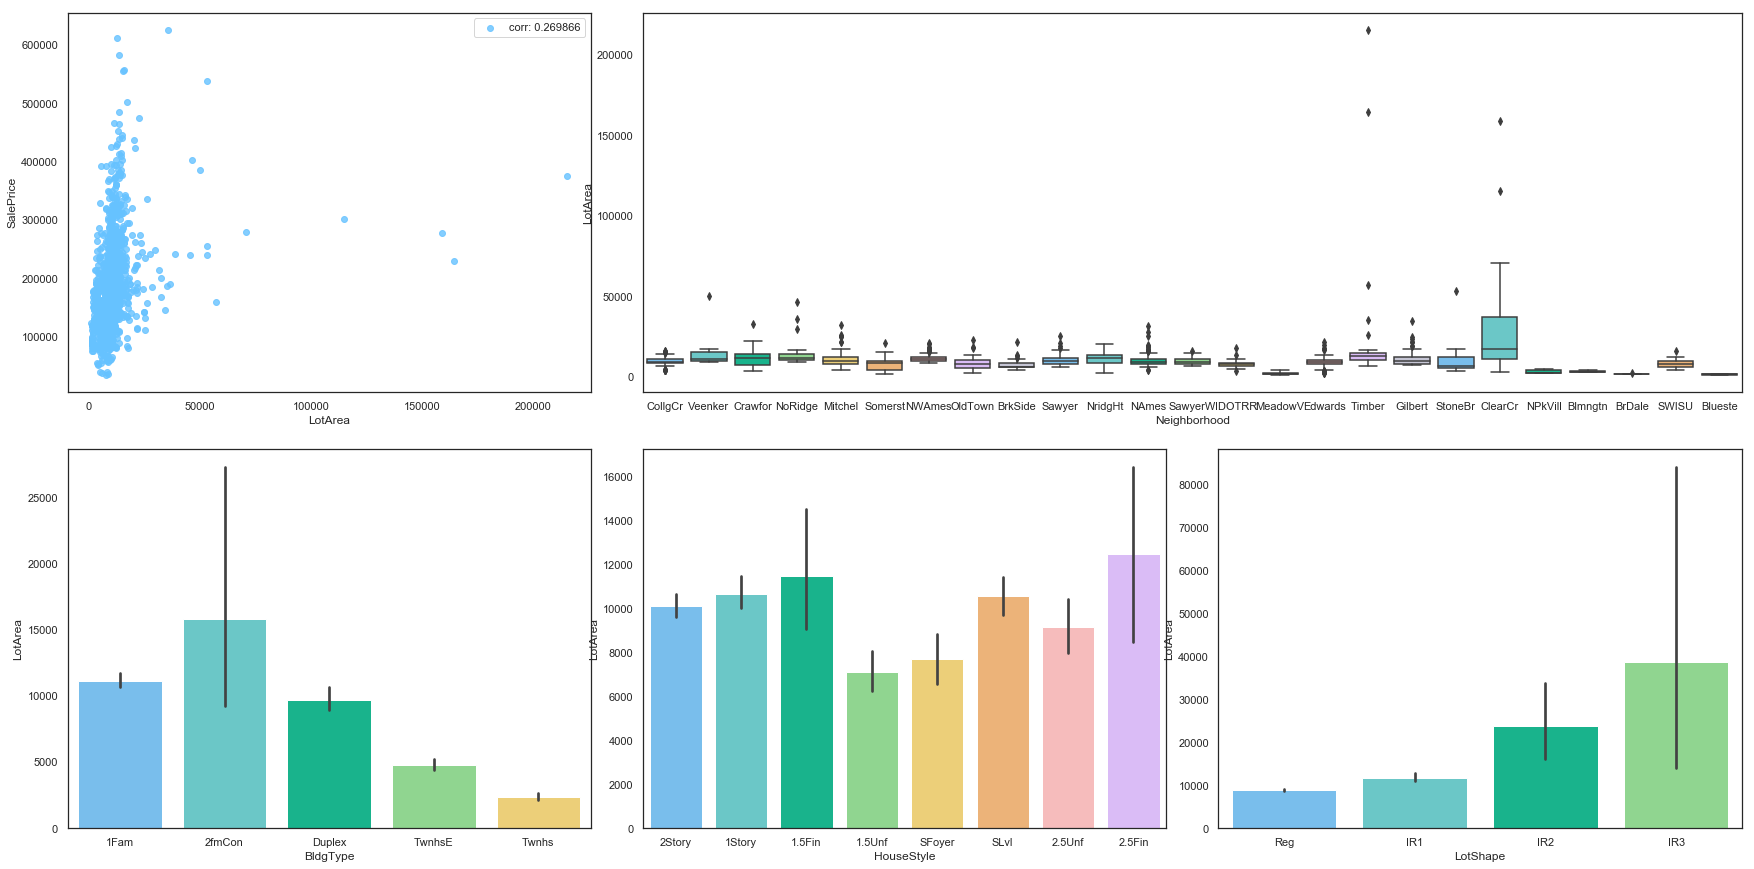

In [304]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['LotArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['LotArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="LotArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="LotArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="LotArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="LotArea", data=train, palette = mycols);

- Эта переменная показывает высокую корреляцию, но она очень положительно искажена.
- Следовательно, я буду создавать квантильные бины и фиктивные элементы. Квантильные бины не основаны на бинах примерно одинакового размера, вместо этого создаются бины с одинаковой частотой точек данных в каждом бине.

In [305]:
all_data['LotArea_Band'] = pd.qcut(all_data['LotArea'], 8)
all_data['LotArea_Band'].unique()

[(7474.0, 8520.0], (9450.0, 10355.25], (10355.25, 11554.5], (13613.0, 215245.0], (5684.75, 7474.0], (11554.5, 13613.0], (1299.999, 5684.75], (8520.0, 9450.0]]
Categories (8, interval[float64]): [(1299.999, 5684.75] < (5684.75, 7474.0] < (7474.0, 8520.0] < (8520.0, 9450.0] < (9450.0, 10355.25] < (10355.25, 11554.5] < (11554.5, 13613.0] < (13613.0, 215245.0]]

In [306]:
all_data.loc[all_data['LotArea']<=5684.75, 'LotArea'] = 1
all_data.loc[(all_data['LotArea']>5684.75) & (all_data['LotArea']<=7474), 'LotArea'] = 2
all_data.loc[(all_data['LotArea']>7474) & (all_data['LotArea']<=8520), 'LotArea'] = 3
all_data.loc[(all_data['LotArea']>8520) & (all_data['LotArea']<=9450), 'LotArea'] = 4
all_data.loc[(all_data['LotArea']>9450) & (all_data['LotArea']<=10355.25), 'LotArea'] = 5
all_data.loc[(all_data['LotArea']>10355.25) & (all_data['LotArea']<=11554.25), 'LotArea'] = 6
all_data.loc[(all_data['LotArea']>11554.25) & (all_data['LotArea']<=13613), 'LotArea'] = 7
all_data.loc[all_data['LotArea']>13613, 'LotArea'] = 8
all_data['LotArea'] = all_data['LotArea'].astype(int)

all_data.drop('LotArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["LotArea"], prefix="LotArea")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual    ...     Condition1_Street  \
0      SBrkr              0          3    ...                     0   
1      SBrkr              0          2    ...                     1   
2      SBrkr              0          3    ...                     0   

   Condition1_Train  LotArea_1  LotArea_2 LotArea_3 LotArea_4  LotArea_5  \
0                 0          0          0         1         0          0   
1                 0          0          0         0         0          1   
2                 0          0          0         0         0          0   

   LotArea_6 LotArea_7 LotArea_8  
0          0         0         0  
1          0         0         0  
2          1         0         0  

[3 rows x 294 columns]

***LotShape***
- Форма

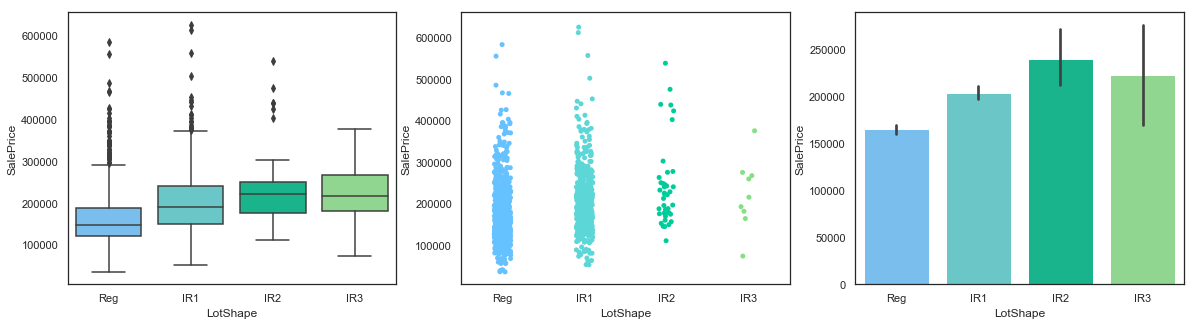

In [307]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LotShape", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LotShape", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LotShape", y="SalePrice", data=train, palette = mycols);

- Ясно, что мы видим некоторые экстремальные значения для некоторых категорий и различные SalePrice для разных классов.
- «Reg» и «IR1» имеют самую высокую частоту точек данных в них.
- Поскольку это категориальная переменная без порядка, я буду создавать фиктивные переменные.

In [308]:
all_data = pd.get_dummies(all_data, columns = ["LotShape"], prefix="LotShape")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual     ...       LotArea_3  LotArea_4  \
0      SBrkr              0          3     ...               1          0   
1      SBrkr              0          2     ...               0          0   
2      SBrkr              0          3     ...               0          0   

   LotArea_5  LotArea_6 LotArea_7 LotArea_8  LotShape_IR1  LotShape_IR2  \
0          0          0         0         0             0             0   
1          1          0         0         0             0             0   
2          0          1         0         0             1             0   

  LotShape_IR3 LotShape_Reg  
0            0            1  
1            0            1  
2            0            0  

[3 rows x 297 columns]

***LandContour***
- Плоскость

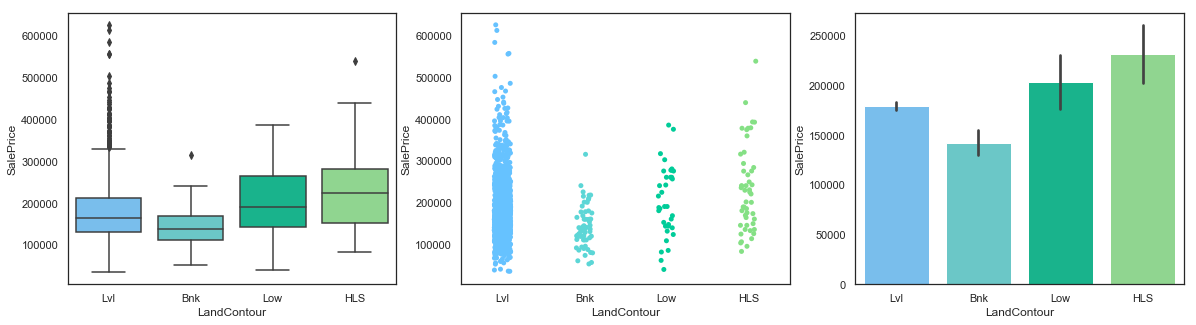

In [309]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LandContour", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LandContour", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LandContour", y="SalePrice", data=train, palette = mycols);

- Большинство домов действительно имеют плоский контур, однако дома с самой высокой SalePrice, похоже, интересны из свойств на холме.
- Поскольку это категориальная переменная без порядка, я буду создавать фиктивные переменные.

In [310]:
all_data = pd.get_dummies(all_data, columns = ["LandContour"], prefix="LandContour")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual       ...        LotArea_7  LotArea_8  \
0      SBrkr              0          3       ...                0          0   
1      SBrkr              0          2       ...                0          0   
2      SBrkr              0          3       ...                0          0   

   LotShape_IR1  LotShape_IR2 LotShape_IR3 LotShape_Reg  LandContour_Bnk  \
0             0             0            0            1                0   
1             0             0            0            1                0   
2             1             0            0            0                0   

   LandContour_HLS LandContour_Low LandContour_Lvl  
0                0               0               1  
1                0               0               1  
2                0               0               1  

[3 rows x 300 columns]

***LotConfig***
- Конфигурация

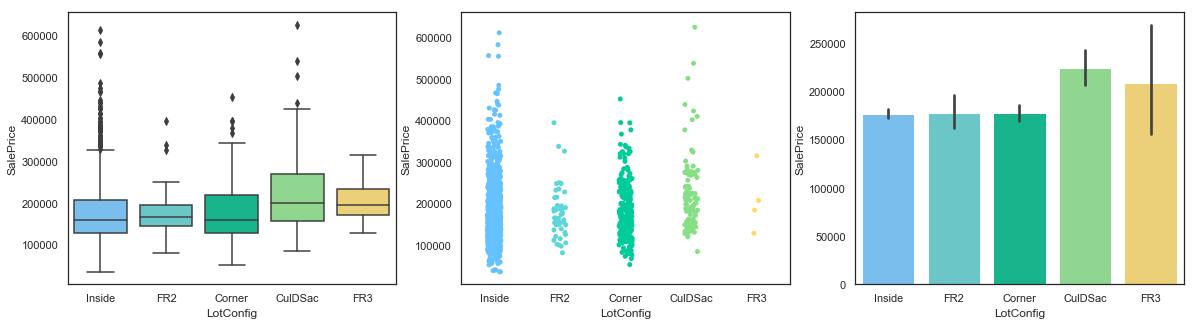

In [311]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LotConfig", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LotConfig", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LotConfig", y="SalePrice", data=train, palette = mycols);

- Culdesac's, кажется, имеют самые высокие средние цены, однако большинство домов расположены внутри или на углу участка.
- Чтобы упростить эту переменную, я буду кластеризовать «FR2» и «FR3», а затем создам фиктивные переменные.

In [312]:
all_data['LotConfig'] = all_data['LotConfig'].map({"Inside":"Inside", "FR2":"FR", "Corner":"Corner", "CulDSac":"CulDSac", "FR3":"FR"})

all_data = pd.get_dummies(all_data, columns = ["LotConfig"], prefix="LotConfig")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual        ...         LotShape_IR3  \
0      SBrkr              0          3        ...                    0   
1      SBrkr              0          2        ...                    0   
2      SBrkr              0          3        ...                    0   

   LotShape_Reg  LandContour_Bnk  LandContour_HLS LandContour_Low  \
0             1                0                0               0   
1             1                0                0               0   
2             0                0                0               0   

  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac LotConfig_FR  \
0               1                 0                  0            0   
1               1                 0                  0            1   
2               1                 0                  0            0   

   LotConfig_Inside  
0                 1  
1                 0  
2                 1  

[3 rows x 303 columns]

***LandSlope***
- Уклон

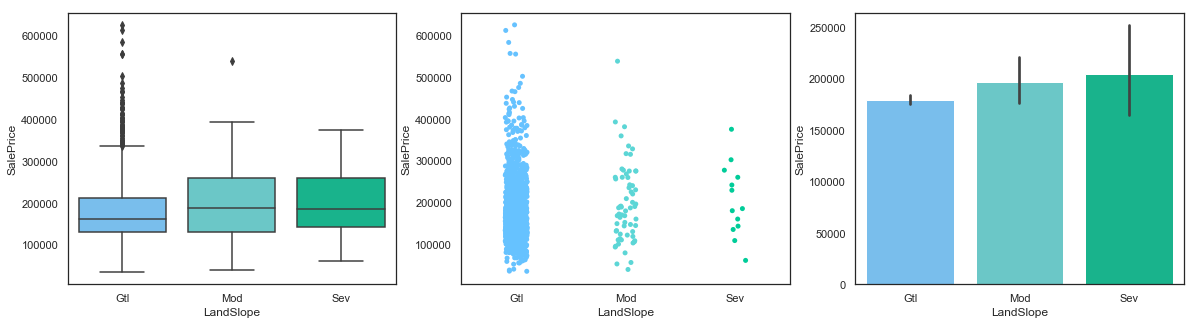

In [313]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LandSlope", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LandSlope", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LandSlope", y="SalePrice", data=train, palette = mycols);

- Мы видим, что большинство домов имеют пологий склон, и в целом склон, похоже, не оказывает большого влияния на SalePrice.
- Следовательно, я собираюсь кластеризовать «Mod» и «Sev», чтобы создать один класс, и создать новый флаг, чтобы указать небольшой уклон или нет.

In [314]:
all_data['LandSlope'] = all_data['LandSlope'].map({"Gtl":1, "Mod":2, "Sev":2})

In [315]:
def Slope(col):
    if col['LandSlope'] == 1:
        return 1
    else:
        return 0
    
all_data['GentleSlope_Flag'] = all_data.apply(Slope, axis=1)
all_data.drop('LandSlope', axis=1, inplace=True)

<a id='access'></a>
#### 4.2.7 - Доступ

***Street***
- Тип дорожного доступа к недвижимости.

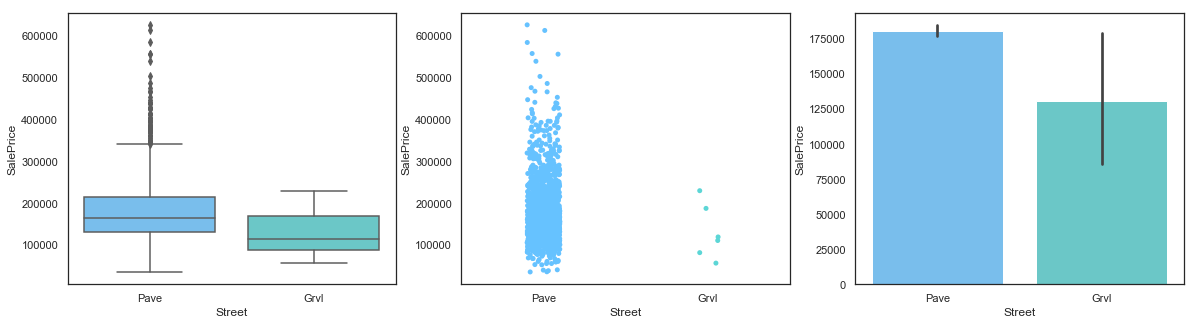

In [316]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Street", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Street", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Street", y="SalePrice", data=train, palette = mycols);

- При таком маленьком количестве наблюдений, присваиваемых классу "Grvl", это избыточно в модели.
- Следовательно, я удалю эту переменнуб.

In [317]:
all_data.drop('Street', axis=1, inplace=True)

***Alley***
- Тип переулка

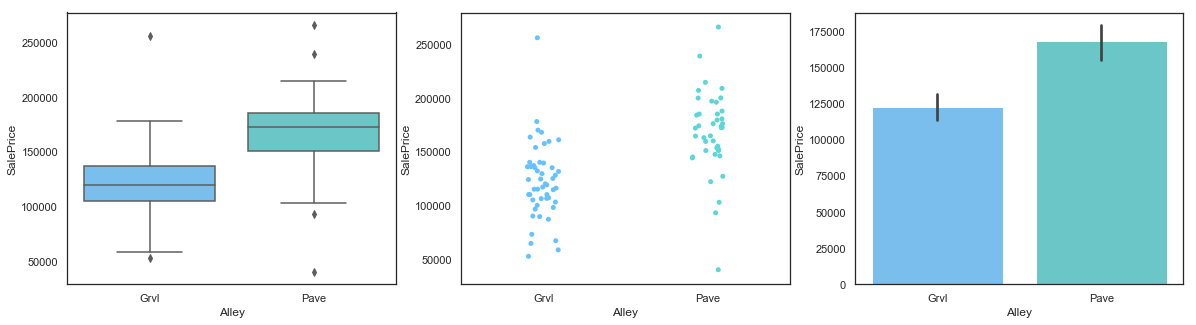

In [318]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Alley", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Alley", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Alley", y="SalePrice", data=train, palette = mycols);

- Здесь мы видим довольно равномерное разделение между двумя классами по частоте, но гораздо более высокий средний SalePrice для мощеных аллей, чем для гравийных.
- Следовательно, кажется, что это может быть хорошим предиктором. Я буду создавать фиктивные переменные из этого.

In [319]:
all_data = pd.get_dummies(all_data, columns = ["Alley"], prefix="Alley")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0             3         3             1         3          Y   
1          0             3         3             4         3          Y   
2          0             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  FireplaceQu     ...      \
0      SBrkr              0          3            0     ...       
1      SBrkr              0          2            3     ...       
2      SBrkr              0          3            3     ...       

   LandContour_Low  LandContour_Lvl  LotConfig_Corner LotConfig_CulDSac  \
0                0                1                 0                 0   
1                0                1                 0                 0   
2                0                1                 0                 0   

  LotConfig_FR  LotConfig_Inside  GentleSlope_Flag  Alley_Grvl Alley_None  \
0            0                 1                 1           0          1   
1            1                 0                 1           0          1   
2            0                 1                 1           0          1   

   Alley_Pave  
0           0  
1           0  
2           0  

[3 rows x 304 columns]

***PavedDrive***
- Проложенная дорога.

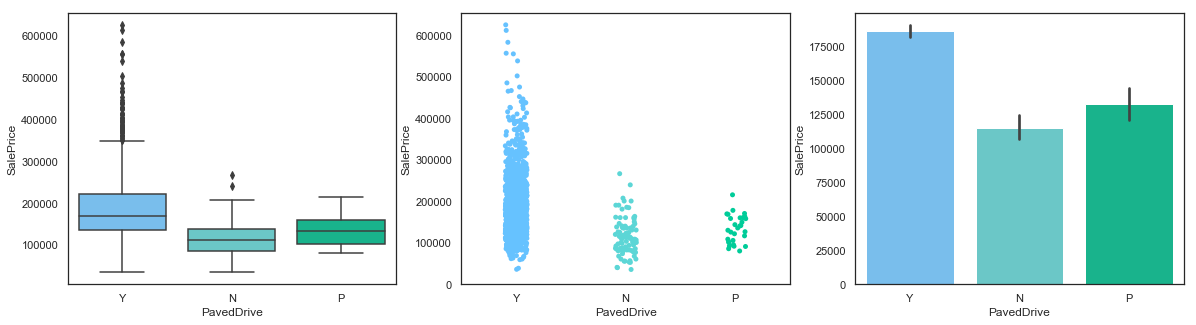

In [320]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="PavedDrive", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="PavedDrive", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="PavedDrive", y="SalePrice", data=train, palette = mycols);

- Здесь мы видим самую высокую среднюю цену, требуемую от домов с асфальтированной подъездной дорогой, и большинство домов в этом районе, кажется, имеют такую.
- Поскольку это категориальная переменная без порядка, я создам фиктивные переменные.

In [321]:
all_data = pd.get_dummies(all_data, columns = ["PavedDrive"], prefix="PavedDrive")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0             3         3             1         3          Y   
1          0             3         3             4         3          Y   
2          0             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  FireplaceQu      ...       \
0      SBrkr              0          3            0      ...        
1      SBrkr              0          2            3      ...        
2      SBrkr              0          3            3      ...        

   LotConfig_CulDSac  LotConfig_FR  LotConfig_Inside GentleSlope_Flag  \
0                  0             0                 1                1   
1                  0             1                 0                1   
2                  0             0                 1                1   

  Alley_Grvl  Alley_None  Alley_Pave  PavedDrive_N PavedDrive_P  PavedDrive_Y  
0          0           1           0             0            0             1  
1          0           1           0             0            0             1  
2          0           1           0             0            0             1  

[3 rows x 306 columns]

<a id='utilities'></a>
#### 4.2.8 - Utilities

***Heating***
- Тип отопления

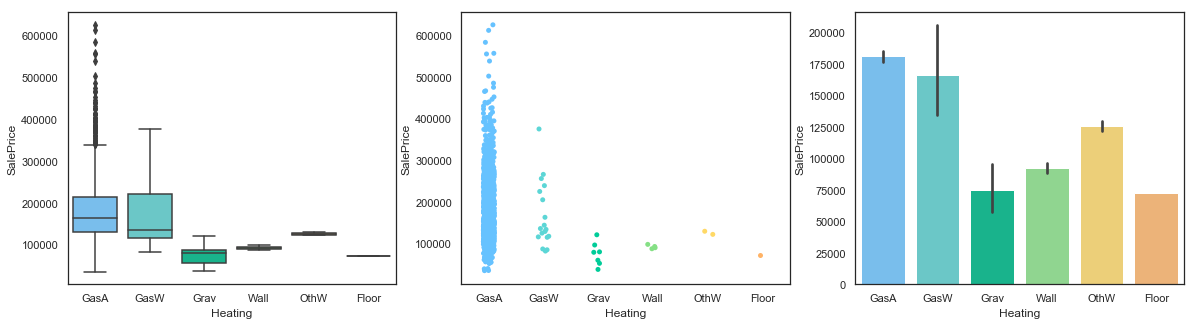

In [322]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Heating", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Heating", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Heating", y="SalePrice", data=train, palette = mycols);

- Мы видим самую высокую частоту и самую высокую среднюю SalePrice, поступающую от «GasA» и очень низкую частоту от всех других классов.
- Следовательно, я создам флаг, чтобы указать, присутствует ли «GasA» или нет.

In [323]:
all_data['GasA_Flag'] = all_data['Heating'].map({"GasA":1, "GasW":0, "Grav":0, "Wall":0, "OthW":0, "Floor":0})
all_data.drop('Heating', axis=1, inplace=True)
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0             3         3             1         3          Y   
1          0             3         3             4         3          Y   
2          0             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  FireplaceQu    ...      LotConfig_FR  \
0      SBrkr              0          3            0    ...                 0   
1      SBrkr              0          2            3    ...                 1   
2      SBrkr              0          3            3    ...                 0   

   LotConfig_Inside  GentleSlope_Flag Alley_Grvl  Alley_None  Alley_Pave  \
0                 1                 1          0           1           0   
1                 0                 1          0           1           0   
2                 1                 1          0           1           0   

   PavedDrive_N PavedDrive_P  PavedDrive_Y  GasA_Flag  
0             0            0             1          1  
1             0            0             1          1  
2             0            0             1          1  

[3 rows x 306 columns]

***HeatingQC***
- Качество и состояние отопления.

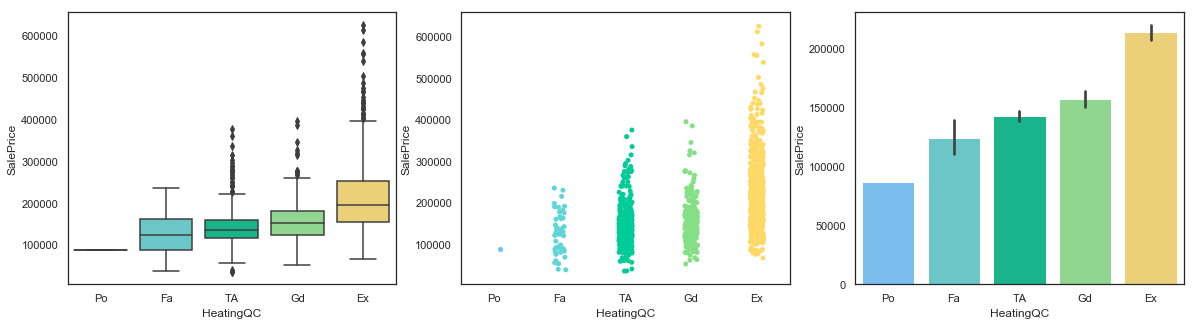

In [324]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="HeatingQC", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="HeatingQC", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="HeatingQC", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

- Здесь мы видим положительную корреляцию с SalePrice при повышении качества отопления. С «Ex» приносит самый высокий средний SalePrice.
- Мы также видим большое количество домов с таким качеством отопления, что означает, что в большинстве домов было очень хорошее отопление!
- Это категориальная переменная, однако, поскольку она демонстрирует порядок, я заменю значения вручную числами.

In [325]:
all_data['HeatingQC'] = all_data['HeatingQC'].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['HeatingQC'].unique()

array([5, 4, 3, 2, 1], dtype=int64)

***CentralAir***
- Центральный кондиционер.

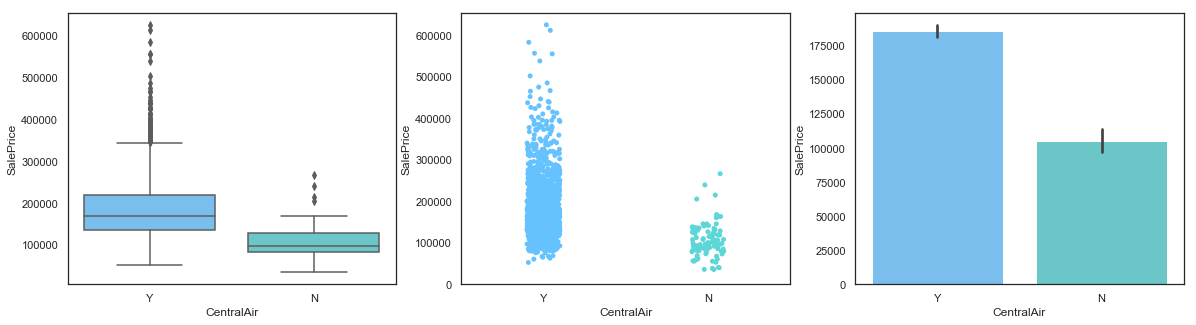

In [326]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="CentralAir", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="CentralAir", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="CentralAir", y="SalePrice", data=train, palette = mycols);

- Мы видим, что дома с центральным кондиционированием могут потребовать более высокую среднюю цену продажи, чем дома без нее.
- Для этой переменной я просто заменю категории номерами 0 и 1.

In [327]:
all_data['CentralAir'] = all_data['CentralAir'].map({"Y":1, "N":0})
all_data['CentralAir'].unique()

array([1, 0], dtype=int64)

***Electrical***
- Электрическая система.

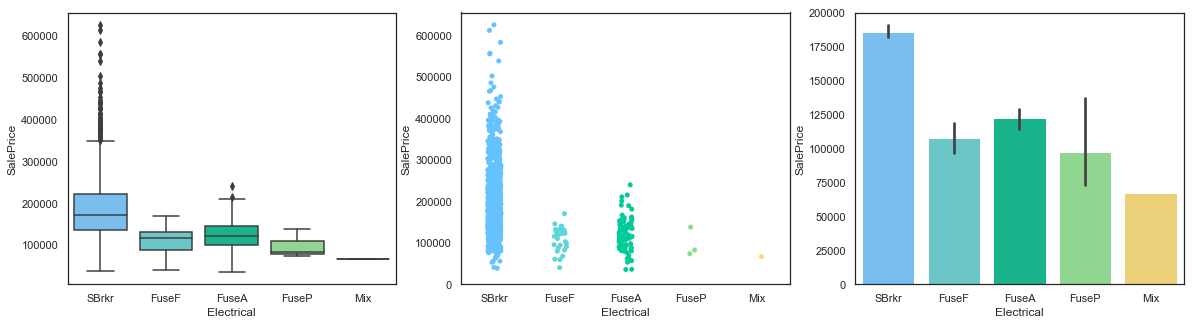

In [328]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Electrical", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Electrical", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Electrical", y="SalePrice", data=train, palette = mycols);

- Мы видим самый высокий средний SalePrice, приходящийся на дома с электричеством «SBrkr», и это также самые частые электрические системы, установленные в домах из этого района.
- У нас есть две категории, которые имеют очень низкие частоты: «FuseP» и «Mix».
- Я собираюсь объединить все классы, связанные с предохрантелями, и класс «Mix», вероятно, будет удален во время  feature reduction.

In [329]:
all_data['Electrical'] = all_data['Electrical'].map({"SBrkr":"SBrkr", "FuseF":"Fuse", "FuseA":"Fuse", "FuseP":"Fuse", "Mix":"Mix"})

all_data = pd.get_dummies(all_data, columns = ["Electrical"], prefix="Electrical")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces        ...         \
0              0          3            0           0        ...          
1              0          2            3           1        ...          
2              0          3            3           1        ...          

   Alley_Grvl  Alley_None  Alley_Pave  PavedDrive_N  PavedDrive_P  \
0           0           1           0             0             0   
1           0           1           0             0             0   
2           0           1           0             0             0   

   PavedDrive_Y GasA_Flag  Electrical_Fuse  Electrical_Mix  Electrical_SBrkr  
0             1         1                0               0                 1  
1             1         1                0               0                 1  
2             1         1                0               0                 1  

[3 rows x 308 columns]

<a id='miscellaneous'></a>
#### 4.2.9 - Остальное

***MiscFeature***
- Разные переменные, не относящиеся к другим категориям.

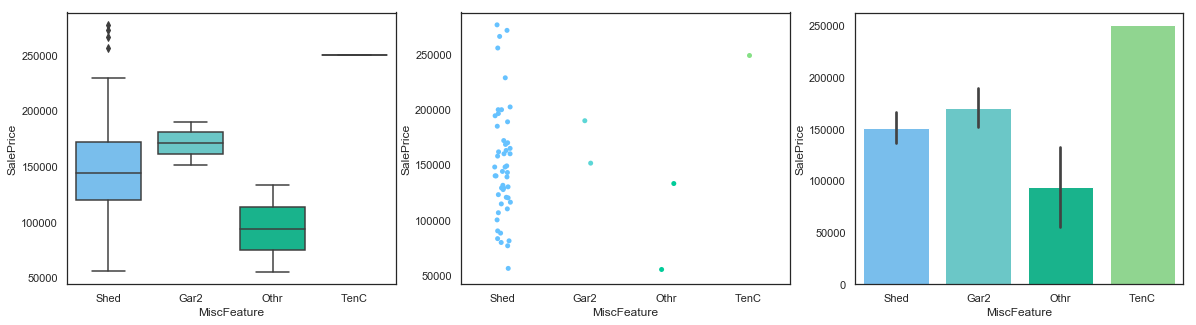

In [330]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MiscFeature", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="MiscFeature", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MiscFeature", y="SalePrice", data=train, palette = mycols);

- Мы можем видеть здесь, что только небольшое количество домов в этом районе с какими-то ошибочными признаками. Следовательно, я не верю, что эта функция имеет большое значение.
- Поэтому удаление вместе с MiscVal.

In [331]:
columns=['MiscFeature', 'MiscVal']
all_data.drop(columns, axis=1, inplace=True)

***MoSold***
- Месяц продажи (ММ).

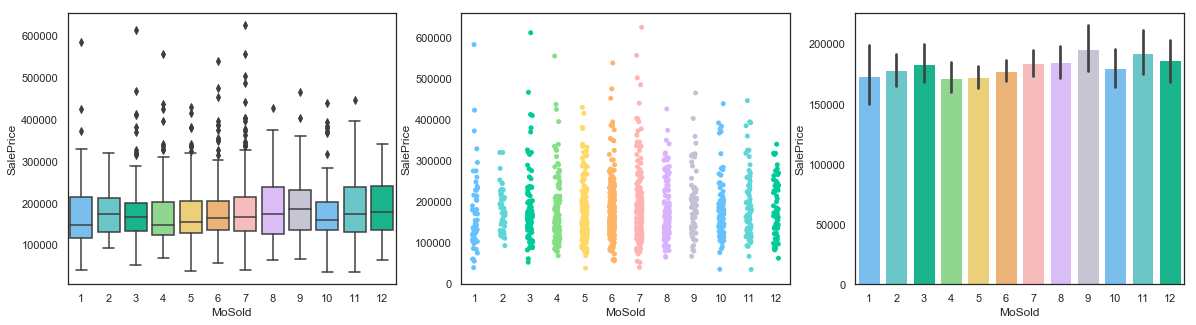

In [332]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MoSold", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="MoSold", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MoSold", y="SalePrice", data=train, palette = mycols);

- Хотя эта функция является числовой, она действительно должна быть категориальной
- Мы можем видеть, что нет никаких реальных показателей в отношении каких-либо месяцев, когда продавались дома по более высокой цене, однако, как представляется, существует довольно равномерное распределение ценностей между классами.
- Я создам фиктивные переменные из каждой категории.

In [333]:
all_data = pd.get_dummies(all_data, columns = ["MoSold"], prefix="MoSold")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces    ...     MoSold_3  \
0              0          3            0           0    ...            0   
1              0          2            3           1    ...            0   
2              0          3            3           1    ...            0   

   MoSold_4  MoSold_5  MoSold_6  MoSold_7  MoSold_8  MoSold_9  MoSold_10  \
0         0         0         0         0         0         0          0   
1         0         1         0         0         0         0          0   
2         0         0         0         0         0         1          0   

   MoSold_11 MoSold_12  
0          0         0  
1          0         0  
2          0         0  

[3 rows x 317 columns]

***YrSold***
- Год продажи (ГГГГ).

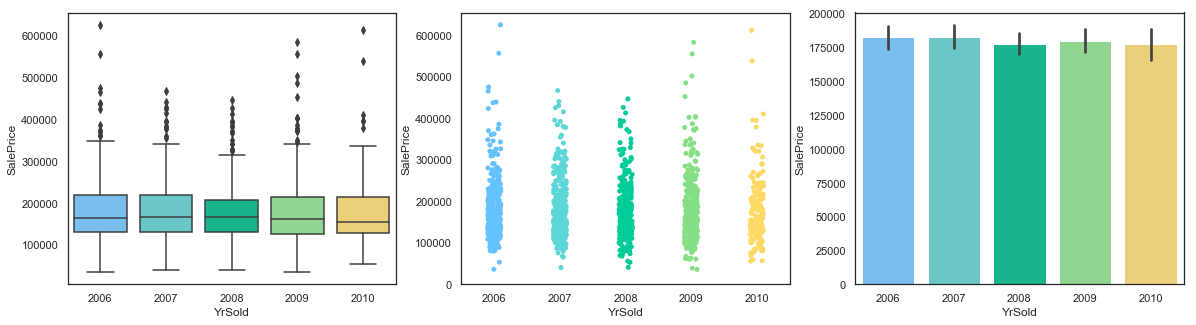

In [334]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="YrSold", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="YrSold", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="YrSold", y="SalePrice", data=train, palette = mycols);

- Здесь мы видим только 5-летний период, в течение которого дома в этом наборе данных были проданы.
- Существует равномерное распределение значений между каждым классом, и каждый год имеет очень похожий средний SalePrice.
- Хотя это числовое значение, оно должно быть категориальным. Поэтому я буду создавать фиктивные переменные.

In [335]:
all_data = pd.get_dummies(all_data, columns = ["YrSold"], prefix="YrSold")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces     ...      MoSold_8  \
0              0          3            0           0     ...             0   
1              0          2            3           1     ...             0   
2              0          3            3           1     ...             0   

   MoSold_9  MoSold_10  MoSold_11  MoSold_12  YrSold_2006  YrSold_2007  \
0         0          0          0          0            0            0   
1         0          0          0          0            0            1   
2         1          0          0          0            0            0   

   YrSold_2008  YrSold_2009 YrSold_2010  
0            1            0           0  
1            0            0           0  
2            1            0           0  

[3 rows x 321 columns]

***SaleType***
- Тип продажи.

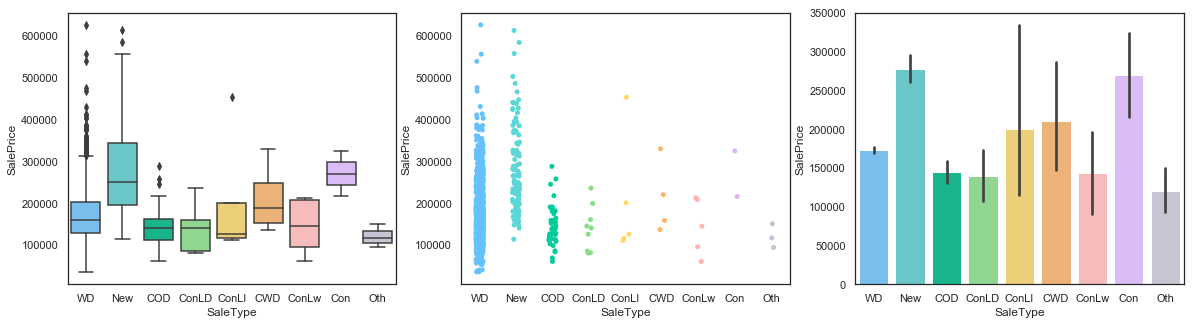

In [336]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="SaleType", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="SaleType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="SaleType", y="SalePrice", data=train, palette = mycols);

- Большинство домов было продано в категории «WD», что является обычной продажей, однако самая высокая SalePrice была замечена среди домов, которые были проданы как дома, которые были совершенно новыми и только что проданы.
- Для этой переменной я сгруппирую несколько категорий вместе, а затем создам фиктивные элементы.

In [337]:
all_data['SaleType'] = all_data['SaleType'].map({"WD":"WD", "New":"New", "COD":"COD", "CWD":"CWD", "ConLD":"Oth", "ConLI":"Oth", 
                                                 "ConLw":"Oth", "Con":"Oth", "Oth":"Oth"})

all_data = pd.get_dummies(all_data, columns = ["SaleType"], prefix="SaleType")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces     ...      YrSold_2006  \
0              0          3            0           0     ...                0   
1              0          2            3           1     ...                0   
2              0          3            3           1     ...                0   

   YrSold_2007  YrSold_2008  YrSold_2009  YrSold_2010  SaleType_COD  \
0            0            1            0            0             0   
1            1            0            0            0             0   
2            0            1            0            0             0   

   SaleType_CWD  SaleType_New  SaleType_Oth SaleType_WD  
0             0             0             0           1  
1             0             0             0           1  
2             0             0             0           1  

[3 rows x 325 columns]

***SaleCondition***
- Условия продажи.

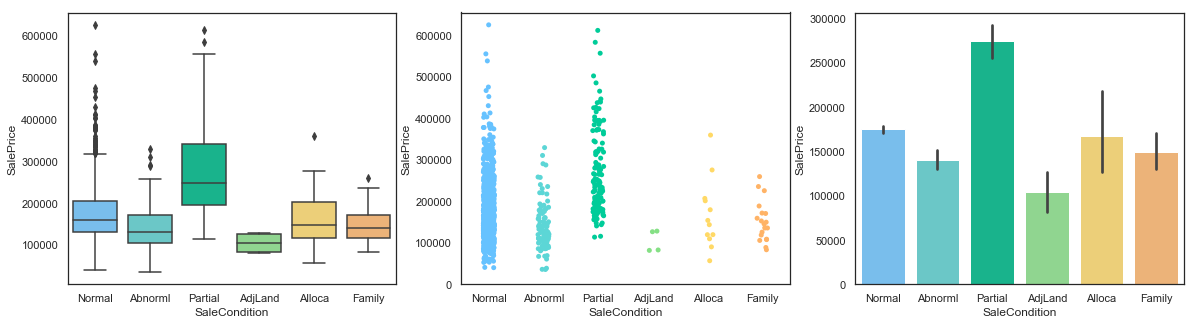

In [338]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="SaleCondition", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="SaleCondition", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="SaleCondition", y="SalePrice", data=train, palette = mycols);

- Здесь мы видим, что самая большая средняя SalePrice связана с частичными продажами, а самая частая продажа - это нормальные продажи.
- Поскольку это категориальная переменная без порядка, я буду создавать фиктивные переменные.

In [339]:
all_data = pd.get_dummies(all_data, columns = ["SaleCondition"], prefix="SaleCondition")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces          ...            \
0              0          3            0           0          ...             
1              0          2            3           1          ...             
2              0          3            3           1          ...             

   SaleType_CWD  SaleType_New  SaleType_Oth  SaleType_WD  \
0             0             0             0            1   
1             0             0             0            1   
2             0             0             0            1   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  

[3 rows x 330 columns]

***

<a id='target_variable'></a>
### 4.3 - Целевая переменная

- В отличие от классификации ** в регрессии мы предсказываем непрерывное число **. Следовательно, прогноз может быть любым числом вдоль линии действительного числа.
- Поэтому при построении регрессионной модели всегда полезно проверять распределение целевой переменной и даже всех числовых переменных. Алгоритмы машинного обучения хорошо работают с функциями, которые ** нормально распределены **, распределением, которое симметрично и имеет характерную форму колокольчика. Если объекты обычно не нормально распределены, вы можете преобразовать их, используя умные статистические методы.
- Сначала давайте проверим целевую переменную.

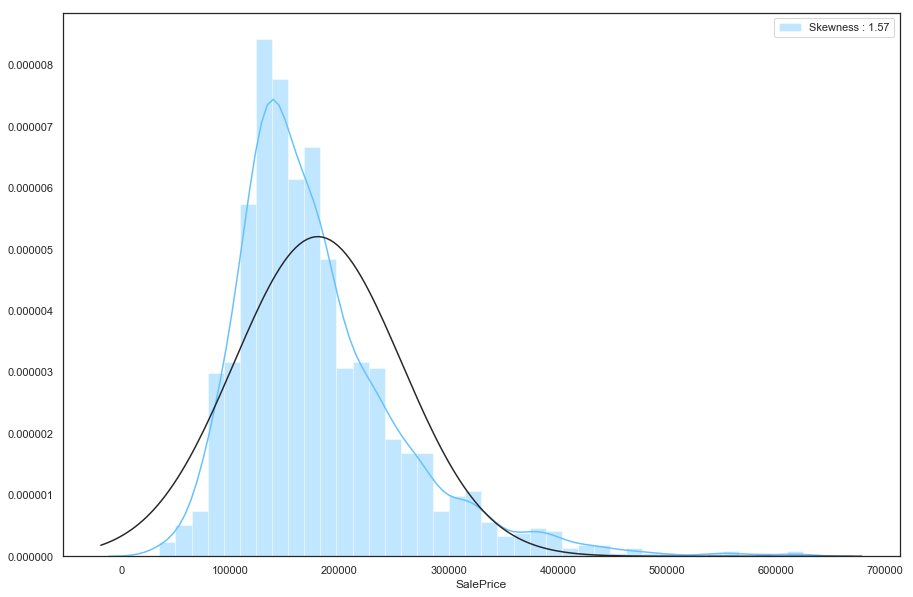

In [340]:
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

Распределение целевой переменной ** положительно смещена **, что означает, что мода всегда меньше, чем среднее значение и медиана.

- Чтобы преобразовать эту переменную в распределение, которое выглядит ближе к черной линии, показанной выше, мы можем использовать ** функцию numpy log1p **, которая применяет log (1 + x) ко всем элементам в функции.

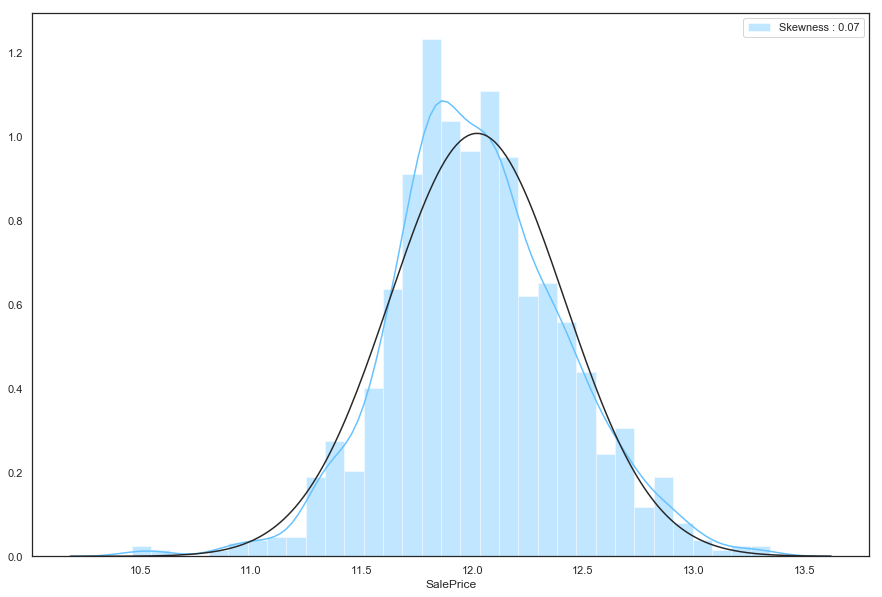

In [341]:
#Мы используем функцию numpy log1p, которая применяет log (1 + x) ко всем элементам столбца.
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train["SalePrice"]

#Проверяеем новое распределение
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

Из асимметрии и графика видно, что теперь оно гораздо ближе к нормальному распределению. ** Это поможет алгоритмам работать максимально надежно, потому что теперь мы предсказываем хорошо известное распределение, то есть нормальное распределение **. Если распределение ваших данных приближается к распределению теоретического распределения, мы можем выполнить вычисления на основе данных, основанных на допущениях этого известного распределения.

- *** Примечание: *** Теперь, когда мы преобразовали целевую переменную, это означает, что прогноз, который мы создаем, также будет в форме этого преобразования. Если только мы не сможем вернуть это преобразование ...

***

<a id='treating_skewed_features'></a>
### 4.4 - Лечение перекошенных признаков

Как уже упоминалось ранее, перекос числовых переменных нежелателен при использовании алгоритмов машинного обучения. Причина, по которой мы хотим сделать это, заключается в том, чтобы отвести фокус моделей от любых экстремальных значений, чтобы создать обобщенное решение. Мы можем приручить эти экстремальные значения, трансформировав перекошенные признаки.

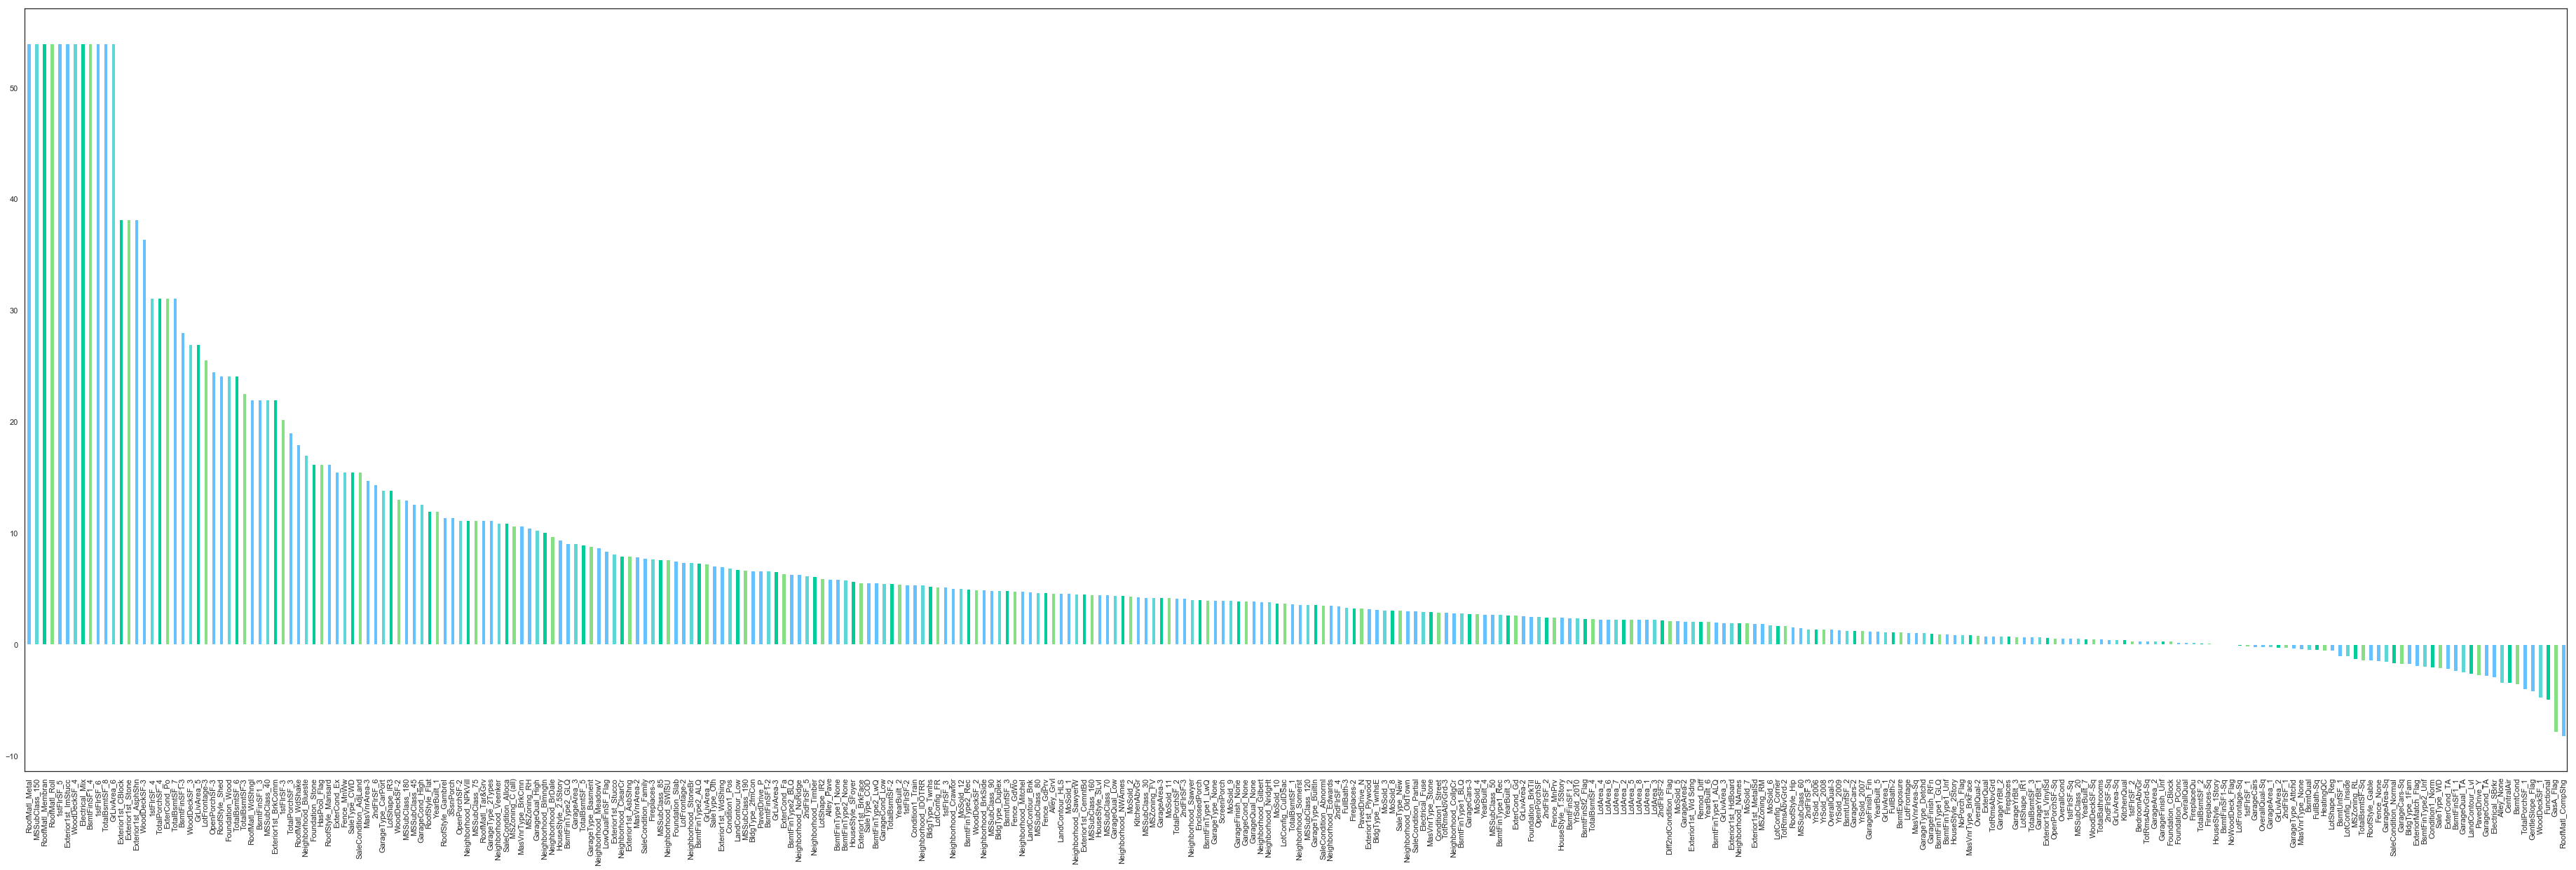

In [342]:
# Сначала давайте выделим числовые признаки
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Проверьте, насколько они искажены
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

plt.subplots(figsize =(65, 20))
skewed_feats.plot(kind='bar');

Очевидно, у нас есть множество положительно и отрицательно искаженных признаков. Теперь я преобразую объекты с перекосом> 0,5, чтобы более точно следовать нормальному распределению.

- ** Примечание **: я использую преобразование Бокса-Кокса для преобразования ненормальных переменных в нормальную форму. Нормальность является важным допущением для многих статистических методов; если ваши данные ненормальны, применение Box-Cox означает, что вы можете выполнять более широкое количество тестов.

In [343]:
skewness = skewed_feats[abs(skewed_feats) > 0.5]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

302 skewed numerical features have been Box-Cox transformed


***

<a id='modeling'></a>
# 5. 
## Моделирование

<a id='preparation_of_data'></a>
### 5.1 - Подготовка данных

- Теперь, когда наш набор данных готов к моделированию, мы должны подготовить его к обучению, тестированию и прогнозированию. Одним из важных шагов здесь является сокращение количества функций. Я сделаю это с помощью встроенного функционала важности XGBoost.

In [344]:
# Во-первых, заново создайте наборы обучающих и тестовых данных.
train = all_data[:ntrain]
test = all_data[ntrain:]

print(train.shape)
print(test.shape)

(1456, 330)
(1459, 330)


In [345]:
train.head()

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0        0.0             3  1.540963      0.730463         3    0.730463   
1        0.0             3  1.540963      1.820334         3    0.730463   
2        0.0             3  1.540963      1.194318         3    0.730463   
3        0.0             3  1.820334      0.730463         2    0.730463   
4        0.0             4  1.540963      1.540963         3    0.730463   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces          ...            \
0       0.000000   1.540963            0    0.000000          ...             
1       0.000000   1.194318            3    0.730463          ...             
2       0.000000   1.540963            3    0.730463          ...             
3       8.797736   1.194318            4    0.730463          ...             
4       0.000000   1.540963            3    0.730463          ...             

   SaleType_CWD  SaleType_New  SaleType_Oth  SaleType_WD  \
0           0.0           0.0           0.0     0.730463   
1           0.0           0.0           0.0     0.730463   
2           0.0           0.0           0.0     0.730463   
3           0.0           0.0           0.0     0.730463   
4           0.0           0.0           0.0     0.730463   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0               0.000000                    0.0                   0.0   
1               0.000000                    0.0                   0.0   
2               0.000000                    0.0                   0.0   
3               0.730463                    0.0                   0.0   
4               0.000000                    0.0                   0.0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                   0.0              0.730463                    0.0  
1                   0.0              0.730463                    0.0  
2                   0.0              0.730463                    0.0  
3                   0.0              0.000000                    0.0  
4                   0.0              0.730463                    0.0  

[5 rows x 330 columns]

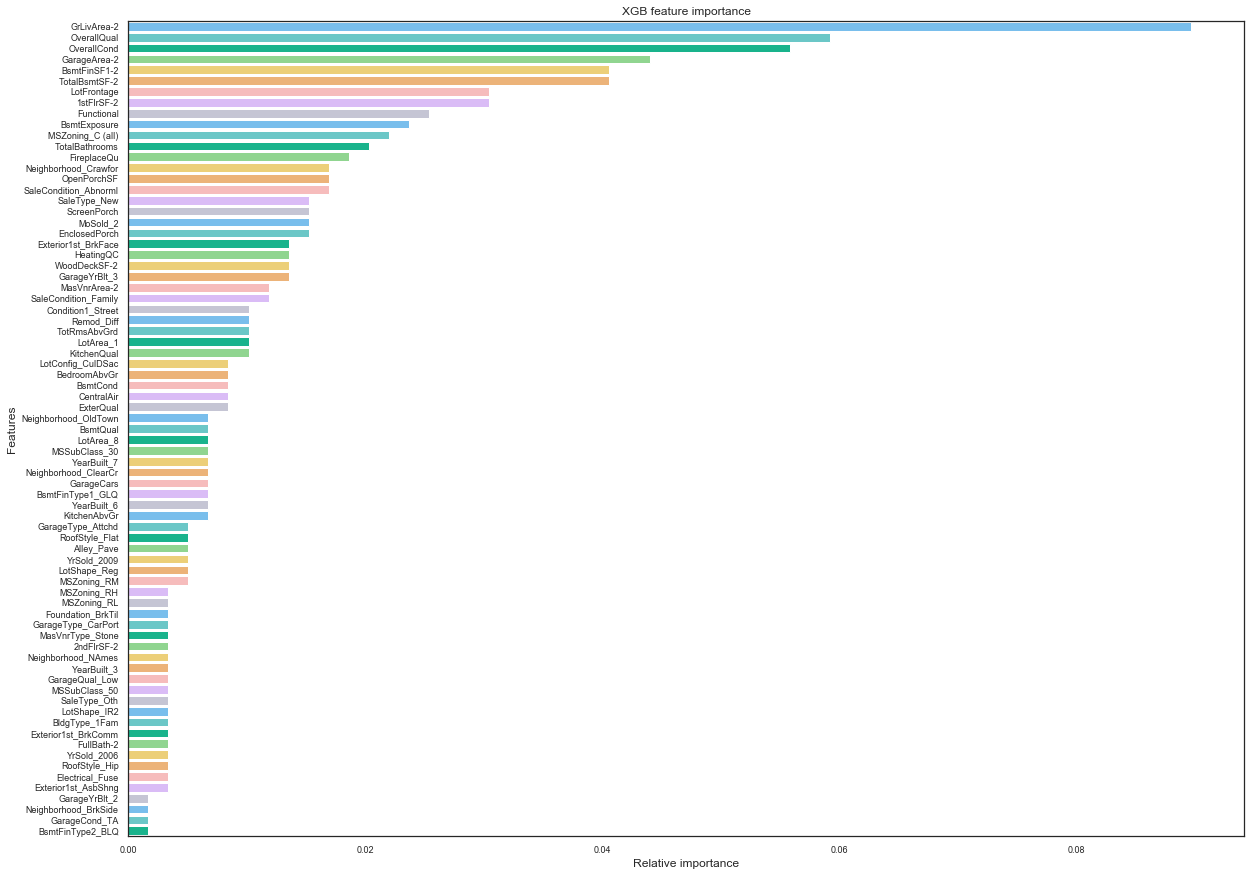

In [346]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(train, y_train)

# Сортировка значений функций из модели GBC, обученной ранее
indices = np.argsort(model.feature_importances_)[::-1]
indices = indices[:75]

# Визуализируйте это с барплотом
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=train.columns[indices], x = model.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("XGB feature importance");

In [347]:
xgb_train = train.copy()
xgb_test = test.copy()

import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(xgb_train, y_train)

# Разрешить атрибуту значимости объектов, чтобы выбрать наиболее важные переменные
xgb_feat_red = SelectFromModel(model, prefit = True)

# Сократить оценки, проверки и тестовые наборы данных
xgb_train = xgb_feat_red.transform(xgb_train)
xgb_test = xgb_feat_red.transform(xgb_test)


print("Results of 'feature_importances_':")
print('X_train: ', xgb_train.shape, '\nX_test: ', xgb_test.shape)

Results of 'feature_importances_':
X_train:  (1456, 71) 
X_test:  (1459, 71)


In [348]:
# Затем мы хотим отобрать данные обучения, чтобы проверить их робастость и точность, прежде чем применять их к данным испытаний.
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(xgb_train, y_train, test_size=0.3, random_state=42)

# X_train = predictor features for estimation dataset
# X_test = predictor variables for validation dataset
# Y_train = target variable for the estimation dataset
# Y_test = target variable for the estimation dataset

print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (1019, 71) 
X_test:  (437, 71) 
Y_train:  (1019,) 
Y_test:  (437,)


***

<a id='training'></a>
### 5.2 - Тренировка

Мы наконец готовы тренировать наши модели. Для этого анализа я использую 8 различных алгоритмов:
- **Kernel Ridge Regression**
- **Elastic Net**
- **Lasso**
- **Gradient Boosting**
- **Bayesian Ridge**
- **Lasso Lars IC**
- **Random Forest Regressor**
- **XGBoost**

Метод измерения точности ** Среднеквадратическая ошибка **, как описано в конкурсе.

In [349]:
import xgboost as xgb
# # Машинный алгоритм обучения (MLA). Выбор и инициализация
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

# Сначала я буду использовать ShuffleSplit как способ рандомизации выборок перекрестной проверки.
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#создать таблицу для сравнения показателей MLA
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
before_model_compare = pd.DataFrame(columns = columns)

# Индекс по моделям и сохранить выполнение в таблице
row_index = 0
for alg in models:

    #установить имя и параметры
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    before_model_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train, Y_train)
    
    ## оцениваем модель с перекрестной проверкой:: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    training_results = np.sqrt((-cross_val_score(alg, X_train, Y_train, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
    test_results = np.sqrt(((Y_test-alg.predict(X_test))**2).mean())
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = (training_results)*100
    before_model_compare.loc[row_index, 'Test Accuracy'] = (test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
before_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...


C:\Users\ilya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


7 RandomForestRegressor trained...
8 XGBRegressor trained...


Name  \
0                KernelRidge   
1                 ElasticNet   
2                      Lasso   
3  GradientBoostingRegressor   
4              BayesianRidge   
5                LassoLarsIC   
6      RandomForestRegressor   
7               XGBRegressor   

                                          Parameters  Train Accuracy Mean  \
0  {'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...               30.763   
1  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...               22.081   
2  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...               27.211   
3  {'alpha': 0.9, 'criterion': 'friedman_mse', 'i...               12.289   
4  {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...               11.229   
5  {'copy_X': True, 'criterion': 'aic', 'eps': 2....               12.552   
6  {'bootstrap': True, 'criterion': 'mse', 'max_d...               14.734   
7  {'base_score': 0.5, 'booster': 'gbtree', 'cols...               12.423   

   Test Accuracy  
0         32.917  
1         22.351  
2         27.333  
3         12.401  
4         11.759  
5         12.511  
6         14.910  
7         12.421

- Мы видим, что каждая из моделей работает с различной способностью: ** Bayesian Ridge ** имеет лучший показатель точности в наборе обучающих данных и точность в наборе проверочных данных.

***

<a id='optimisation'></a>
### 5.3 - Оптимизация

- Как видно из приведенной таблицы, точность этих моделей не так хороша, как могла бы быть.
- Это потому, что мы используем конфигурацию параметров по умолчанию для каждого из алгоритмов.

Поэтому теперь мы будем использовать ** GridSearchCV **, чтобы найти лучшие комбинации параметров для получения моделей с наивысшей оценкой.

** Примечание **: GridSearchCV использует сетку параметров для оптимизации алгоритмов. Эта сетка может быть очень большой, поэтому для ее завершения требуется много вычислительных ресурсов. Я включил в таблицы набор ответов, чтобы сократить время вычислений, но это были не мои последние ответы. Я оставлю это на ваше усмотрение, чтобы найти лучшие значения. Но на самом деле вам придется заполнить эти сетки соответствующими значениями, чтобы попытаться найти наилучшую комбинацию.

In [350]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

KR_param_grid = {'alpha': [0.1], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}
XGB_param_grid = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
                  'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
                  'scale_pos_weight': [1]}
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]

after_model_compare = pd.DataFrame(columns = columns)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)

    #установить имя и параметры
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    #оцениваем модель с перекрестной проверкой: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((Y_test-gs_alg.predict(X_test))**2).mean())
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = (after_training_results)*100
    after_model_compare.loc[row_index, 'Test Accuracy'] = (after_test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
after_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...
8 XGBRegressor trained...


Name  \
0                KernelRidge   
1                 ElasticNet   
2                      Lasso   
3  GradientBoostingRegressor   
4              BayesianRidge   
5                LassoLarsIC   
6      RandomForestRegressor   
7               XGBRegressor   

                                          Parameters  Train Accuracy Mean  \
0  {'alpha': 0.1, 'coef0': 100, 'degree': 1, 'gam...               11.212   
1  {'alpha': 0.001, 'copy_X': True, 'fit_intercep...               11.219   
2  {'alpha': 0.0005, 'copy_X': True, 'fit_interce...               11.194   
3  {'learning_rate': 0.1, 'loss': 'huber', 'max_d...               12.127   
4  {'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X':...               11.229   
5  {'copy_X': True, 'criterion': 'aic', 'eps': 1e...               12.552   
6  {'max_depth': None, 'max_features': 'auto', 'm...               13.829   
7  {'booster': 'gbtree', 'colsample_bylevel': 0.2...               11.979   

   Test Accuracy  
0         11.911  
1         11.914  
2         11.797  
3         12.157  
4         11.759  
5         12.511  
6         14.233  
7         11.659

В целом мы видим, что результаты обучения и тестирования для каждой из моделей снизились, чего мы и хотим.
- Теперь у нас есть набор хорошо настроенных алгоритмов, которые можно использовать для ** Стекинга**.

***

<a id='stacking'></a>
### 5.4 - Стекинг/укладка

Теперь, когда у нас есть набор хорошо настроенных алгоритмов, довольно известная и успешная методика дальнейшего повышения точности этих моделей заключается в использовании ** Стекинга **. 

Кладка кирпича - это вид искусства. ** Это именно то, что мы собираемся сделать, сложив несколько алгоритмов, чтобы сформировать гораздо более сильный. **

Шаги для этой техники показаны ниже:
1. ** Создайте набор алгоритмов, готовых для стекирования ** - Мы сделали это ...
2. ** Разделить исходные данные обучения на образец обучения и проверки ** - Мы сделали это тоже ...
3. ** Тренируйте алгоритмы на обучающем образце ** - Также сделали это ...
4. ** Для каждого алгоритма примените обученные модели к набору данных проверки и создайте набор прогнозов **, 1 столбец для каждой модели, в качестве новой таблицы. Назовите это * new training dataset *.
5. ** Также примените обученный алгоритм к тестовому набору данных и создайте окончательный набор прогнозов **, по 1 столбцу для каждой модели в виде новой таблицы. Назовите этот * new test dataset *.
6. ** Для нового набора обучающих данных мы пометили выходные данные в форме Y_test **. Теперь мы должны обучить другую модель этим двум наборам функций: *new training dataset* и Y_test.
7. ** Используйте эту недавно обученную модель для прогнозирования значений ** для * new test dataset *.


- Прежде чем начать со стекированием, мне нужно решить, какие алгоритмы использовать в качестве базовых оценок, а какие - в качестве метамодели.

- Так как ** Лассо ** показал лучшие результаты после оптимизации, я выбрал это как ** метамодель **. Все остальные модели будут использоваться в качестве базовых оценок.

- Итак, теперь я буду циклически проходить через каждый оптимизированный оценщик, обучать их набору обучающих данных, применять к ним наборы данных для проверки и тестирования, а затем, наконец, выводить прогнозы для проверки и тестировать в два новых набора данных: ** stacked_validation_train ** и ** stacked_test_train **.

In [352]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
stacked_validation_train = pd.DataFrame()
stacked_test_train = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    stacked_validation_train.insert(loc = row_index, column = names[0], value = gs_best.predict(X_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking validation dataset...')
    
    stacked_test_train.insert(loc = row_index, column = names[0], value = gs_best.predict(xgb_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking test dataset...')
    print("-"*50)
    names.pop(0)
    
    row_index+=1
    
print('Done')

1 KernelRidge predictions added to stacking validation dataset...
1 KernelRidge predictions added to stacking test dataset...
--------------------------------------------------
2 ElasticNet predictions added to stacking validation dataset...
2 ElasticNet predictions added to stacking test dataset...
--------------------------------------------------
3 Lasso predictions added to stacking validation dataset...
3 Lasso predictions added to stacking test dataset...
--------------------------------------------------
4 GradientBoostingRegressor predictions added to stacking validation dataset...
4 GradientBoostingRegressor predictions added to stacking test dataset...
--------------------------------------------------
5 BayesianRidge predictions added to stacking validation dataset...
5 BayesianRidge predictions added to stacking test dataset...
--------------------------------------------------
6 LassoLarsIC predictions added to stacking validation dataset...
6 LassoLarsIC predictions added

- Давайте кратко рассмотрим, как выглядят эти новые наборы данных:

In [353]:
stacked_validation_train.head()

KernelRidge  ElasticNet      Lasso  Gradient Boosting  Bayesian Ridge  \
0    12.095862   12.066825  12.076380          12.118402       12.107290   
1    11.934928   11.960194  11.957494          12.018334       11.924513   
2    11.785004   11.789073  11.792967          11.877250       11.786723   
3    11.786236   11.760291  11.764350          11.843397       11.787922   
4    11.294088   11.262037  11.268314          11.193234       11.293757   

   Lasso Lars IC  Random Forest    XGBoost  
0      12.104415      12.149712  12.075619  
1      12.006002      12.072684  12.078566  
2      11.781243      11.894052  11.838004  
3      11.839399      11.688194  11.752002  
4      11.302433      11.359771  11.302547

- Новый набор обучающих данных содержит 438 строк прогнозов из 8 алгоритмов, которые мы решили использовать.

In [354]:
stacked_test_train.head()

KernelRidge  ElasticNet      Lasso  Gradient Boosting  Bayesian Ridge  \
0    11.666129   11.687961  11.684217          11.737250       11.663755   
1    12.048428   12.057281  12.054487          11.955923       12.046563   
2    12.114796   12.112951  12.115499          12.137456       12.116697   
3    12.207342   12.211317  12.211600          12.134427       12.209729   
4    12.127530   12.141781  12.135093          12.129930       12.114497   

   Lasso Lars IC  Random Forest    XGBoost  
0      11.644445      11.718549  11.762799  
1      11.998478      11.972973  12.086011  
2      12.057223      12.080557  12.131135  
3      12.129703      12.098744  12.205832  
4      12.172302      12.173646  12.116448

- Новый набор тестовых данных содержит 1459 строк прогнозов из 8 алгоритмов, которые мы решили использовать.
- Я буду использовать эти два набора данных для обучения и составления прогнозов для метамодели Лассо.

In [355]:
# Сначала удалите результаты Лассо из таблицы, так как мы будем использовать Лассо в качестве мета-модели.
drop = ['Lasso']
stacked_validation_train.drop(drop, axis=1, inplace=True)
stacked_test_train.drop(drop, axis=1, inplace=True)

# Теперь подгоните метамодель и генерируйте прогнозы
meta_model = make_pipeline(RobustScaler(), Lasso(alpha=0.00001, copy_X = True, fit_intercept = True,
                                              normalize = False, precompute = False, max_iter = 10000,
                                              tol = 0.0001, selection = 'random', random_state = None))
meta_model.fit(stacked_validation_train, Y_test)

meta_model_pred = np.expm1(meta_model.predict(stacked_test_train))
print("Meta-model trained and applied!...")

Meta-model trained and applied!...


***

<a id='ensemble'></a>
### 5.5 - Ансамбль

- Тем не менее, другой известной и успешной техникой для машинного обучения являются ** методы ансамбля **.
     - Они эффективны при использовании множества разных моделей различной степени точности.
     - Они работают над идеей, что многие слабые ученики могут произвести сильного ученика.
- Поэтому, используя метамодель, которую я создам, я также объединю это с результатами отдельных оптимизированных моделей для создания ансамбля.
- Чтобы создать этот ансамбль, я должен собрать окончательные прогнозы каждой из оптимизированных моделей. Я сделаю это сейчас.

In [356]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
final_predictions = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(stacked_validation_train, Y_test)
    gs_best = gs_alg.best_estimator_
    final_predictions.insert(loc = row_index, column = names[0], value = np.expm1(gs_best.predict(stacked_test_train)))
    print(row_index+1, alg.__class__.__name__, 'final results predicted added to table...')
    names.pop(0)
    
    row_index+=1

print("-"*50)
print("Done")
    
final_predictions.head()

1 KernelRidge final results predicted added to table...
2 ElasticNet final results predicted added to table...
3 Lasso final results predicted added to table...
4 GradientBoostingRegressor final results predicted added to table...
5 BayesianRidge final results predicted added to table...
6 LassoLarsIC final results predicted added to table...
7 RandomForestRegressor final results predicted added to table...
8 XGBRegressor final results predicted added to table...
--------------------------------------------------
Done


KernelRidge     ElasticNet          Lasso  Gradient Boosting  \
0  121859.831999  122631.188749  119640.232876      122047.687204   
1  169180.259714  169732.178522  169157.911912      170730.819879   
2  184531.142655  184545.126779  183933.789676      179032.556348   
3  197220.491799  197279.807317  197902.209264      183659.561636   
4  184151.012165  184282.513178  184675.393684      182979.797009   

   Bayesian Ridge  Lasso Lars IC  Random Forest        XGBoost  
0   122977.193725  121852.165364  120881.508387  116333.132812  
1   170154.002083  169637.378491  168578.872195  168770.281250  
2   185916.623969  184725.491783  184991.511446  181586.562500  
3   198723.219731  197529.197416  183189.286026  181593.484375  
4   182622.605311  183225.357999  184282.312532  189761.796875

- Как видите, каждая из моделей дает результаты, которые варьируются довольно широко. В этом прелесть использования комбинации разных моделей.
- Некоторые модели будут намного лучше улавливать определенные сигналы в данных, тогда как другие могут работать лучше в других ситуациях.
- Создавая ансамбль всех этих результатов, это помогает создать более обобщенную модель, устойчивую к шуму.
- Теперь я закончу созданием ансамбля метамодели и оптимизированных моделей для окончательного представления.

***

<a id='submission'></a>
### 5.6 - Submission

In [357]:
ensemble = meta_model_pred*(1/10) + final_predictions['XGBoost']*(1.5/10) + final_predictions['Gradient Boosting']*(2/10) + final_predictions['Bayesian Ridge']*(1/10) + final_predictions['Lasso']*(1/10) + final_predictions['KernelRidge']*(1/10) + final_predictions['Lasso Lars IC']*(1/10) + final_predictions['Random Forest']*(1.5/10)

submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = ensemble
#submission.to_csv('final_submission.csv',index=False)
print("Submission file, created!")

Submission file, created!


***

***